In [1]:
using Revise

In [2]:
using
    QuantumStates,
    OpticalBlochEquations,
    DifferentialEquations,
    UnitsToValue,
    LinearAlgebra,
    Printf,
    Plots,
    Random,
    StatsBase
;

using Distributions

import MutableNamedTuples: MutableNamedTuple
import StructArrays: StructArray, StructVector
import StaticArrays: @SVector, SVector
import LinearAlgebra: norm, ⋅, adjoint!, diag
import LoopVectorization: @turbo
using BenchmarkTools
using Parameters
using LsqFit

import ProgressMeter: Progress, next!

const λ = 626e-9
const Γ = 2π* 6.4e6
const m = @with_unit 57 "u"
const k = 2π / λ
_μB = (μ_B / h) * 1e-4;

include("CaOH_scan_helper_v2.jl")
working_dir = "G:\\My Drive\\github\\OpticalBlochEquations\\examples\\ipynb_sources\\toy_models\\CaOH_scan\\scan_3frequencies"
;

In [3]:
function survived(t_end, times, trajectories)
    _survived = Int64[]
    for i ∈ eachindex(trajectories)
        if times[i][end] * 1e-3 ≈ t_end
            push!(_survived, i)
        end
    end
    return _survived
end

function cloud_size(trajectories, i)
    std(trajectory[i] for trajectory ∈ trajectories)
end

"""
    Evaluates the density given a set of trajectories.
"""
function density(t_end, results)
    
    times, x_trajectories, y_trajectories, z_trajectories = results.times, results.x_trajectories, results.y_trajectories, results.z_trajectories
    
    # Sample number of photons before the molecule is lost to vibrational dark state
    n_molecules = length(times)
    
    _survived = survived(t_end, times, x_trajectories)
    println(_survived)
    
    surviving_x_trajectories = x_trajectories[_survived]
    surviving_y_trajectories = y_trajectories[_survived]
    surviving_z_trajectories = z_trajectories[_survived]
    
    n = length(_survived)
    _density = Float64(n)
    if n > 1
        idx_end = length(surviving_x_trajectories[1])
        σ_x = cloud_size(surviving_x_trajectories, idx_end)
        σ_y = cloud_size(surviving_y_trajectories, idx_end)
        σ_z = cloud_size(surviving_z_trajectories, idx_end)
        _density /= σ_x * σ_y * σ_z
    end
    return _density
end

function distance(x_trajectory, y_trajectory, z_trajectory, idx)
    return sqrt(x_trajectory[idx]^2 + y_trajectory[idx]^2 + z_trajectory[idx]^2)
end

"""
    Evaluates how many particles are within a 0.3 mm radius.
"""
function goodness(t_end, results)
    
    times, x_trajectories, y_trajectories, z_trajectories = results.times, results.x_trajectories, results.y_trajectories, results.z_trajectories
    
    # Sample number of photons before the molecule is lost to vibrational dark state
    n_molecules = length(times)
    
    _survived = survived(t_end, times, x_trajectories)
    println(_survived)
    
    surviving_x_trajectories = x_trajectories[_survived]
    surviving_y_trajectories = y_trajectories[_survived]
    surviving_z_trajectories = z_trajectories[_survived]
    
    n = 0
    for survived_idx ∈ _survived
        idx_end = length(x_trajectories[survived_idx])
        if distance(x_trajectories[survived_idx], y_trajectories[survived_idx], z_trajectories[survived_idx], idx_end) < 0.5
            n += 1
        end
    end
    return n
end
;

### Set up the molecule

In [4]:
package = get_CaOH_package()
n_states = length(package.states)
n_excited = package.n_excited
;

In [5]:
# initial_params = [
#     2.0, 0.05, 0.05,
#     4.0, -1.0, 0.5
# ]

global scan_counter = 1

initial_params = [
    0.0, 0.0, 0.0,
    0.0, 0.0, 0.0
]

"""
    Function to optimize (density).
"""
function f(x)
    s1 = x[1]
    s3 = x[2]
    s4 = x[3]
    Δ1 = x[4]*Γ
    Δ3 = x[5]*Γ
    Δ4 = x[6]*Γ
    
    temp = @with_unit 0.1 "mK"
    diameter = @with_unit 0.6 "mm"
    displacement = [0.0, 0.0, 0.0]
    kick = [0,0, 0.0, 0.0]
    
    params = MutableNamedTuple(
        t_end = 15e-3, n_values = 20,
        pol1_x=σ⁻, pol2_x=σ⁺, pol3_x=σ⁻, pol4_x=σ⁺, 
        s1=s1, s2=0.0, s3=s3, s4=s4,
        Δ1=Δ1, Δ2=-0.8Γ, Δ3=Δ3, Δ4=Δ4,
        B_gradient = 30,
        temp=temp, 
        diameter=diameter,
        displacement=displacement, 
        kick=kick,
        ramp_time = 10e-3)
    
    results = simulate_particles_v2(package, params)
    
    _goodness = goodness(params.t_end, results)
    println(results.photons_scattered)
    println(_goodness)
    
    # Save the results
    serialize(working_dir * "\\" * string(scan_counter) * ".jl", results)
    global scan_counter += 1
    
    return _goodness
end
;    

In [ ]:
using BayesianOptimization, GaussianProcesses

model = ElasticGPE(6,                            # 6 input dimensions
                   mean = MeanConst(1.),         
                   kernel = SEArd([0.1, 0.1, 0.1, 0.1, 0.1, 0.1], 5.),
                   logNoise = 0.,
                   capacity = 3000)              # the initial capacity of the GP is 3000 samples
set_priors!(model.mean, [Normal(1, 1)])

# Optimize the hyperparameters of the GP using maximum a posteriori (MAP) estimates every x steps
modeloptimizer = MAPGPOptimizer(
    every = 1, 
    noisebounds = [-3, 3], # bounds of the logNoise
    kernbounds = [[-3, -3, -3, -3, -3, -3, -5], [3, 3, 3, 3, 3, 3, 5]],  # bounds of the parameters GaussianProcesses.get_param_names(model.kernel)
    maxeval = 1000)

opt = BOpt(f,
           model,
           UpperConfidenceBound(),                   # type of acquisition
           modeloptimizer,                        
           [0.0, 0.0, 0.0, +0.0, -2.0, +0.0],        # lowerbounds
           [5.0, 0.3, 0.3, +4.0, +0.0, +2.0],        # upperbounds         
           repetitions = 1,                          # evaluate the function for each input x times
           maxiterations = 2000,                       # evaluate at x input positions
           sense = Max,                              # maximize the function
           acquisitionoptions = (method = :LD_LBFGS, # run optimization of acquisition function with NLopts :LD_LBFGS method
                                 restarts = 5,       # run the NLopt method from x random initial conditions each time
                                 maxtime = 1.0,      # run the NLopt method for at most 1.0 second each time
                                 maxeval = 1000),    # run the NLopt methods for at most 1000 iterations (for other options see https://github.com/JuliaOpt/NLopt.jl)
           verbosity = BayesianOptimization.Progress)

result = boptimize!(opt)

┌ Warning: use values(kwargs) and keys(kwargs) instead of kwargs.data and kwargs.itr
│   caller = #MAPGPOptimizer#19 at gp.jl:37 [inlined]
└ @ Core C:\Users\halla\.julia\packages\BayesianOptimization\nq1HY\src\models\gp.jl:37
Progress: 100%|█████████████████████████████████████████| Time: 0:00:58


[1, 2, 4, 5, 6, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20]
[4256.0, 4148.0, 326.0, 4298.0, 4406.0, 4398.0, 712.0, 4425.0, 4309.0, 4259.0, 4417.0, 4272.0, 4286.0, 2008.0, 4238.0, 4199.0, 4412.0, 4303.0, 4763.0, 4186.0]
4


Progress: 100%|█████████████████████████████████████████| Time: 0:00:24


Int64[]
[7227.0, 19210.0, 2122.0, 3463.0, 16962.0, 14789.0, 3084.0, 4648.0, 10408.0, 5084.0, 4881.0, 155.0, 28243.0, 4098.0, 11795.0, 472.0, 4615.0, 5219.0, 13757.0, 4226.0]
0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


[4, 5, 8, 9, 10, 11, 12, 14, 19, 20]
[5492.0, 4476.0, 4826.0, 9850.0, 9836.0, 6185.0, 3057.0, 9295.0, 9280.0, 9078.0, 9941.0, 9817.0, 846.0, 9828.0, 8850.0, 2544.0, 2869.0, 7996.0, 9929.0, 9690.0]
7


Progress: 100%|█████████████████████████████████████████| Time: 0:00:45


[1, 5, 9, 10, 13, 15, 16, 17, 18, 20]
[8759.0, 959.0, 4678.0, 244.0, 8544.0, 1970.0, 2597.0, 2487.0, 9263.0, 8416.0, 6522.0, 6754.0, 8411.0, 1081.0, 7781.0, 7806.0, 10187.0, 8302.0, 6823.0, 7838.0]
0


[15]
[3732.0, 5996.0, 2470.0, 1256.0, 3660.0, 3794.0, 9200.0, 3246.0, 3095.0, 7919.0, 5039.0, 2704.0, 3875.0, 7962.0, 10493.0, 2847.0, 6876.0, 4339.0, 3676.0, 

Progress: 100%|█████████████████████████████████████████| Time: 0:00:35


2597.0]
0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:38


[2, 12, 14, 16]
[9115.0, 18759.0, 11391.0, 298.0, 1357.0, 7595.0, 14824.0, 6694.0, 1600.0, 6649.0, 1400.0, 17561.0, 10044.0, 17842.0, 2675.0, 16762.0, 14174.0, 4265.0, 8709.0, 7126.0]
2


Progress: 100%|█████████████████████████████████████████| Time: 0:00:21


Int64[]
[4436.0, 9550.0, 4768.0, 4828.0, 3829.0, 3747.0, 7388.0, 60.0, 5101.0, 3708.0, 3987.0, 1733.0, 1677.0, 6129.0, 4000.0, 1115.0, 2769.0, 5570.0, 3450.0, 2337.0]
0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:39


[5, 7, 9, 12, 13, 16, 19]
[6411.0, 1916.0, 1122.0, 3205.0, 9844.0, 1631.0, 10681.0, 690.0, 10172.0, 6470.0, 5201.0, 9361.0, 9636.0, 9544.0, 1368.0, 9941.0, 9690.0, 1363.0, 9818.0, 7170.0]
2


Progress: 100%|█████████████████████████████████████████| Time: 0:00:41


[2, 3, 6, 9, 13, 16, 17, 18, 19, 20]
[734.0, 5678.0, 5799.0, 4367.0, 755.0, 5710.0, 475.0, 23.0, 5664.0, 1932.0, 3840.0, 1712.0, 5754.0, 4158.0, 2510.0, 5741.0, 5778.0, 5659.0, 5725.0, 5894.0]
2


Progress: 100%|█████████████████████████████████████████| Time: 0:00:45


[1, 9, 11, 12, 14, 20]
[12263.0, 7722.0, 12787.0, 7043.0, 9024.0, 2533.0, 2601.0, 10424.0, 13251.0, 3633.0, 13107.0, 13123.0, 8117.0, 13197.0, 6481.0, 95.0, 6441.0, 12919.0, 3183.0, 13259.0]
1


Progress: 100%|█████████████████████████████████████████| Time: 0:00:53


[7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20]
[1264.0, 4459.0, 18.0, 1562.0, 10659.0, 6334.0, 10931.0, 11176.0, 10306.0, 10304.0, 11109.0, 10439.0, 3075.0, 10533.0, 10246.0, 10600.0, 10648.0, 10457.0, 10489.0, 10004.0]
5


Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


[11]
[10910.0, 14331.0, 14658.0, 9247.0, 9397.0, 6061.0, 584.0, 9754.0, 4206.0, 17255.0, 30902.0, 5118.0, 5711.0, 14383.0, 11870.0, 14090.0, 13574.0, 6215.0, 1962.0, 6257.0]
1


Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


[4, 8, 10, 13, 15, 18]
[6722.0, 6444.0, 1085.0, 15661.0, 13323.0, 2436.0, 1242.0, 15801.0, 7737.0, 14119.0, 11524.0, 2900.0, 15669.0, 12146.0, 15677.0, 7227.0, 4530.0, 15452.0, 8641.0, 3427.0]
3


Progress: 100%|█████████████████████████████████████████| Time: 0:00:35


[3, 11, 17, 20]
[97.0, 2856.0, 17898.0, 220.0, 5397.0, 1300.0, 3709.0, 211.0, 3092.0, 6092.0, 18386.0, 3487.0, 17386.0, 4308.0, 13680.0, 3017.0, 18543.0, 5500.0, 9104.0, 18663.0]
2


Progress: 100%|█████████████████████████████████████████| Time: 0:00:59


[1, 2, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20]
[7081.0, 6798.0, 3814.0, 6891.0, 7031.0, 6705.0, 7339.0, 7086.0, 7156.0, 7077.0, 5285.0, 7028.0, 7013.0, 7474.0, 7020.0, 6772.0, 6930.0, 7168.0, 6999.0, 7137.0]
13


Progress: 100%|█████████████████████████████████████████| Time: 0:00:38


[6, 9, 11, 12, 15, 18, 19]
[1409.0, 310.0, 1168.0, 1120.0, 930.0, 2710.0, 946.0, 1291.0, 2772.0, 1345.0, 2638.0, 2651.0, 789.0, 1381.0, 2718.0, 434.0, 1683.0, 2659.0, 2702.0, 1651.0]
0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


[1, 2, 3, 4, 6, 7, 8, 9, 11, 12, 13, 14, 16, 17, 19, 20]
[3273.0, 3144.0, 3450.0, 3181.0, 2049.0, 3066.0, 3149.0, 3087.0, 3466.0, 2523.0, 3025.0, 3379.0, 3447.0, 3309.0, 2061.0, 3222.0, 2906.0, 3352.0, 3194.0, 2998.0]
1


Progress: 100%|█████████████████████████████████████████| Time: 0:00:16


Int64[]
[8261.0, 12754.0, 11353.0, 6682.0, 6143.0, 9709.0, 5647.0, 2473.0, 13495.0, 3957.0, 5755.0, 2464.0, 8033.0, 163.0, 3262.0, 6229.0, 5001.0, 9548.0, 6252.0, 217.0]
0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:49


[1, 2, 3, 4, 8, 12, 14, 15, 16, 17, 19]
[13120.0, 13657.0, 12777.0, 13008.0, 3872.0, 12794.0, 11832.0, 12478.0, 2325.0, 3497.0, 3248.0, 13156.0, 7493.0, 13181.0, 12699.0, 13593.0, 12834.0, 7491.0, 13121.0, 358.0]
1


Progress: 100%|█████████████████████████████████████████| Time: 0:00:33


[6, 13, 20]
[5982.0, 7326.0, 8392.0, 3983.0, 2466.0, 12770.0, 1266.0, 3070.0, 8343.0, 13067.0, 5813.0, 9183.0, 12552.0, 1178.0, 1125.0, 27.0, 591.0, 4060.0, 9615.0, 12510.0]
1


Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


[1, 3, 4, 5, 6, 7, 8, 9, 12, 13, 14, 16, 18, 20]
[3771.0, 686.0, 3719.0, 3456.0, 3745.0, 4309.0, 4290.0, 3633.0, 3577.0, 3344.0, 2954.0, 4175.0, 3420.0, 3722.0, 3222.0, 3977.0, 2457.0, 4174.0, 3216.0, 4104.0]
0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:41


[3, 11, 13, 14, 19]
[2283.0, 1143.0, 19762.0, 15407.0, 2078.0, 6256.0, 15421.0, 3942.0, 3824.0, 1439.0, 17322.0, 4218.0, 16109.0, 18672.0, 901.0, 12116.0, 6343.0, 11451.0, 16577.0, 2127.0]
2


[3, 12, 16, 18, 19]
[10671.0, 6772.0, 19918.0, 10747.0, 15510.0, 15174.0, 2334.0, 3988.0, 255.0, 8369.0, 18333.0, 19562.0, 6479.0, 9300.0, 6834.0, 19053.0, 1455.0, 19781.0, 19366.0, 18704.0]
4

Progress: 100%|█████████████████████████████████████████| Time: 0:00:39


Progress: 100%|█████████████████████████████████████████| Time: 0:00:43


[1, 6, 7, 8, 10, 11, 14, 15, 16, 17, 18, 19]
[7518.0, 5118.0, 1308.0, 685.0, 1574.0, 7379.0, 7524.0, 7256.0, 383.0, 7115.0, 7494.0, 6112.0, 7627.0, 7335.0, 7346.0, 7971.0, 7497.0, 7358.0, 7608.0, 6003.0]
7


Progress: 100%|█████████████████████████████████████████| Time: 0:00:52


[1, 3, 4, 5, 6, 7, 9, 11, 14, 16, 18, 19, 20]
[3814.0, 2076.0, 3720.0, 3755.0, 3844.0, 3631.0, 3726.0, 3512.0, 3857.0, 2512.0, 3706.0, 1777.0, 1793.0, 3965.0, 705.0, 3828.0, 2611.0, 3756.0, 3667.0, 3823.0]
6


Progress: 100%|█████████████████████████████████████████| Time: 0:00:43


[7, 8, 10, 11, 19]
[2803.0, 9102.0, 1062.0, 13886.0, 8515.0, 12387.0, 16012.0, 15223.0, 9382.0, 14779.0, 15886.0, 810.0, 7507.0, 3485.0, 8028.0, 10132.0, 7055.0, 292.0, 15469.0, 11080.0]
5


Progress: 100%|█████████████████████████████████████████| Time: 0:00:50


[2, 6, 9, 11, 13, 15, 16, 17, 19]
[297.0, 9085.0, 2256.0, 2148.0, 5847.0, 9121.0, 2943.0, 4950.0, 8949.0, 2071.0, 8605.0, 654.0, 9362.0, 2706.0, 9133.0, 8948.0, 9468.0, 3743.0, 9098.0, 5707.0]
2


Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


[6, 7, 14]
[3977.0, 1366.0, 17403.0, 17079.0, 8741.0, 22206.0, 21526.0, 10960.0, 17397.0, 10505.0, 11587.0, 20911.0, 1820.0, 23002.0, 7116.0, 7197.0, 17783.0, 6022.0, 4671.0, 9627.0]
1


Progress: 100%|█████████████████████████████████████████| Time: 0:00:08


Int64[]
[5705.0, 3154.0, 1020.0, 3609.0, 612.0, 231.0, 4632.0, 1758.0, 5418.0, 5512.0, 4114.0, 7347.0, 2855.0, 3267.0, 926.0, 374.0, 249.0, 1775.0, 1609.0, 4967.0]
0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:45


[1, 2, 7, 8, 15, 19, 20]
[17747.0, 20450.0, 12681.0, 6288.0, 11334.0, 3617.0, 18294.0, 18715.0, 18284.0, 593.0, 5182.0, 5068.0, 2911.0, 10395.0, 18559.0, 7967.0, 14760.0, 12486.0, 19603.0, 17570.0]
7


[ Info: 2023-10-02T19:14:58.685	iteration: 30	current optimum: 13.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:49


[2, 5, 10, 13, 19]
[863.0, 1081.0, 588.0, 644.0, 1062.0, 340.0, 597.0, 644.0, 964.0, 1089.0, 731.0, 456.0, 962.0, 324.0, 315.0, 947.0, 469.0, 517.0, 1038.0, 515.0]
0


[ Info: 2023-10-02T19:15:51.388	iteration: 31	current optimum: 13.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:48


[2, 3, 4, 7, 12, 14, 18, 19, 20]
[4531.0, 14683.0, 15216.0, 14191.0, 7335.0, 3609.0, 14907.0, 959.0, 5656.0, 4841.0, 1820.0, 15274.0, 8010.0, 15084.0, 4844.0, 5455.0, 12148.0, 14578.0, 15220.0, 15015.0]
4


[ Info: 2023-10-02T19:16:39.963	iteration: 32	current optimum: 13.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


[2, 3, 4, 5, 7, 8, 9, 15, 16, 20]
[237.0, 287.0, 295.0, 268.0, 331.0, 228.0, 273.0, 318.0, 302.0, 156.0, 212.0, 277.0, 190.0, 283.0, 295.0, 317.0, 219.0, 293.0, 141.0, 348.0]
0


[ Info: 2023-10-02T19:17:35.042	iteration: 33	current optimum: 13.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:49
[ Info: 2023-10-02T19:18:25.080	iteration: 34	current optimum: 13.0


[1, 2, 4, 8, 9, 11, 13, 16, 19, 20]
[10079.0, 9557.0, 7301.0, 10344.0, 1696.0, 9402.0, 1581.0, 10054.0, 9957.0, 4950.0, 9561.0, 1282.0, 10068.0, 4829.0, 1166.0, 10032.0, 104.0, 2771.0, 10187.0, 10110.0]
3


Progress: 100%|█████████████████████████████████████████| Time: 0:00:43


[1, 3, 5, 6, 12, 14, 16, 19]
[348.0, 226.0, 424.0, 255.0, 454.0, 445.0, 398.0, 243.0, 146.0, 269.0, 219.0, 372.0, 243.0, 399.0, 312.0, 420.0, 349.0, 176.0, 409.0, 306.0]
0


[ Info: 2023-10-02T19:19:08.965	iteration: 35	current optimum: 13.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:45
[ Info: 2023-10-02T19:19:54.275	iteration: 36	current optimum: 13.0


[6, 10, 13, 17, 19]
[3858.0, 3999.0, 11215.0, 12370.0, 10838.0, 16402.0, 9454.0, 10285.0, 14060.0, 16725.0, 7061.0, 1302.0, 15916.0, 5188.0, 1736.0, 8402.0, 17304.0, 2385.0, 16033.0, 3686.0]
2


Progress: 100%|█████████████████████████████████████████| Time: 0:00:58


[1, 2, 3, 4, 5, 6, 7, 10, 11, 15, 16, 17, 18, 20]
[5716.0, 5835.0, 5684.0, 5469.0, 5857.0, 5657.0, 5302.0, 2515.0, 542.0, 5892.0, 5893.0, 1789.0, 1864.0, 1872.0, 5400.0, 5624.0, 5761.0, 5852.0, 1704.0, 5607.0]
6


[ Info: 2023-10-02T19:20:52.364	iteration: 37	current optimum: 13.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:39


[3, 4, 10, 16]
[5740.0, 131.0, 9258.0, 9325.0, 2664.0, 5728.0, 4220.0, 732.0, 6950.0, 9104.0, 5198.0, 2862.0, 4467.0, 2990.0, 1102.0, 9680.0, 7955.0, 1820.0, 4823.0, 6094.0]
3

[ Info: 2023-10-02T19:21:31.497	iteration: 38	current optimum: 13.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:49


[1, 3, 6, 7, 8, 11, 13, 16, 18, 19, 20]
[8396.0, 4322.0, 8473.0, 3524.0, 6583.0, 8313.0, 7842.0, 7535.0, 7222.0, 4179.0, 8431.0, 1970.0, 8759.0, 545.0, 6511.0, 8865.0, 1193.0, 8197.0, 8840.0, 8787.0]
0

[ Info: 2023-10-02T19:22:21.612	iteration: 39	current optimum: 13.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:41


[2, 3, 5, 12, 13, 18]
[1610.0, 25551.0, 24637.0, 16984.0, 25610.0, 3763.0, 1003.0, 9248.0, 7944.0, 5067.0, 9174.0, 23817.0, 24294.0, 13513.0, 18573.0, 2051.0, 18806.0, 24617.0, 1129.0, 2707.0]
3

[ Info: 2023-10-02T19:23:03.192	iteration: 40	current optimum: 13.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:52


[1, 2, 4, 5, 10, 11, 13, 15, 16, 18, 20]
[836.0, 763.0, 295.0, 838.0, 759.0, 765.0, 733.0, 461.0, 562.0, 880.0, 870.0, 580.0, 854.0, 593.0, 769.0, 878.0, 567.0, 840.0, 674.0, 865.0]
0

[ Info: 2023-10-02T19:23:56.294	iteration: 41	current optimum: 13.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


[4, 5, 7, 8, 11, 14, 16, 18, 19, 20]
[435.0, 630.0, 964.0, 1239.0, 1225.0, 894.0, 1145.0, 1276.0, 263.0, 601.0, 1246.0, 365.0, 483.0, 1209.0, 741.0, 1108.0, 733.0, 1227.0, 1197.0, 1214.0]
0


[ Info: 2023-10-02T19:24:51.206	iteration: 42	current optimum: 13.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:57
[ Info: 2023-10-02T19:25:48.772	iteration: 43	current optimum: 13.0


[2, 3, 4, 5, 8, 9, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
[2742.0, 5305.0, 5117.0, 5451.0, 5488.0, 2725.0, 1173.0, 5266.0, 5566.0, 2173.0, 5333.0, 5378.0, 5292.0, 5616.0, 5158.0, 5336.0, 5538.0, 5358.0, 5630.0, 5435.0]
7


Progress: 100%|█████████████████████████████████████████| Time: 0:00:50
[ Info: 2023-10-02T19:26:39.500	iteration: 44	current optimum: 13.0


[3, 8, 13]
[284.0, 82.0, 572.0, 463.0, 415.0, 374.0, 356.0, 585.0, 353.0, 501.0, 443.0, 356.0, 609.0, 313.0, 479.0, 172.0, 304.0, 394.0, 458.0, 541.0]
0


Progress: 100%|█████████████████████████████████████████| Time: 0:01:10


[2, 3, 5, 6, 7, 8, 9, 10, 13, 14, 15, 16, 17, 18, 20]
[304.0, 3175.0, 3083.0, 1626.0, 3317.0, 3415.0, 3181.0, 3232.0, 3248.0, 3257.0, 2109.0, 3103.0, 3226.0, 3133.0, 3277.0, 3204.0, 3232.0, 3133.0, 2974.0, 3355.0]
0

[ Info: 2023-10-02T19:27:50.551	iteration: 45	current optimum: 13.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:45
[ Info: 2023-10-02T19:28:35.760	iteration: 46	current optimum: 13.0


[3, 6, 7, 9, 10, 11, 12, 14, 15, 17, 20]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:08


Int64[]
[2585.0, 3193.0, 3384.0, 4293.0, 2908.0, 3540.0, 4031.0, 4105.0, 1428.0, 4892.0, 510.0, 3401.0, 1799.0, 5476.0, 3323.0, 2484.0, 5083.0, 3585.0, 4605.0, 4093.0]
0

[ Info: 2023-10-02T19:28:44.253	iteration: 47	current optimum: 13.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:48


[2, 5, 8, 11, 16, 20]
[44.0, 111.0, 93.0, 98.0, 114.0, 69.0, 50.0, 119.0, 115.0, 112.0, 117.0, 62.0, 78.0, 40.0, 58.0, 105.0, 128.0, 54.0, 101.0, 126.0]


[ Info: 2023-10-02T19:29:33.349	iteration: 48	current optimum: 13.0


0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:44


[2, 9, 10, 13, 14, 20]
[1464.0, 10397.0, 840.0, 475.0, 525.0, 4270.0, 7848.0, 4100.0, 9829.0, 9855.0, 4273.0, 5893.0, 9769.0, 10610.0, 10275.0, 8348.0, 4263.0, 5859.0, 2802.0, 9868.0]
6


[ Info: 2023-10-02T19:30:18.093	iteration: 49	current optimum: 13.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:59


[1, 2, 5, 6, 8, 11, 12, 13, 14, 17, 19]
[6546.0, 6970.0, 6608.0, 610.0, 6532.0, 6516.0, 1219.0, 6102.0, 4125.0, 3070.0, 6625.0, 6961.0, 6590.0, 6604.0, 1343.0, 5079.0, 6775.0, 4364.0, 6594.0, 5228.0]
2

[ Info: 2023-10-02T19:31:17.565	iteration: 50	current optimum: 13.0


Progress: 100%|█████████████████████████████████████████| Time: 0:01:19
[ Info: 2023-10-02T19:32:37.168	iteration: 51	current optimum: 13.0


[1, 2, 3, 5, 6, 7, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19]
[3036.0, 2887.0, 2917.0, 2842.0, 3155.0, 2882.0, 3080.0, 2002.0, 2749.0, 2739.0, 2715.0, 2975.0, 3055.0, 3098.0, 2948.0, 2924.0, 3014.0, 3174.0, 2803.0, 2009.0]
2


Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


[1, 3, 5, 6, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20]
[4144.0, 3857.0, 4271.0, 2549.0, 4354.0, 4638.0, 2301.0, 4241.0, 5696.0, 5399.0, 4540.0, 1790.0, 5544.0, 5034.0, 6307.0, 4439.0, 4254.0, 4262.0, 4441.0, 4320.0]
9

[ Info: 2023-10-02T19:33:31.957	iteration: 52	current optimum: 13.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:11


Int64[]
[4192.0, 6235.0, 6446.0, 1031.0, 5524.0, 2676.0, 6908.0, 4590.0, 4120.0, 8792.0, 3619.0, 3259.0, 10131.0, 4100.0, 6453.0, 4366.0, 9452.0, 7891.0, 12120.0, 4371.0]
0


[ Info: 2023-10-02T19:33:43.562	iteration: 53	current optimum: 13.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:53


[1, 2, 4, 5, 9, 10, 11, 12, 13, 14, 16, 17, 19]
[4853.0, 4990.0, 1326.0, 5171.0, 4943.0, 4202.0, 2943.0, 379.0, 4915.0, 5271.0, 4807.0, 4994.0, 4868.0, 5022.0, 3860.0, 4565.0, 5269.0, 1240.0, 5147.0, 3624.0]
7


[ Info: 2023-10-02T19:34:37.424	iteration: 54	current optimum: 13.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:41
[ Info: 2023-10-02T19:35:19.210	iteration: 55	current optimum: 13.0


[3, 5, 8, 13, 16, 20]
[541.0, 389.0, 659.0, 497.0, 619.0, 490.0, 590.0, 644.0, 462.0, 340.0, 466.0, 328.0, 593.0, 542.0, 479.0, 603.0, 473.0, 401.0, 273.0, 612.0]
0


[1, 2, 3, 8, 11, 12, 17, 18]
[11095.0, 10905.0, 11148.0, 4004.0, 2442.0, 5290.0, 7144.0, 10925.0, 11389.0, 8628.0, 11577.0, 11366.0, 5088.0, 3361.0, 5585.0, 2246.0, 10900.0, 11256.0, 4045.0, 7665.0]
1


Progress: 100%|█████████████████████████████████████████| Time: 0:00:49
[ Info: 2023-10-02T19:36:08.380	iteration: 56	current optimum: 13.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:46


[1, 3, 4, 6, 7, 8, 10, 13, 17, 18, 19]
[9820.0, 1636.0, 9725.0, 10172.0, 7307.0, 9331.0, 9544.0, 9990.0, 2151.0, 9823.0, 3009.0, 3256.0, 9775.0, 9388.0, 1116.0, 413.0, 9849.0, 9829.0, 9860.0, 3144.0]
6

[ Info: 2023-10-02T19:36:55.014	iteration: 57	current optimum: 13.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:42
[ Info: 2023-10-02T19:37:37.937	iteration: 58	current optimum: 13.0


[3, 11, 14, 17, 18, 19]
[10466.0, 4575.0, 13155.0, 4455.0, 9852.0, 10252.0, 8778.0, 11050.0, 4805.0, 3497.0, 13269.0, 7863.0, 7892.0, 13671.0, 9306.0, 4952.0, 13685.0, 12790.0, 13179.0, 10598.0]
4


Progress: 100%|█████████████████████████████████████████| Time: 0:00:49


[2, 3, 4, 6, 7, 9, 10, 12, 13, 14, 16, 18, 19, 20]
[3303.0, 7903.0, 7745.0, 8020.0, 1015.0, 7703.0, 7422.0, 3262.0, 7653.0, 7788.0, 4848.0, 7697.0, 7790.0, 7918.0, 621.0, 7624.0, 4779.0, 7733.0, 7432.0, 7636.0]
8


[ Info: 2023-10-02T19:38:27.527	iteration: 59	current optimum: 13.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:49


[3, 4, 6, 8, 10, 14, 16, 20]
[3566.0, 664.0, 14062.0, 13900.0, 7825.0, 14824.0, 8120.0, 13714.0, 2129.0, 15669.0, 1993.0, 11246.0, 3430.0, 13364.0, 13233.0, 13312.0, 11902.0, 3683.0, 3778.0, 14675.0]
5

[ Info: 2023-10-02T19:39:16.784	iteration: 60	current optimum: 13.0


Progress: 100%|█████████████████████████████████████████| Time: 0:01:00
[ Info: 2023-10-02T19:40:17.296	iteration: 61	current optimum: 13.0


[2, 3, 4, 5, 6, 8, 9, 10, 12, 13, 14, 15, 16, 18, 19, 20]
[3592.0, 4459.0, 4366.0, 4541.0, 4562.0, 4466.0, 2686.0, 4469.0, 4451.0, 4657.0, 1003.0, 4242.0, 4561.0, 4348.0, 4602.0, 4380.0, 2978.0, 4967.0, 4413.0, 4511.0]
4


Progress: 100%|█████████████████████████████████████████| Time: 0:00:53
[ Info: 2023-10-02T19:41:11.093	iteration: 62	current optimum: 13.0


[1, 2, 4, 6, 7, 8, 10, 11, 12, 13, 15, 16, 20]
[5297.0, 5106.0, 4670.0, 5163.0, 622.0, 5291.0, 5255.0, 5040.0, 2951.0, 5318.0, 5117.0, 4992.0, 5426.0, 3243.0, 5100.0, 5227.0, 3991.0, 4756.0, 2878.0, 5015.0]
5


Progress: 100%|█████████████████████████████████████████| Time: 0:00:57


[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 13, 14, 16, 17, 18, 19]
[1057.0, 1127.0, 1113.0, 1065.0, 1104.0, 1094.0, 1104.0, 1187.0, 1171.0, 1126.0, 525.0, 547.0, 1109.0, 1073.0, 690.0, 1040.0, 1102.0, 1060.0, 1057.0, 554.0]
0


[ Info: 2023-10-02T19:42:08.919	iteration: 63	current optimum: 13.0


[3, 5, 6, 7, 8, 9, 10, 13, 14, 15, 16, 17, 19, 20]
[6691.0, 4753.0, 9475.0, 899.0, 8725.0, 8858.0, 8027.0, 8548.0, 8965.0, 8750.0, 53.0, 2278.0, 8671.0, 8527.0, 9089.0, 8885.0, 8160.0, 5002.0, 8383.0, 9306.0]
7

Progress: 100%|█████████████████████████████████████████| Time: 0:00:52
[ Info: 2023-10-02T19:43:01.438	iteration: 64	current optimum: 13.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:30
[ Info: 2023-10-02T19:43:31.868	iteration: 65	current optimum: 13.0


[1, 13]
[19606.0, 396.0, 3945.0, 3368.0, 12617.0, 13978.0, 1478.0, 1861.0, 111.0, 5502.0, 1712.0, 7041.0, 19388.0, 4670.0, 16769.0, 1959.0, 895.0, 9605.0, 8556.0, 5386.0]
2


Progress: 100%|█████████████████████████████████████████| Time: 0:00:48


[1, 2, 5, 9, 10, 12, 13, 14, 15, 17, 18, 20]
[6002.0, 6838.0, 1739.0, 5185.0, 6898.0, 219.0, 1274.0, 2450.0, 7000.0, 6754.0, 4983.0, 6783.0, 6958.0, 6825.0, 6894.0, 6237.0, 6958.0, 6857.0, 6736.0, 6672.0]
4


[ Info: 2023-10-02T19:44:20.601	iteration: 66	current optimum: 13.0


[1, 2, 4, 5, 6, 8, 9, 10, 12, 13, 14, 15, 16, 18]
[5069.0, 5297.0, 1656.0, 5189.0, 5183.0, 5274.0, 1193.0, 5107.0, 5281.0, 5016.0, 5058.0, 5329.0, 5058.0, 5069.0, 5259.0, 5160.0, 3132.0, 5216.0, 1026.0, 2544.0]
4


Progress: 100%|█████████████████████████████████████████| Time: 0:00:56
[ Info: 2023-10-02T19:45:17.468	iteration: 67	current optimum: 13.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:46

[3, 5, 9, 12, 13, 14, 16, 17, 19, 20]
[2026.0, 4125.0, 9550.0, 1061.0, 9334.0, 529.0, 1296.0, 1788.0, 9465.0, 8618.0, 664.0, 9831.0, 9745.0, 9324.0, 301.0, 9357.0, 9369.0, 9246.0, 9873.0, 9889.0]
8


[ Info: 2023-10-02T19:46:04.407	iteration: 68	current optimum: 13.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:43


[1, 3, 5, 7, 9, 12, 17]
[15449.0, 12760.0, 14790.0, 9148.0, 15752.0, 14120.0, 15643.0, 292.0, 15741.0, 6670.0, 741.0, 15296.0, 10268.0, 5177.0, 13240.0, 3289.0, 14978.0, 7702.0, 6552.0, 577.0]
3

[ Info: 2023-10-02T19:46:48.218	iteration: 69	current optimum: 13.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


[3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20]
[1209.0, 2710.0, 4232.0, 4414.0, 4334.0, 4300.0, 4730.0, 4383.0, 3220.0, 4567.0, 4469.0, 4370.0, 4341.0, 4323.0, 4464.0, 2164.0, 4148.0, 4144.0, 4356.0, 4483.0]
4


[ Info: 2023-10-02T19:47:43.718	iteration: 70	current optimum: 13.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:49


[1, 2, 3, 6, 8, 9, 11, 12, 13, 16, 17, 19]
[7240.0, 7445.0, 7526.0, 7239.0, 2585.0, 7729.0, 7186.0, 7647.0, 7153.0, 6661.0, 7502.0, 7133.0, 7205.0, 634.0, 577.0, 7126.0, 7109.0, 4111.0, 7761.0, 1185.0]
4


[ Info: 2023-10-02T19:48:33.112	iteration: 71	current optimum: 13.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:51


[1, 2, 3, 5, 6, 7, 8, 9, 11, 14, 15, 16, 18, 19]
[10469.0, 10497.0, 10454.0, 5524.0, 10059.0, 10457.0, 10471.0, 10351.0, 10014.0, 1085.0, 10710.0, 6583.0, 5941.0, 11279.0, 11207.0, 10937.0, 1196.0, 11194.0, 10425.0, 5466.0]
5


[ Info: 2023-10-02T19:49:24.699	iteration: 72	current optimum: 13.0
Progress: 100%|█████████████████████████████████████████| Time: 0:01:13
[ Info: 2023-10-02T19:50:38.195	iteration: 73	current optimum: 13.0


[2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 18, 19, 20]
[1650.0, 2012.0, 1786.0, 1978.0, 1833.0, 1866.0, 1816.0, 1789.0, 1976.0, 1849.0, 1774.0, 1765.0, 921.0, 1803.0, 1826.0, 1738.0, 1393.0, 1900.0, 1824.0, 1754.0]
2


Progress: 100%|█████████████████████████████████████████| Time: 0:00:49


[2, 4, 5, 6, 11, 12, 14, 17, 18, 20]
[3467.0, 5309.0, 2911.0, 5601.0, 5419.0, 5385.0, 558.0, 1494.0, 4794.0, 2649.0, 5584.0, 5193.0, 641.0, 5495.0, 609.0, 3418.0, 5444.0, 5354.0, 3731.0, 5132.0]
0

[ Info: 2023-10-02T19:51:27.829	iteration: 74	current optimum: 13.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:40


[2, 4, 5, 6, 7, 8, 9, 12, 15, 17]
[150.0, 12657.0, 908.0, 13439.0, 13320.0, 13910.0, 13474.0, 13473.0, 12697.0, 8706.0, 151.0, 13747.0, 8621.0, 9323.0, 12937.0, 3125.0, 12944.0, 9284.0, 2712.0, 1089.0]
8


[ Info: 2023-10-02T19:52:08.710	iteration: 75	current optimum: 13.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


[2, 4, 5, 6, 8, 9, 10, 12, 13, 14, 16, 18, 19]
[7145.0, 7849.0, 5745.0, 7990.0, 7715.0, 8063.0, 1487.0, 7981.0, 8033.0, 8041.0, 2344.0, 7756.0, 7913.0, 7657.0, 7491.0, 7909.0, 6365.0, 7975.0, 7835.0, 3962.0]
5


[ Info: 2023-10-02T19:53:03.268	iteration: 76	current optimum: 13.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:37


[9, 10, 17, 18, 20]
[4243.0, 13051.0, 9196.0, 2143.0, 5006.0, 14136.0, 6156.0, 11902.0, 18582.0, 18699.0, 1010.0, 3075.0, 3904.0, 17306.0, 2259.0, 1878.0, 19812.0, 19763.0, 5715.0, 20298.0]
0


[ Info: 2023-10-02T19:53:41.192	iteration: 77	current optimum: 13.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:27


Int64[]
[8681.0, 10248.0, 139.0, 6054.0, 3171.0, 10048.0, 6734.0, 3295.0, 5458.0, 6276.0, 13103.0, 7740.0, 10580.0, 2035.0, 5714.0, 663.0, 1383.0, 3816.0, 2321.0, 4270.0]
0


[ Info: 2023-10-02T19:54:08.885	iteration: 78	current optimum: 13.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:49


[1, 6, 9, 10, 13, 15, 17, 18]
[7010.0, 37.0, 1048.0, 3953.0, 1794.0, 6892.0, 1969.0, 4878.0, 7326.0, 6920.0, 3690.0, 3080.0, 6728.0, 4775.0, 7061.0, 4447.0, 7158.0, 6761.0, 5804.0, 5331.0]
2

[ Info: 2023-10-02T19:54:58.917	iteration: 79	current optimum: 13.0


[1, 2, 3, 4, 5, 6, 7, 9, 10, 12, 13, 14, 15, 16, 17, 18]
[1891.0, 1916.0, 1867.0, 1820.0, 1845.0, 1784.0, 1783.0, 1315.0, 1767.0, 1657.0, 1323.0, 1893.0, 1958.0, 1883.0, 1804.0, 1830.0, 1812.0, 1801.0, 1818.0, 613.0]
2


Progress: 100%|█████████████████████████████████████████| Time: 0:01:01
[ Info: 2023-10-02T19:56:00.855	iteration: 80	current optimum: 13.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:55
[ Info: 2023-10-02T19:56:56.180	iteration: 81	current optimum: 13.0


[1, 2, 6, 7, 8, 10, 12, 15, 16, 17, 18, 19, 20]
[4945.0, 4800.0, 3163.0, 3711.0, 2336.0, 4571.0, 4366.0, 4916.0, 1283.0, 4586.0, 4478.0, 4491.0, 1470.0, 402.0, 5445.0, 4467.0, 4513.0, 4641.0, 4958.0, 4074.0]
4


Progress: 100%|█████████████████████████████████████████| Time: 0:01:01


[2, 5, 6, 8, 10, 11, 12, 15, 17, 18, 19, 20]
[4243.0, 6705.0, 3223.0, 1446.0, 7042.0, 6516.0, 2331.0, 6964.0, 3277.0, 7190.0, 7080.0, 7242.0, 3901.0, 4400.0, 6913.0, 1953.0, 7075.0, 7170.0, 6982.0, 7065.0]
1

[ Info: 2023-10-02T19:57:57.330	iteration: 82	current optimum: 13.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


[1, 2, 5, 7, 11, 12, 14, 15, 16, 18, 19, 20]
[7978.0, 7957.0, 5381.0, 1122.0, 7444.0, 2758.0, 8451.0, 554.0, 7216.0, 5244.0, 8690.0, 8324.0, 7270.0, 7734.0, 7924.0, 7577.0, 7121.0, 9185.0, 8507.0, 7575.0]
5

[ Info: 2023-10-02T19:58:52.958	iteration: 83	current optimum: 13.0


[10, 14, 17]
[7649.0, 1407.0, 6932.0, 3253.0, 9173.0, 9226.0, 7254.0, 9020.0, 5838.0, 13732.0, 11890.0, 6145.0, 12081.0, 13980.0, 8844.0, 835.0, 13872.0, 12240.0, 6043.0, 6760.0]
0

Progress: 100%|█████████████████████████████████████████| Time: 0:00:37


[ Info: 2023-10-02T19:59:30.889	iteration: 84	current optimum: 13.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:53


[1, 2, 3, 4, 5, 6, 9, 10, 12, 15, 16]
[5865.0, 5808.0, 5638.0, 5994.0, 5799.0, 5645.0, 2905.0, 4932.0, 5180.0, 6010.0, 3115.0, 6110.0, 700.0, 396.0, 5695.0, 5903.0, 616.0, 2369.0, 1161.0, 3271.0]
4

[ Info: 2023-10-02T20:00:24.903	iteration: 85	current optimum: 13.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:40


[6, 7, 12, 15]
[2972.0, 11625.0, 18523.0, 5333.0, 18415.0, 20395.0, 20402.0, 5713.0, 3058.0, 15718.0, 13426.0, 19969.0, 9712.0, 9600.0, 17188.0, 3810.0, 4406.0, 86.0, 18064.0

[ Info: 2023-10-02T20:01:05.815	iteration: 86	current optimum: 13.0


, 4035.0]
1


Progress: 100%|█████████████████████████████████████████| Time: 0:00:44


[4, 16, 20]
[3722.0, 3506.0, 3945.0, 6302.0, 707.0, 4827.0, 2733.0, 6092.0, 5788.0, 970.0, 4467.0, 4008.0, 1018.0, 4962.0, 4383.0, 6077.0, 6146.0, 3808.0, 4404.0, 6153.0]
1


[ Info: 2023-10-02T20:01:50.238	iteration: 87	current optimum: 13.0
Progress: 100%|█████████████████████████████████████████| Time: 0:01:01


[1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 13, 16, 19, 20]
[5423.0, 5220.0, 4971.0, 5167.0, 5038.0, 719.0, 5043.0, 5117.0, 5024.0, 5051.0, 5324.0, 4324.0, 5161.0, 691.0, 4066.0, 5148.0, 1854.0, 1856.0, 4931.0, 5228.0]
5


[ Info: 2023-10-02T20:02:52.137	iteration: 88	current optimum: 13.0
Progress: 100%|█████████████████████████████████████████| Time: 0:01:11


[1, 2, 3, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
[2128.0, 2194.0, 2140.0, 1591.0, 2126.0, 2065.0, 2061.0, 2133.0, 1958.0, 2128.0, 2191.0, 2158.0, 2137.0, 2061.0, 2152.0, 2024.0, 2280.0, 2182.0, 2203.0, 2135.0]
3


[ Info: 2023-10-02T20:04:03.749	iteration: 89	current optimum: 13.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
[ Info: 2023-10-02T20:04:39.244	iteration: 90	current optimum: 13.0


[14, 17, 19, 20]
[8245.0, 7852.0, 15145.0, 4657.0, 1823.0, 11683.0, 2944.0, 1110.0, 17432.0, 3274.0, 3692.0, 1252.0, 2247.0, 20436.0, 1408.0, 11663.0, 21672.0, 8245.0, 23022.0, 19992.0]
1


Progress: 100%|█████████████████████████████████████████| Time: 0:00:48


[2, 3, 9, 16, 18, 19]
[9555.0, 11637.0, 12932.0, 7124.0, 3382.0, 3295.0, 12831.0, 4094.0, 12535.0, 6393.0, 2579.0, 3516.0, 2867.0, 3430.0, 7659.0, 12676.0, 9108.0, 11739.0, 12646.0, 2929.0]
3

[ Info: 2023-10-02T20:05:27.656	iteration: 91	current optimum: 13.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:57


[3, 4, 6, 7, 9, 11, 12, 13, 14, 15, 18, 19, 20]
[3207.0, 1483.0, 4837.0, 4808.0, 1017.0, 4438.0, 4551.0, 412.0, 4642.0, 2721.0, 4523.0, 4690.0, 4593.0, 4370.0, 4381.0, 2628.0, 4252.0, 4882.0, 4610.0, 4752.0]
4

[ Info: 2023-10-02T20:06:25.522	iteration: 92	current optimum: 13.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:47
[ Info: 2023-10-02T20:07:13.288	iteration: 93	current optimum: 13.0


[1, 2, 3, 4, 5, 6, 7, 17, 18, 19, 20]
[11097.0, 10583.0, 10410.0, 10634.0, 10772.0, 10796.0, 11156.0, 4057.0, 5836.0, 10689.0, 5688.0, 6093.0, 655.0, 3282.0, 8734.0, 4829.0, 10811.0, 10708.0, 10610.0, 10260.0]
4


Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
[ Info: 2023-10-02T20:07:47.519	iteration: 94	current optimum: 13.0


[1, 5, 14, 17]
[21649.0, 590.0, 2374.0, 6982.0, 20684.0, 2299.0, 16882.0, 4487.0, 16619.0, 5583.0, 3087.0, 6835.0, 2518.0, 19824.0, 21283.0, 13230.0, 21604.0, 6118.0, 6506.0, 4692.0]
0


Progress: 100%|█████████████████████████████████████████| Time: 0:01:02


[1, 3, 5, 6, 10, 12, 15, 17, 18, 19, 20]
[5138.0, 1005.0, 4747.0, 3933.0, 4902.0, 4991.0, 3927.0, 1642.0, 4658.0, 4812.0, 4651.0, 5018.0, 597.0, 2597.0, 4832.0, 4603.0, 4824.0, 4791.0, 5045.0, 5001.0]
0


[ Info: 2023-10-02T20:08:50.199	iteration: 95	current optimum: 13.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:49


[2, 3, 6, 8, 10, 12, 13, 15, 18, 20]
[3216.0, 4980.0, 5327.0, 1672.0, 3884.0, 5239.0, 1268.0, 5020.0, 3391.0, 4997.0, 2072.0, 5080.0, 5212.0, 2090.0, 5078.0, 19.0, 262.0, 5123.0, 4693.0, 4937.0]
6

[ Info: 2023-10-02T20:09:40.167	iteration: 96	current optimum: 13.0


Progress: 100%|█████████████████████████████████████████| Time: 0:01:00


[1, 2, 3, 4, 5, 7, 8, 9, 15, 17, 18, 20]
[3859.0, 3850.0, 3701.0, 3654.0, 3713.0, 1251.0, 3769.0, 3729.0, 3700.0, 706.0, 1713.0, 3025.0, 702.0, 2653.0, 3911.0, 96.0, 3759.0, 3604.0, 3462.0, 3635.0]
2


[ Info: 2023-10-02T20:10:41.064	iteration: 97	current optimum: 13.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:41


[10, 11, 19, 20]
[7308.0, 7192.0, 8304.0, 1982.0, 7798.0, 9933.0, 2935.0, 9927.0, 1808.0, 22553.0, 21281.0, 15024.0, 18079.0, 15170.0, 17804.0, 10659.0, 9730.0, 16068.0, 21198.0, 22137.0]
0


[ Info: 2023-10-02T20:11:22.867	iteration: 98	current optimum: 13.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:56

[1, 4, 6, 12, 13, 14, 16, 17, 19]
[10098.0, 8502.0, 7645.0, 10295.0, 758.0, 9694.0, 6160.0, 2262.0, 682.0, 8199.0, 5680.0, 10343.0, 10730.0, 10856.0, 9538.0, 10572.0, 10782.0, 2552.0, 10060.0, 4181.0]
4


[ Info: 2023-10-02T20:12:19.044	iteration: 99	current optimum: 13.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:50


[1, 2, 8, 9, 10, 13, 14, 18, 20]
[6189.0, 6390.0, 3755.0, 4308.0, 1820.0, 2498.0, 5553.0, 6574.0, 6487.0, 6816.0, 4709.0, 1296.0, 6033.0, 6361.0, 1455.0, 3651.0, 2184.0, 6818.0, 362.0, 6362.0]
4

[ Info: 2023-10-02T20:13:09.367	iteration: 100	current optimum: 13.0



[2, 3, 5, 6, 7, 8, 9, 11, 13, 15, 17, 20]
[7328.0, 10050.0, 9337.0, 9562.0, 9911.0, 9528.0, 9238.0, 10106.0, 8971.0, 1391.0, 9873.0, 9251.0, 10009.0, 6711.0, 9782.0, 9597.0, 10202.0, 2176.0, 9415.0, 9921.0]
2

Progress: 100%|█████████████████████████████████████████| Time: 0:00:53
[ Info: 2023-10-02T20:14:03.061	iteration: 101	current optimum: 13.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


[2, 3, 4, 12, 13, 16, 17]
[870.0, 8645.0, 9504.0, 8969.0, 2939.0, 5059.0, 7056.0, 8832.0, 281.0, 5457.0, 1626.0, 10762.0, 9106.0, 7088.0, 3458.0, 9195.0, 10177.0, 1239.0, 3367.0, 1731.0]
3

[ Info: 2023-10-02T20:14:50.997	iteration: 102	current optimum: 13.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:25


Int64[]
[8056.0, 592.0, 9223.0, 3377.0, 8228.0, 5500.0, 7361.0, 4609.0, 5911.0, 1098.0, 4907.0, 2353.0, 3070.0, 2307.0, 4459.0, 3110.0, 3600.0, 2576.0, 2659.0, 5675.0]
0

[ Info: 2023-10-02T20:15:16.562	iteration: 103	current optimum: 13.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:55
[ Info: 2023-10-02T20:16:11.922	iteration: 104	current optimum: 13.0


[1, 2, 3, 4, 5, 7, 8, 11, 12, 14, 15, 16, 18]
[9765.0, 8194.0, 8859.0, 9321.0, 9193.0, 3880.0, 9002.0, 9062.0, 2514.0, 5813.0, 8587.0, 9250.0, 2283.0, 8325.0, 9168.0, 9590.0, 3925.0, 8853.0, 6518.0, 5483.0]
3


Progress: 100%|█████████████████████████████████████████| Time: 0:00:49
[ Info: 2023-10-02T20:17:01.101	iteration: 105	current optimum: 13.0


[1, 4, 5, 6, 8, 9, 10, 11, 13, 16, 19]
[11247.0, 478.0, 10563.0, 10661.0, 10300.0, 10572.0, 10198.0, 10818.0, 11173.0, 10986.0, 10926.0, 1514.0, 10958.0, 8675.0, 8308.0, 10613.0, 8787.0, 4064.0, 10573.0, 10328.0]
11


Progress: 100%|█████████████████████████████████████████| Time: 0:00:51
[ Info: 2023-10-02T20:17:52.275	iteration: 106	current optimum: 13.0


[7, 9, 10, 11, 13, 15, 16, 18, 19, 20]
[1560.0, 4421.0, 395.0, 7383.0, 1373.0, 5288.0, 8612.0, 3444.0, 8111.0, 7939.0, 7958.0, 1014.0, 8063.0, 5778.0, 9578.0, 8055.0, 822.0, 7739.0, 7974.0, 8387.0]
4


Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


[3, 4, 10, 11, 17, 19]
[6144.0, 2367.0, 15066.0, 15205.0, 9644.0, 2681.0, 2038.0, 13704.0, 125.0, 14653.0, 14133.0, 6971.0, 586.0, 12576.0, 7761.0, 8641.0, 14834.0, 165.0, 14425.0, 7693.0]
4

[ Info: 2023-10-02T20:18:29.227	iteration: 107	current optimum: 13.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


[1, 4, 5, 7, 8, 12, 14, 16, 17, 18, 19]
[3850.0, 3031.0, 211.0, 4067.0, 3738.0, 99.0, 4443.0, 4422.0, 2848.0, 3424.0, 3568.0, 4732.0, 1470.0, 3783.0, 1792.0, 4532.0, 4030.0, 4307.0, 3680.0, 4367.0]
3


[ Info: 2023-10-02T20:19:24.076	iteration: 108	current optimum: 13.0
Progress: 100%|█████████████████████████████████████████| Time: 0:01:06

[1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20]
[2291.0, 2072.0, 2518.0, 533.0, 1993.0, 1998.0, 2126.0, 2216.0, 2339.0, 2123.0, 2302.0, 1798.0, 2158.0, 2477.0, 2046.0, 2224.0, 2136.0, 2001.0, 2073.0, 2184.0]
3



[ Info: 2023-10-02T20:20:30.482	iteration: 109	current optimum: 13.0
Progress: 100%|█████████████████████████████████████████| Time: 0:01:07
[ Info: 2023-10-02T20:21:38.311	iteration: 110	current optimum: 13.0


[1, 2, 6, 7, 8, 9, 10, 12, 13, 14, 15, 17, 18, 19]
[4342.0, 4242.0, 3787.0, 624.0, 3552.0, 4007.0, 3767.0, 3960.0, 3704.0, 3959.0, 3614.0, 3769.0, 4304.0, 3868.0, 4044.0, 2338.0, 3816.0, 4274.0, 4011.0, 1265.0]
0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:43


[4, 6, 12, 16, 17, 18, 20]
[5073.0, 4651.0, 7412.0, 14284.0, 1789.0, 14742.0, 873.0, 12113.0, 3380.0, 4631.0, 3880.0, 14311.0, 8012.0, 3387.0, 3942.0, 13914.0, 14071.0, 13600.0, 10535.0, 13965.0]
0


[ Info: 2023-10-02T20:22:22.251	iteration: 111	current optimum: 13.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:44


[1, 5, 8, 9, 10, 15]
[14884.0, 6953.0, 10205.0, 10880.0, 15224.0, 3431.0, 12299.0, 15308.0, 14951.0, 15433.0, 9006.0, 11801.0, 7621.0, 3203.0, 14868.0, 769.0, 8435.0, 4178.0, 6748.0, 14604.0]
3

[ Info: 2023-10-02T20:23:07.028	iteration: 112	current optimum: 13.0


Progress: 100%|█████████████████████████████████████████| Time: 0:01:07


[1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 16, 17, 18, 19]
[4219.0, 4294.0, 4259.0, 126.0, 4186.0, 4368.0, 4255.0, 4091.0, 4227.0, 4147.0, 4250.0, 4025.0, 3691.0, 2920.0, 1719.0, 4323.0, 4173.0, 4545.0, 4203.0, 2188.0]
3


[ Info: 2023-10-02T20:24:14.553	iteration: 113	current optimum: 13.0
Progress: 100%|█████████████████████████████████████████| Time: 0:01:01


[1, 2, 3, 4, 5, 6, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20]
[3333.0, 3736.0, 3281.0, 3421.0, 3479.0, 3106.0, 2235.0, 2914.0, 2644.0, 4119.0, 2538.0, 3453.0, 3615.0, 3489.0, 3322.0, 3711.0, 3736.0, 3469.0, 3398.0, 3297.0]
2


[ Info: 2023-10-02T20:25:16.690	iteration: 114	current optimum: 13.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:59


[1, 3, 4, 6, 7, 8, 9, 14, 15, 17, 18, 19, 20]
[435.0, 195.0, 417.0, 445.0, 439.0, 458.0, 438.0, 422.0, 440.0, 437.0, 341.0, 332.0, 301.0, 400.0, 422.0, 375.0, 425.0, 467.0, 485.0, 407.0]
0


[ Info: 2023-10-02T20:26:16.575	iteration: 115	current optimum: 13.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:49


[4, 5, 6, 7, 8, 9, 12, 13, 14, 15]
[940.0, 14.0, 3361.0, 14636.0, 13772.0, 16021.0, 15516.0, 13626.0, 15420.0, 13871.0, 2791.0, 14311.0, 15652.0, 14248.0, 15994.0, 13043.0, 5143.0, 9629.0, 2706.0, 8208.0]
1


[ Info: 2023-10-02T20:27:06.628	iteration: 116	current optimum: 13.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:37

[3, 15]
[11256.0, 1732.0, 24319.0, 3440.0, 18549.0, 694.0, 24392.0, 4798.0, 10803.0, 1867.0, 1183.0, 5774.0, 2684.0, 6248.0, 24275.0, 11373.0, 8837.0, 14552.0, 5247.0, 14549.0]
2


[ Info: 2023-10-02T20:27:43.843	iteration: 117	current optimum: 13.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


[3, 6, 7, 9, 11, 12, 13, 14, 15, 17, 18, 20]
[53.0, 116.0, 7739.0, 5032.0, 1794.0, 7974.0, 7597.0, 634.0, 7389.0, 3755.0, 7793.0, 8228.0, 7419.0, 7710.0, 7801.0, 6218.0, 7485.0, 7191.0, 4027.0, 7414.0]
3


[ Info: 2023-10-02T20:28:40.793	iteration: 118	current optimum: 13.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:40


Int64[]
[2796.0, 10527.0, 9414.0, 5519.0, 4453.0, 2917.0, 7109.0, 3902.0, 6931.0, 4562.0, 2890.0, 2340.0, 6298.0, 2894.0, 9186.0, 349.0, 3928.0, 3132.0, 1919.0, 1684.0]
0

[ Info: 2023-10-02T20:29:21.129	iteration: 119	current optimum: 13.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:45                                              


[1, 2, 3, 4, 8, 11, 12, 18, 20]
[10144.0, 10035.0, 9934.0, 10342.0, 2496.0, 5157.0, 434.0, 10255.0, 3793.0, 2095.0, 10054.0, 10558.0, 1056.0, 8146.0, 9130.0, 4483.0, 2871.0, 9833.0, 5946.0, 10740.0]
6


[ Info: 2023-10-02T20:30:06.357	iteration: 120	current optimum: 13.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:43


[3, 5, 6, 11, 12, 15]
[3820.0, 6705.0, 15161.0, 335.0, 16541.0, 15845.0, 5910.0, 5234.0, 6672.0, 12505.0, 15558.0, 16049.0, 6251.0, 3343.0, 16854.0, 715.0, 15291.0, 6106.0, 421.0, 10070.0]
1


[ Info: 2023-10-02T20:30:50.280	iteration: 121	current optimum: 13.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:49


[3, 5, 7, 13, 14, 17, 18, 19, 20]
[5606.0, 8849.0, 10318.0, 4691.0, 9675.0, 4491.0, 9228.0, 7418.0, 3325.0, 1124.0, 3624.0, 4352.0, 9862.0, 9861.0, 7855.0, 6483.0, 8972.0, 9608.0, 9784.0, 9463.0]
0


[ Info: 2023-10-02T20:31:39.517	iteration: 122	current optimum: 13.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


[1, 3, 6, 7, 8, 11, 12, 13, 15, 16, 17, 18]
[4178.0, 1609.0, 4370.0, 541.0, 3558.0, 4487.0, 4294.0, 4555.0, 668.0, 2296.0, 4466.0, 4440.0, 4603.0, 1809.0, 4543.0, 4199.0, 4538.0, 4549.0, 4089.0, 564.0]
1

[ Info: 2023-10-02T20:32:26.706	iteration: 123	current optimum: 13.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:48


[5, 7, 9, 10, 13, 14, 15, 19, 20]
[6789.0, 9214.0, 7707.0, 3824.0, 9652.0, 1635.0, 10466.0, 261.0, 9704.0, 10498.0, 432.0, 26.0, 10414.0, 9797.0, 10495.0, 6790.0, 4564.0, 6477.0, 10889.0, 11075.0]
5


[ Info: 2023-10-02T20:33:15.267	iteration: 124	current optimum: 13.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:42


[3, 7, 9, 10, 11, 12, 13, 15, 17, 18, 19, 20]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
0


[ Info: 2023-10-02T20:33:57.608	iteration: 125	current optimum: 13.0
Progress: 100%|█████████████████████████████████████████| Time: 0:01:19


[2, 3, 4, 5, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20]
[1253.0, 1822.0, 2268.0, 1875.0, 2202.0, 457.0, 1822.0, 1940.0, 2024.0, 1968.0, 1993.0, 984.0, 1907.0, 2130.0, 2061.0, 1963.0, 1829.0, 2051.0, 1891.0, 2005.0]
2

[ Info: 2023-10-02T20:35:17.736	iteration: 126	current optimum: 13.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:49


[1, 3, 7]
[711.0, 250.0, 675.0, 605.0, 319.0, 354.0, 664.0, 600.0, 638.0, 353.0, 436.0, 580.0, 357.0, 694.0, 578.0, 622.0, 317.0, 638.0, 593.0, 599.0]
0


[ Info: 2023-10-02T20:36:07.700	iteration: 127	current optimum: 13.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:52


[7, 10, 19]
[672.0, 1999.0, 1533.0, 1429.0, 804.0, 1989.0, 2287.0, 1828.0, 930.0, 2262.0, 1156.0, 1363.0, 1258.0, 1933.0, 1304.0, 1770.0, 1484.0, 1060.0, 2228.0, 983.0]
0


[ Info: 2023-10-02T20:36:59.945	iteration: 128	current optimum: 13.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


[2, 7, 9, 10, 14, 16, 17]
[190.0, 451.0, 261.0, 338.0, 356.0, 309.0, 439.0, 278.0, 418.0, 431.0, 316.0, 210.0, 238.0, 423.0, 357.0, 400.0, 385.0, 360.0, 271.0, 216.0]
0

[ Info: 2023-10-02T20:37:56.923	iteration: 129	current optimum: 13.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:58


[1, 2, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 18, 19, 20]
[3126.0, 3068.0, 252.0, 3199.0, 3385.0, 3111.0, 494.0, 3125.0, 3057.0, 3105.0, 3110.0, 3152.0, 3005.0, 3286.0, 3452.0, 3178.0, 2027.0, 3037.0, 3110.0, 3212.0]
4

[ Info: 2023-10-02T20:38:55.942	iteration: 130	current optimum: 13.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:48


[2, 3, 4, 7, 9, 10, 11, 12, 13, 18, 20]
[199.0, 10928.0, 9872.0, 10465.0, 9326.0, 738.0, 10516.0, 1753.0, 9973.0, 10417.0, 10259.0, 10930.0, 10570.0, 1131.0, 4347.0, 823.0, 7016.0, 9350.0, 9787.0, 10583.0]
1


[ Info: 2023-10-02T20:39:44.571	iteration: 131	current optimum: 13.0
Progress: 100%|█████████████████████████████████████████| Time: 0:01:07


[1, 2, 3, 4, 5, 9, 10, 13, 14, 15, 17, 18, 19, 20]
[4858.0, 4593.0, 4695.0, 4681.0, 4618.0, 4764.0, 4086.0, 1277.0, 4857.0, 4828.0, 3333.0, 3754.0, 4928.0, 4910.0, 4926.0, 4535.0, 4555.0, 4676.0, 4766.0, 4806.0]
1

[ Info: 2023-10-02T20:40:51.881	iteration: 132	current optimum: 13.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:50

[2, 7, 9, 13, 14, 15]
[189.0, 371.0, 260.0, 355.0, 179.0, 283.0, 335.0, 334.0, 409.0, 293.0, 173.0, 228.0, 356.0, 386.0, 394.0, 177.0, 273.0, 323.0, 318.0, 292.0]
0



[ Info: 2023-10-02T20:41:42.726	iteration: 133	current optimum: 13.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:42


[2, 4, 7, 14, 15, 16, 17, 19, 20]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
0

[ Info: 2023-10-02T20:42:25.534	iteration: 134	current optimum: 13.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:46


[5, 8, 9, 10, 12, 13, 14]
[1658.0, 5795.0, 8983.0, 4062.0, 14913.0, 5282.0, 1253.0, 15219.0, 13691.0, 14772.0, 13811.0, 14339.0, 14726.0, 15055.0, 7044.0, 5781.0, 491.0, 3681.0, 13649.0, 6841.0]
6


[ Info: 2023-10-02T20:43:11.854	iteration: 135	current optimum: 13.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:52


[2, 6, 8, 11, 12, 14, 15, 17, 18, 20]
[9269.0, 10595.0, 7603.0, 859.0, 4354.0, 10241.0, 610.0, 9925.0, 4909.0, 1422.0, 10069.0, 10447.0, 1455.0, 10723.0, 10621.0, 1132.0, 10443.0, 10004.0, 7406.0, 10480.0]
9


[ Info: 2023-10-02T20:44:04.529	iteration: 136	current optimum: 13.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:51


[2, 6, 7, 9, 12, 14]
[10264.0, 10277.0, 10150.0, 10078.0, 7710.0, 10493.0, 10761.0, 668.0, 10528.0, 2551.0, 2131.0, 10296.0, 6180.0, 10740.0, 3262.0, 5734.0, 9747.0, 2748.0, 1111.0, 3212.0]
4

[ Info: 2023-10-02T20:44:55.853	iteration: 137	current optimum: 13.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:51


[1, 4, 5, 6, 8, 9, 12, 13, 17, 19]
[12739.0, 4106.0, 964.0, 13381.0, 13032.0, 14214.0, 4742.0, 13397.0, 14198.0, 5677.0, 9346.0, 12840.0, 12721.0, 7137.0, 6664.0, 9835.0, 12306.0, 6216.0, 13124.0, 2965.0]
6

[ Info: 2023-10-02T20:45:47.904	iteration: 138	current optimum: 13.0


[3, 4, 6, 8, 10, 15, 19]
[12030.0, 6931.0, 18333.0, 18020.0, 479.0, 16605.0, 6988.0, 16174.0, 1843.0, 16990.0, 16885.0, 11223.0, 4531.0, 4851.0, 16438.0, 5168.0, 11839.0, 2790.0, 17246.0, 8829.0]
1


Progress: 100%|█████████████████████████████████████████| Time: 0:00:42
[ Info: 2023-10-02T20:46:30.898	iteration: 139	current optimum: 13.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


[3, 4, 5, 7, 9, 10, 12, 13, 14, 15, 17, 18, 20]
[3772.0, 3542.0, 4863.0, 5095.0, 5156.0, 3273.0, 4935.0, 936.0, 5722.0, 5017.0, 1319.0, 4671.0, 5558.0, 4673.0, 5514.0, 916.0, 5156.0, 5088.0, 2988.0, 4956.0]
1

[ Info: 2023-10-02T20:47:28.060	iteration: 140	current optimum: 13.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:46


[1, 3, 6, 7, 10, 12, 13, 15, 20]
[11535.0, 9689.0, 12149.0, 9073.0, 1136.0, 13035.0, 12399.0, 4196.0, 663.0, 12318.0, 787.0, 12031.0, 12565.0, 5717.0

[ Info: 2023-10-02T20:48:14.365	iteration: 141	current optimum: 13.0


, 12650.0, 4959.0, 3804.0, 3588.0, 5309.0, 13048.0]
5


Progress: 100%|█████████████████████████████████████████| Time: 0:00:49
[ Info: 2023-10-02T20:49:03.798	iteration: 142	current optimum: 13.0


[3, 4, 5, 6, 8, 10, 12, 17, 19]
[3872.0, 1877.0, 12117.0, 12246.0, 11850.0, 11940.0, 11459.0, 12439.0, 10050.0, 13384.0, 665.0, 12231.0, 1141.0, 1368.0, 1613.0, 6481.0, 12118.0, 6928.0, 11876.0, 1706.0]
6


Progress: 100%|█████████████████████████████████████████| Time: 0:00:44


[1, 4, 5, 6, 7, 9, 10, 11, 12, 13, 16, 17, 18, 20]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
0


[ Info: 2023-10-02T20:49:48.101	iteration: 143	current optimum: 13.0
Progress: 100%|█████████████████████████████████████████| Time: 0:01:00


[1, 2, 3, 5, 6, 8, 9, 10, 12, 13, 14, 15, 16, 17, 19, 20]
[5610.0, 5856.0, 5672.0, 5463.0, 5631.0, 5604.0, 3250.0, 5476.0, 5606.0, 5940.0, 3309.0, 5920.0, 5846.0, 5447.0, 5730.0, 5276.0, 5886.0, 2239.0, 5924.0, 5621.0]
8

[ Info: 2023-10-02T20:50:49.141	iteration: 144	current optimum: 13.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:43


[6, 10, 12, 14, 16, 19]
[12065.0, 10638.0, 11779.0, 2727.0, 18507.0, 19068.0, 2097.0, 2232.0, 6317.0, 19272.0, 11195.0, 18996.0, 12227.0, 19123.0, 1399.0, 19371.0, 4978.0, 4934.0, 18278.0, 8899.0]
2


[ Info: 2023-10-02T20:51:32.610	iteration: 145	current optimum: 13.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:57


[1, 2, 5, 6, 7, 8, 9, 11, 12, 13, 14, 19, 20]
[9019.0, 8425.0, 4563.0, 8692.0, 8887.0, 8319.0, 8504.0, 8799.0, 8763.0, 1971.0, 8572.0, 8676.0, 8810.0, 8573.0, 1819.0, 347.0, 8125.0, 4815.0, 8619.0, 9087.0]
1

[ Info: 2023-10-02T20:52:29.959	iteration: 146	current optimum: 13.0


Progress: 100%|█████████████████████████████████████████| Time: 0:01:07


[1, 2, 3, 4, 5, 6, 7, 9, 10, 13, 14, 16, 17, 19, 20]
[3016.0, 2842.0, 2839.0, 3019.0, 2991.0, 2681.0, 2924.0, 2057.0, 2933.0, 3100.0, 386.0, 1544.0, 3147.0, 3116.0, 181.0, 2968.0, 2915.0, 612.0, 3125.0, 2978.0]
1


[ Info: 2023-10-02T20:53:38.004	iteration: 147	current optimum: 13.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:38


[9, 10, 11, 15, 20]
[2320.0, 5670.0, 10238.0, 18132.0, 83.0, 6466.0, 2812.0, 4139.0, 18134.0, 20186.0, 18423.0, 1841.0, 931.0, 4529.0, 20513.0, 8774.0, 20.0, 14811.0, 4207.0, 19869.0]
2


[ Info: 2023-10-02T20:54:16.508	iteration: 148	current optimum: 13.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


[1, 3, 5, 7, 8, 12, 15, 17, 18, 19, 20]
[4341.0, 3495.0, 4962.0, 1214.0, 5034.0, 2152.0, 4661.0, 4684.0, 2493.0, 2144.0, 1261.0, 6552.0, 6530.0, 1833.0, 6160.0, 6282.0, 4986.0, 4894.0, 5406.0, 4516.0]
1

[ Info: 2023-10-02T20:55:12.494	iteration: 149	current optimum: 13.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:38


[5, 8, 11, 14, 19]
[5217.0, 7499.0, 1192.0, 2973.0, 20269.0, 3403.0, 5371.0, 18893.0, 919.0, 6248.0, 18899.0, 6164.0, 12582.0, 17740.0, 3343.0, 10703.0, 14101.0, 6921.0, 18671.0, 6544.0]
1


[ Info: 2023-10-02T20:55:51.073	iteration: 150	current optimum: 13.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:49


[7, 8, 13, 15, 18]
[299.0, 349.0, 406.0, 604.0, 698.0, 218.0, 715.0, 721.0, 308.0, 372.0, 570.0, 418.0, 697.0, 528.0, 756.0, 515.0, 629.0, 692.0, 558.0, 379.0]
0


[ Info: 2023-10-02T20:56:40.520	iteration: 151	current optimum: 13.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


[1, 2, 3, 4, 5, 9, 10, 11, 16, 17, 18]
[5682.0, 5682.0, 5686.0, 5360.0, 5606.0, 5117.0, 1057.0, 3767.0, 5235.0, 6083.0, 5332.0, 3228.0, 5677.0, 4827.0, 5306.0, 5560.0, 5581.0, 5756.0, 433.0, 1689.0]
7

[ Info: 2023-10-02T20:57:36.891	iteration: 152	current optimum: 13.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:55
[ Info: 2023-10-02T20:58:32.100	iteration: 153	current optimum: 13.0


[1, 3, 7, 8, 9, 12, 13, 15, 16, 17, 19, 20]
[724.0, 170.0, 772.0, 415.0, 673.0, 690.0, 747.0, 763.0, 790.0, 474.0, 562.0, 808.0, 806.0, 503.0, 848.0, 714.0, 856.0, 634.0, 746.0, 777.0]
0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:49

[5, 11, 14, 17, 20]
[370.0, 338.0, 632.0, 440.0, 664.0, 403.0, 418.0, 366.0, 643.0, 591.0, 719.0, 500.0, 442.0, 800.0, 332.0, 615.0, 669.0, 268.0, 610.0, 597.0]
0


[ Info: 2023-10-02T20:59:21.976	iteration: 154	current optimum: 13.0


Progress: 100%|█████████████████████████████████████████| Time: 0:01:00


[1, 3, 4, 6, 8, 9, 12, 14, 17, 18, 19]
[4629.0, 4504.0, 4744.0, 4709.0, 3330.0, 4608.0, 2404.0, 4958.0, 4552.0, 1754.0, 3982.0, 4495.0, 2539.0, 4869.0, 2396.0, 1168.0, 4469.0, 4846.0, 4544.0, 736.0]
4

[ Info: 2023-10-02T21:00:22.755	iteration: 155	current optimum: 13.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:50


[1, 2, 3, 5, 6, 9, 10, 11, 16, 18, 19, 20]
[8860.0, 6435.0, 5903.0, 305.0, 6824.0, 6612.0, 8423.0, 660.0, 6264.0, 6352.0, 7647.0, 10900.0, 5268.0, 3833.0, 394.0, 6863.0, 2309.0, 6675.0, 6190.0, 6424.0]
8


[ Info: 2023-10-02T21:01:13.301	iteration: 156	current optimum: 13.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:30


Int64[]
[3952.0, 5201.0, 1578.0, 4557.0, 5279.0, 10307.0, 1500.0, 606.0, 708.0, 4232.0, 9330.0, 7181.0, 1465.0, 2930.0, 4001.0, 6052.0, 10526.0, 2220.0, 9449.0, 6993.0]
0


[ Info: 2023-10-02T21:01:43.604	iteration: 157	current optimum: 13.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:53


[1, 9, 10, 13, 15, 17, 18]
[4622.0, 45.0, 958.0, 1581.0, 1375.0, 2894.0, 3239.0, 307.0, 4788.0, 5039.0, 70.0, 3310.0, 5081.0, 979.0, 4725.0, 3577.0, 5128.0, 5048.0, 4470.0, 973.0]
0


[ Info: 2023-10-02T21:02:37.345	iteration: 158	current optimum: 13.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:58


[2, 4, 5, 6, 7, 10, 11, 12, 13, 14, 17, 18, 19]
[5395.0, 6210.0, 1142.0, 6330.0, 5981.0, 6138.0, 6143.0, 1210.0, 5394.0, 6132.0, 6252.0, 6288.0, 6054.0, 5938.0, 2867.0, 4407.0, 6303.0, 6178.0, 6335.0, 2350.0]
2

[ Info: 2023-10-02T21:03:36.068	iteration: 159	current optimum: 13.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:51


[2, 3, 4, 5, 6, 10, 11, 16, 18, 19, 20]
[1981.0, 6792.0, 6038.0, 5594.0, 5898.0, 6080.0, 2499.0, 5480.0, 3972.0, 5964.0, 9830.0, 2134.0, 913.0, 1669.0, 514.0, 6151.0, 4826.0, 6624.0, 6378.0, 5812.0]
3

[ Info: 2023-10-02T21:04:27.759	iteration: 160	current optimum: 13.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:37


[3, 4, 9, 11, 14, 16, 20]
[522.0, 641.0, 925.0, 967.0, 558.0, 898.0, 847.0, 800.0, 980.0, 775.0, 1036.0, 728.0, 518.0, 965.0, 629.0, 1030.0, 923.0, 683.0, 241.0, 946.0]
0


[ Info: 2023-10-02T21:05:05.439	iteration: 161	current optimum: 13.0
Progress: 100%|█████████████████████████████████████████| Time: 0:01:13


[2, 3, 4, 5, 6, 7, 8, 10, 12, 13, 15, 16, 18, 19, 20]
[713.0, 762.0, 775.0, 760.0, 778.0, 624.0, 620.0, 820.0, 413.0, 721.0, 700.0, 669.0, 640.0, 185.0, 593.0, 666.0, 588.0, 714.0, 763.0, 708.0]
0

[ Info: 2023-10-02T21:06:18.677	iteration: 162	current optimum: 13.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:51


[1, 3, 5, 6, 7, 10, 11, 12, 15, 18, 20]
[8290.0, 5388.0, 8162.0, 3417.0, 8273.0, 8361.0, 8720.0, 2188.0, 3106.0, 8222.0, 8104.0, 8744.0, 206.0, 1906.0, 8027.0, 1701.0, 3966.0, 8203.0, 6838.0, 7752.0]
4


[ Info: 2023-10-02T21:07:10.187	iteration: 163	current optimum: 13.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:42


[1, 3, 5, 8, 12, 14]
[25714.0, 24769.0, 24522.0, 20459.0, 26600.0, 7713.0, 2017.0, 25403.0, 19284.0, 5220.0, 1016.0, 24353.0, 8907.0, 24759.0, 11494.0, 19874.0, 20221.0, 4864.0, 16383.0, 19640.0]
3


[ Info: 2023-10-02T21:07:53.306	iteration: 164	current optimum: 13.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


[1, 2, 3, 4, 7, 8, 10, 11, 12, 13, 16, 17, 18, 20]
[9433.0, 9281.0, 9148.0, 9544.0, 4606.0, 3885.0, 9312.0, 9756.0, 4496.0, 9840.0, 9584.0, 9285.0, 9598.0, 1110.0, 5986.0, 9449.0, 9546.0, 9356.0, 4449.0, 9226.0]
6

[ Info: 2023-10-02T21:08:48.292	iteration: 165	current optimum: 13.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:39


[2, 6, 12, 19]
[7899.0, 22591.0, 1887.0, 8729.0, 6994.0, 24508.0, 12490.0, 9743.0, 2910.0, 16327.0, 6236.0, 22114.0, 20133.0, 4063.0, 7207.0, 9271.0, 7748.0, 7943.0, 22372.0, 14602.0]
1


[ Info: 2023-10-02T21:09:27.891	iteration: 166	current optimum: 13.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:53


[3, 4, 5, 6, 7, 8, 9, 11, 12, 19]
[411.0, 717.0, 850.0, 934.0, 918.0, 828.0, 861.0, 888.0, 897.0, 457.0, 854.0, 836.0, 851.0, 742.0, 235.0, 651.0, 32.0, 531.0, 868.0, 416.0]
0

[ Info: 2023-10-02T21:10:21.090	iteration: 167	current optimum: 13.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:41


[5, 7, 11]
[297.0, 5333.0, 3214.0, 13671.0, 18396.0, 12693.0, 19183.0, 4630.0, 13121.0, 4298.0, 19697.0, 12121.0, 17481.0, 5890.0, 17512.0, 7438.0, 7856.0, 4658.0, 862.0, 12293.0]
3


[ Info: 2023-10-02T21:11:02.496	iteration: 168	current optimum: 13.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


[2, 3, 4, 7, 8, 9, 11, 14, 15, 16, 17, 18, 20]
[1639.0, 5151.0, 5201.0, 5189.0, 3736.0, 1132.0, 5307.0, 5310.0, 4933.0, 4251.0, 5302.0, 3653.0, 728.0, 5371.0, 5195.0, 5568.0, 4945.0, 5016.0, 2968.0, 5051.0]
4

[ Info: 2023-10-02T21:11:57.615	iteration: 169	current optimum: 13.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:46

[1, 6, 9, 10, 11, 16, 18, 20]
[13772.0, 182.0, 3739.0, 5810.0, 11131.0, 14500.0, 4000.0, 12884.0, 13692.0, 12694.0, 13355.0, 13086.0, 2298.0, 6674.0, 1723.0, 14228.0, 9894.0, 13008.0, 5516.0, 13589.0]
6



[ Info: 2023-10-02T21:12:44.587	iteration: 170	current optimum: 13.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


[2, 4, 5, 6, 9, 10, 11, 12, 13, 17, 19, 20]
[4886.0, 5747.0, 3464.0, 6129.0, 6175.0, 5946.0, 1909.0, 3596.0, 5664.0, 5797.0, 5797.0, 5655.0, 5915.0, 5617.0, 2019.0, 4709.0, 5961.0, 4660.0, 5941.0, 6141.0]
8

[ Info: 2023-10-02T21:13:41.617	iteration: 171	current optimum: 13.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:48


[2, 6, 8, 14]
[497.0, 673.0, 665.0, 75.0, 590.0, 726.0, 416.0, 727.0, 496.0, 440.0, 654.0, 649.0, 503.0, 676.0, 699.0, 636.0, 287.0, 273.0, 285.0, 345.0]
0

[ Info: 2023-10-02T21:14:30.514	iteration: 172	current optimum: 13.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:35


[4, 8, 18, 19]
[3028.0, 17014.0, 16533.0, 18377.0, 7136.0, 309.0, 3111.0, 19063.0, 169.0, 17966.0, 7392.0, 1280.0, 16804.0, 9132.0, 890.0, 13075.0, 3007.0, 16904.0, 19077.0, 10.0]
4

[ Info: 2023-10-02T21:15:06.659	iteration: 173	current optimum: 13.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:44


[2, 10, 11, 12, 14, 15, 16, 19]
[12146.0, 14604.0, 5546.0, 5636.0, 5807.0, 2318.0, 7639.0, 3489.0, 7865.0, 13185.0, 13560.0, 15271.0, 4602.0, 13880.0, 13305.0, 13849.0, 4439.0, 6174.0, 14006.0, 6435.0]
7

[ Info: 2023-10-02T21:15:51.685	iteration: 174	current optimum: 13.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:48


[1, 6, 7, 8, 9, 11, 12, 13, 14, 16, 18, 20]
[6855.0, 2935.0, 1740.0, 2198.0, 3452.0, 6983.0, 6466.0, 6662.0, 6808.0, 7214.0, 6960.0, 6830.0, 6617.0, 6730.0, 986.0, 6645.0, 6964.0, 6876.0, 231.0, 6700.0]
6

[ Info: 2023-10-02T21:16:40.526	iteration: 175	current optimum: 13.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:57


[1, 3, 4, 5, 7, 8, 10, 11, 12, 14, 16, 17, 20]
[5573.0, 546.0, 5390.0, 5479.0, 5501.0, 3572.0, 4980.0, 5647.0, 1378.0, 5287.0, 5431.0, 5244.0, 3014.0, 5464.0, 4204.0, 5229.0, 5552.0, 353.0, 1082.0, 5491.0]


[ Info: 2023-10-02T21:17:37.902	iteration: 176	current optimum: 13.0


4


Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


[1, 2, 3, 4, 5, 7, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19]
[1421.0, 1419.0, 1467.0, 1509.0, 1482.0, 250.0, 1522.0, 1082.0, 1528.0, 1475.0, 1124.0, 1394.0, 1467.0, 1429.0, 1515.0, 1482.0, 1458.0, 1477.0, 1404.0, 746.0]
0

[ Info: 2023-10-02T21:18:32.300	iteration: 177	current optimum: 13.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:40
[ Info: 2023-10-02T21:19:12.691	iteration: 178	current optimum: 13.0


[2, 7, 12, 17, 18, 19]
[491.0, 937.0, 736.0, 540.0, 728.0, 503.0, 965.0, 828.0, 652.0, 885.0, 750.0, 948.0, 503.0, 548.0, 676.0, 907.0, 926.0, 974.0, 983.0, 536.0]
0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:58


[2, 3, 4, 5, 8, 9, 10, 14, 15, 16, 17, 20]
[5085.0, 8195.0, 7170.0, 8125.0, 7919.0, 5138.0, 427.0, 7483.0, 7727.0, 7709.0, 48.0, 198.0, 4520.0, 7858.0, 7685.0, 7493.0, 7763.0, 1121.0, 5134.0, 7424.0]
2

[ Info: 2023-10-02T21:20:10.867	iteration: 179	current optimum: 13.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:59


[1, 2, 5, 8, 11, 13, 14, 16, 17, 18, 20]
[8762.0, 7941.0, 5346.0, 2507.0, 8510.0, 6367.0, 1852.0, 8102.0, 3554.0, 568.0, 8110.0, 251.0, 8117.0, 8462.0, 4804.0, 8222.0, 8297.0, 8000.0, 5344.0, 8638.0]
3


[ Info: 2023-10-02T21:21:10.043	iteration: 180	current optimum: 13.0
[ Info: 2023-10-02T21:21:10.043	iteration: 180	current optimum: 13.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:39


Int64[]
[2833.0, 4055.0, 5101.0, 2326.0, 3350.0, 5093.0, 6158.0, 4241.0, 4223.0, 3634.0, 4143.0, 5989.0, 7052.0, 4142.0, 4038.0, 6706.0, 4657.0, 2902.0, 9557.0, 7926.0]
0


[ Info: 2023-10-02T21:21:49.949	iteration: 181	current optimum: 13.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:49


[1, 2, 3, 4, 10, 13, 14, 16, 18, 19, 20]
[11365.0, 11304.0, 11924.0, 11520.0, 7302.0, 9996.0, 5089.0, 5038.0, 113.0, 11755.0, 2419.0, 9656.0, 11984.0, 11935.0, 1571.0, 11616.0, 5369.0, 11312.0, 12105.0, 11101.0]
8


[ Info: 2023-10-02T21:22:39.196	iteration: 182	current optimum: 13.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:42


[3, 13, 19, 20]
[7164.0, 4363.0, 7886.0, 5464.0, 3593.0, 5409.0, 5433.0, 1590.0, 5392.0, 3890.0, 3230.0, 533.0, 8084.0, 5020.0, 12.0, 1824.0, 7300.0, 5954.0, 7565.0, 7270.0]
1

[ Info: 2023-10-02T21:23:21.620	iteration: 183	current optimum: 13.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:59


[3, 10, 11, 13, 16, 17, 20]
[244.0, 191.0, 398.0, 382.0, 423.0, 370.0, 203.0, 286.0, 308.0, 406.0, 413.0, 397.0, 374.0, 362.0, 275.0, 335.0, 356.0, 343.0, 349.0, 417.0]
0

[ Info: 2023-10-02T21:24:21.038	iteration: 184	current optimum: 13.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:48


[3, 5, 8, 10, 12, 13, 14, 18, 20]
[3560.0, 12933.0, 14442.0, 9036.0, 15765.0, 1871.0, 654.0, 14756.0, 4154.0, 14375.0, 3746.0, 14319.0, 14469.0, 14137.0, 8113.0, 11055.0, 10807.0, 14586.0, 4983.0, 13784.0]
4


[ Info: 2023-10-02T21:25:09.828	iteration: 185	current optimum: 13.0


[2, 17]
[970.0, 1447.0, 1091.0, 175.0, 1114.0, 595.0, 937.0, 799.0, 950.0, 974.0, 667.0, 878.0, 830.0, 1296.0, 638.0, 928.0, 1400.0, 788.0, 987.0, 946.0]
0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:45
[ Info: 2023-10-02T21:25:55.346	iteration: 186	current optimum: 13.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:43


[5, 6, 13, 14, 19]
[2088.0, 7456.0, 537.0, 4461.0, 20293.0, 21012.0, 770.0, 3705.0, 8909.0, 14788.0, 5829.0, 18882.0, 20545.0, 20711.0, 16369.0, 400.0, 11290.0, 5036.0, 20345.0, 14984.0]
5


[ Info: 2023-10-02T21:26:39.182	iteration: 187	current optimum: 13.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:49

[2, 5, 7, 8, 11, 12, 17, 18, 19, 20]
[1687.0, 7592.0, 1590.0, 2116.0, 8180.0, 902.0, 8227.0, 7609.0, 4033.0, 892.0, 8110.0, 7919.0, 2873.0, 2770.0, 5864.0, 881.0, 8053.0, 7389.0, 7214.0, 8381.0]
4


[ Info: 2023-10-02T21:27:28.536	iteration: 188	current optimum: 13.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:45


[1, 3, 7, 8, 9, 11, 16]
[17382.0, 8769.0, 15717.0, 1554.0, 13337.0, 7156.0, 18791.0, 16416.0, 16087.0, 10665.0, 16672.0, 15606.0, 2228.0, 737.0, 14721.0, 16692.0, 1235.0, 4155.0, 3205.0, 4689.0]
0

[ Info: 2023-10-02T21:28:13.945	iteration: 189	current optimum: 13.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:34


[1, 5, 18, 20]
[11046.0, 1941.0, 5590.0, 7170.0, 13465.0, 5598.0, 4266.0, 1269.0, 6224.0, 4924.0, 4351.0, 1659.0, 5749.0, 2423.0, 2550.0, 134.0, 5571.0, 10698.0, 612.0, 11549.0]
1


[ Info: 2023-10-02T21:28:48.177	iteration: 190	current optimum: 13.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


[7, 9, 10, 19, 20]
[14611.0, 11961.0, 2779.0, 488.0, 4076.0, 2189.0, 15476.0, 6133.0, 15231.0, 15495.0, 7887.0, 5071.0, 2474.0, 8013.0, 2226.0, 5757.0, 6539.0, 5446.0, 16040.0, 15323.0]
2

[ Info: 2023-10-02T21:29:24.739	iteration: 191	current optimum: 13.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:38


[2, 3, 12, 13, 18]
[6412.0, 17429.0, 16832.0, 10427.0, 2496.0, 7062.0, 3562.0, 2633.0, 12475.0, 256.0, 7558.0, 18581.0, 17165.0, 15562.0, 15503.0, 12240.0, 5286.0, 18118.0, 1055.0, 7648.0]
5


[ Info: 2023-10-02T21:30:03.392	iteration: 192	current optimum: 13.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:50


[1, 2, 4, 6, 9, 11, 12, 13, 14, 16, 20]
[8843.0, 9013.0, 1049.0, 8995.0, 2613.0, 8929.0, 7172.0, 4764.0, 8665.0, 1803.0, 8230.0, 8550.0, 8713.0, 8932.0, 350.0, 8295.0, 3059.0, 7574.0, 1248.0, 8618.0]
6

[ Info: 2023-10-02T21:30:54.067	iteration: 193	current optimum: 13.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:38


[2, 15, 16]
[2312.0, 19794.0, 543.0, 3044.0, 14834.0, 9266.0, 6515.0, 470.0, 5915.0, 6722.0, 1940.0, 3513.0, 2021.0, 18002.0, 18023.0, 19590.0, 10870.0, 934.0, 17110.0, 11791.0]
0


[ Info: 2023-10-02T21:31:32.270	iteration: 194	current optimum: 13.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:38
[ Info: 2023-10-02T21:32:10.871	iteration: 195	current optimum: 13.0


[1, 18]
[29020.0, 3315.0, 3806.0, 8293.0, 10378.0, 16534.0, 6400.0, 4183.0, 669.0, 3732.0, 18057.0, 28400.0, 18119.0, 19396.0, 15067.0, 12347.0, 9101.0, 29094.0, 19984.0, 21987.0]
0


[1, 12]
[21615.0, 8999.0, 3412.0, 1325.0, 18968.0, 3339.0, 7886.0, 6015.0, 21942.0, 1542.0, 1067.0, 21265.0, 8804.0, 8752.0, 7008.0, 18382.0, 1548.0, 14200.0, 13266.0, 9741.0]
2


Progress: 100%|█████████████████████████████████████████| Time: 0:00:38
[ Info: 2023-10-02T21:32:49.379	iteration: 196	current optimum: 13.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:43
[ Info: 2023-10-02T21:33:33.388	iteration: 197	current optimum: 13.0


[8, 14]
[1414.0, 990.0, 1976.0, 1872.0, 850.0, 1229.0, 1276.0, 2030.0, 1453.0, 847.0, 974.0, 1987.0, 516.0, 1871.0, 1006.0, 1489.0, 1155.0, 703.0, 935.0, 762.0]
0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:58


[1, 2, 4, 5, 6, 8, 10, 12, 13, 14, 16, 17, 18, 20]
[6469.0, 6247.0, 2270.0, 6230.0, 6249.0, 6267.0, 1427.0, 6275.0, 179.0, 6182.0, 761.0, 6306.0, 6096.0, 6394.0, 2734.0, 6383.0, 6007.0, 6086.0, 1540.0, 6352.0]
1


[ Info: 2023-10-02T21:34:32.232	iteration: 198	current optimum: 13.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:51


[1, 3, 5, 6, 7, 9, 11, 13, 14, 16, 18]
[10148.0, 7169.0, 9935.0, 3357.0, 9678.0, 10168.0, 9547.0, 9416.0, 9368.0, 2572.0, 9974.0, 9775.0, 9772.0, 9510.0, 3062.0, 9947.0, 227.0, 10012.0, 4219.0, 2283.0]
4


[ Info: 2023-10-02T21:35:24.294	iteration: 199	current optimum: 13.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:48


[6, 8, 18]
[410.0, 418.0, 420.0, 256.0, 424.0, 745.0, 444.0, 681.0, 331.0, 712.0, 448.0, 673.0, 399.0, 536.0, 534.0, 588.0, 684.0, 761.0, 318.0, 594.0]
0

[ Info: 2023-10-02T21:36:13	iteration: 200	current optimum: 13.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:58


[1, 2, 3, 4, 5, 6, 9, 10, 11, 12, 13, 15, 18, 19]
[8763.0, 9282.0, 8286.0, 8899.0, 8724.0, 8840.0, 8045.0, 1420.0, 8284.0, 8951.0, 8628.0, 8598.0, 8833.0, 841.0, 8782.0, 2707.0, 3292.0, 8938.0, 9121.0, 3180.0]
2

[ Info: 2023-10-02T21:37:11.433	iteration: 201	current optimum: 13.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:50


[2, 3, 6, 7, 9, 11, 12, 17, 18, 19, 20]
[4162.0, 7211.0, 4931.0, 5255.0, 1886.0, 7510.0, 4508.0, 4497.0, 5107.0, 1124.0, 4813.0, 4402.0, 1494.0, 5559.0, 5186.0, 2029.0, 5873.0, 5219.0, 5248.0, 6649.0]
4


[ Info: 2023-10-02T21:38:01.652	iteration: 202	current optimum: 13.0
Progress: 100%|█████████████████████████████████████████| Time: 0:01:09

[2, 3, 5, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19]
[1264.0, 2656.0, 2543.0, 50.0, 2589.0, 1474.0, 677.0, 2785.0, 2572.0, 2794.0, 429.0, 2751.0, 2645.0, 2600.0, 2769.0, 2694.0, 2675.0, 2570.0, 2602.0, 561.0]
3



[ Info: 2023-10-02T21:39:10.845	iteration: 203	current optimum: 13.0
Progress: 100%|█████████████████████████████████████████| Time: 0:01:10


[1, 4, 5, 6, 8, 9, 10, 12, 13, 14, 15, 17, 19, 20]
[1245.0, 281.0, 1143.0, 1319.0, 1433.0, 1350.0, 105.0, 1253.0, 1339.0, 1350.0, 894.0, 1339.0, 1249.0, 1215.0, 1234.0, 1052.0, 1171.0, 1404.0, 1328.0, 1273.0]
0


[ Info: 2023-10-02T21:40:21.238	iteration: 204	current optimum: 13.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:49


[4, 5, 12, 13, 14, 15, 17, 19]
[2171.0, 3862.0, 958.0, 9110.0, 9353.0, 6116.0, 1747.0, 5177.0, 87.0, 2923.0, 6028.0, 9643.0, 9083.0, 8652.0, 9489.0, 3180.0, 9905.0, 3432.0, 8855.0, 2751.0]
4


[ Info: 2023-10-02T21:41:10.709	iteration: 205	current optimum: 13.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:53


[1, 3, 4, 5, 9, 10, 11, 12, 14, 16, 19, 20]
[8561.0, 2056.0, 9112.0, 8921.0, 9085.0, 5630.0, 3518.0, 5675.0, 8879.0, 8959.0, 9504.0, 8640.0, 3582.0, 9792.0, 1489.0, 9153.0, 2174.0, 6985.0, 9048.0, 8794.0]
6

[ Info: 2023-10-02T21:42:04.466	iteration: 206	current optimum: 13.0


[1, 2, 4, 6, 8, 9, 10, 11, 13, 15, 16, 18]
[1421.0, 1505.0, 649.0, 1526.0, 1211.0, 1481.0, 686.0, 1460.0, 1469.0, 1462.0, 1461.0, 1086.0, 1466.0, 13.0, 1460.0, 1456.0, 693.0, 1439.0, 708.0, 1234.0]
0

Progress: 100%|█████████████████████████████████████████| Time: 0:00:51
[ Info: 2023-10-02T21:42:55.669	iteration: 207	current optimum: 13.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


[1, 9, 10, 11, 12, 15, 16, 19, 20]
[11286.0, 2730.0, 9914.0, 69.0, 11778.0, 9889.0, 7402.0, 7004.0, 11773.0, 10856.0, 11255.0, 11418.0, 196.0, 6277.0, 11438.0, 11688.0, 2050.0, 487.0, 11594.0

[ Info: 2023-10-02T21:43:50.110	iteration: 208	current optimum: 13.0


, 11396.0]
3


Progress: 100%|█████████████████████████████████████████| Time: 0:00:58


[2, 3, 5, 6, 9, 10, 12, 13, 14, 15, 16, 17, 19, 20]
[810.0, 3344.0, 3545.0, 2279.0, 3391.0, 3210.0, 1519.0, 2801.0, 3259.0, 3340.0, 1317.0, 3198.0, 3323.0, 3249.0, 3508.0, 3311.0, 3233.0, 1329.0, 3320.0, 3253.0]
4

[ Info: 2023-10-02T21:44:48.394	iteration: 209	current optimum: 13.0


Progress: 100%|█████████████████████████████████████████| Time: 0:01:26


[1, 2, 3, 4, 5, 6, 7, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20]
[2172.0, 2013.0, 1988.0, 1856.0, 2050.0, 1871.0, 1924.0, 1824.0, 1620.0, 2280.0, 2056.0, 2035.0, 1946.0, 2010.0, 1948.0, 1918.0, 1907.0, 1857.0, 1855.0, 2132.0]
3


[ Info: 2023-10-02T21:46:15.492	iteration: 210	current optimum: 13.0
Progress: 100%|█████████████████████████████████████████| Time: 0:01:18


[1, 2, 3, 5, 7, 8, 9, 11, 12, 15, 16, 17, 18, 19, 20]
[1842.0, 1933.0, 1886.0, 114.0, 1840.0, 310.0, 2081.0, 1974.0, 1990.0, 1237.0, 2050.0, 2045.0, 1496.0, 1068.0, 2208.0, 2045.0, 2112.0, 2056.0, 2153.0, 1984.0]
0

[ Info: 2023-10-02T21:47:33.840	iteration: 211	current optimum: 13.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:49


[3, 5, 7, 8, 14, 17, 18, 19]
[8373.0, 9794.0, 18291.0, 3639.0, 19840.0, 7166.0, 19734.0, 17686.0, 47.0, 9079.0, 9828.0, 12135.0, 3505.0, 17198.0, 16387.0, 6228.0, 20143.0, 20202.0, 19539.0, 8715.0]
1


[ Info: 2023-10-02T21:48:23.667	iteration: 212	current optimum: 13.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:44


[2, 7, 8, 11, 14, 18, 19]
[3015.0, 12059.0, 5288.0, 8076.0, 5674.0, 1779.0, 11309.0, 11251.0, 6966.0, 3923.0, 11557.0, 6970.0, 9829.0, 11599.0, 351.0, 10732.0, 2134.0, 11084.0, 11217.0, 7929.0]
4

[ Info: 2023-10-02T21:49:08.045	iteration: 213	current optimum: 13.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:57


[1, 3, 4, 6, 10, 12, 13, 14, 15, 17, 18, 19]
[8045.0, 3972.0, 7439.0, 8713.0, 2978.0, 8215.0, 4648.0, 676.0, 26.0, 7742.0, 4685.0, 8698.0, 8656.0, 8338.0, 8530.0, 5370.0, 8149.0, 8069.0, 8493.0, 546.0]
1

[ Info: 2023-10-02T21:50:05.527	iteration: 214	current optimum: 13.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


[8, 10, 12, 13, 15]
[7069.0, 733.0, 10807.0, 7543.0, 5860.0, 3729.0, 999.0, 13363.0, 4184.0, 14258.0, 12144.0, 13375.0, 14227.0, 1875.0, 13082.0, 10972.0, 9081.0, 3066.0, 1914.0, 5591.0]
2


[ Info: 2023-10-02T21:50:52.741	iteration: 215	current optimum: 13.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:48

[1, 3, 5, 7, 8, 9, 10, 13, 18]
[11347.0, 10892.0, 11188.0, 4208.0, 12065.0, 11102.0, 12580.0, 11893.0, 12277.0, 11383.0, 2822.0, 4130.0, 12756.0, 1317.0, 5452.0, 5053.0, 2625.0, 12625.0, 7954.0, 10537.0]
4


[ Info: 2023-10-02T21:51:41.330	iteration: 216	current optimum: 13.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:46

[3, 5, 7, 14, 15, 16, 17, 18, 20]
[391.0, 217.0, 11117.0, 2687.0, 12003.0, 1150.0, 11549.0, 7829.0, 1643.0, 297.0, 1395.0, 4308.0, 9870.0, 12002.0, 11579.0, 11009.0, 11384.0, 11089.0, 11774.0, 11291.0]
6


[ Info: 2023-10-02T21:52:28.291	iteration: 217	current optimum: 13.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:22

Int64[]
[1874.0, 9363.0, 3482.0, 227.0, 5629.0, 5736.0, 8376.0, 6229.0, 9185.0, 4587.0, 2381.0, 2179.0, 5373.0, 5179.0, 4243.0, 11695.0, 6091.0, 9156.0, 3271.0, 7834.0]
0


[ Info: 2023-10-02T21:52:51.057	iteration: 218	current optimum: 13.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:44

[1, 3, 8, 12, 17, 19]
[11649.0, 9317.0, 12386.0, 6751.0, 6451.0, 6338.0, 7729.0, 11248.0, 356.0, 3904.0, 4088.0, 12354.0, 4547.0, 9349.0, 4377.0, 3343.0, 11431.0, 1449.0, 11826.0, 1568.0]
5



[ Info: 2023-10-02T21:53:36.228	iteration: 219	current optimum: 13.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:53


[1, 3, 5, 6, 8, 11, 14, 16, 18, 19, 20]
[9532.0, 4312.0, 9294.0, 8583.0, 9008.0, 8739.0, 340.0, 9375.0, 5948.0, 467.0, 9105.0, 7605.0, 3442.0, 9044.0, 4184.0, 9141.0, 2348.0, 9129.0, 9225.0, 9424.0]
7

[ Info: 2023-10-02T21:54:30.008	iteration: 220	current optimum: 13.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:39


[1, 3, 5, 10, 11, 12, 13, 16]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
0


[ Info: 2023-10-02T21:55:10.096	iteration: 221	current optimum: 13.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:44


[3, 5, 12, 15, 18, 19]
[7926.0, 8795.0, 14921.0, 2143.0, 14003.0, 496.0, 14295.0, 4596.0, 4350.0, 11094.0, 5133.0, 14682.0, 5939.0, 1808.0, 14097.0, 3220.0, 6545.0, 14344.0, 15368.0, 6023.0]
2


[ Info: 2023-10-02T21:55:54.293	iteration: 222	current optimum: 13.0


[2, 7, 8, 10, 13, 14, 18]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:46


[3837.0, 7923.0, 5614.0, 2682.0, 4006.0, 2518.0, 7811.0, 8149.0, 871.0, 7652.0, 2053.0, 7049.0, 7794.0, 7435.0, 4075.0, 46.0, 1696.0, 7783.0, 6517.0, 7263.0]
5

[ Info: 2023-10-02T21:56:40.746	iteration: 223	current optimum: 13.0


Progress: 100%|█████████████████████████████████████████| Time: 0:01:06


[1, 2, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15, 17, 18, 20]
[2246.0, 2214.0, 1190.0, 2201.0, 2297.0, 2154.0, 2277.0, 1613.0, 2213.0, 2151.0, 2307.0, 2087.0, 2276.0, 2195.0, 2198.0, 1940.0, 2114.0, 2066.0, 1627.0, 2018.0]
0

[ Info: 2023-10-02T21:57:47.535	iteration: 224	current optimum: 13.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


[1, 4, 5, 7, 9, 10, 11, 13, 14, 15, 16, 17, 19, 20]
[6264.0, 3998.0, 2821.0, 6151.0, 6219.0, 2196.0, 6188.0, 4488.0, 6252.0, 6173.0, 6164.0, 7187.0, 6089.0, 6222.0, 6223.0, 6156.0, 6025.0, 2362.0, 6080.0, 6048.0]
5

[ Info: 2023-10-02T21:58:42.627	iteration: 225	current optimum: 13.0


Progress: 100%|█████████████████████████████████████████| Time: 0:01:03


[2, 8, 9, 10, 11, 12, 13, 17, 18, 19]
[3156.0, 4889.0, 3771.0, 1035.0, 3646.0, 3921.0, 429.0, 4956.0, 4854.0, 4707.0, 4760.0, 4606.0, 4914.0, 2653.0, 4880.0, 1606.0, 4796.0, 4977.0, 4811.0, 1325.0]
2


[ Info: 2023-10-02T21:59:46.146	iteration: 226	current optimum: 13.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:30

Int64[]
[807.0, 20978.0, 9379.0, 13550.0, 1826.0, 5298.0, 6744.0, 3690.0, 13499.0, 8535.0, 218.0, 5613.0, 3651.0, 9853.0, 6219.0, 7185.0, 5240.0, 4935.0, 9584.0, 12118.0]
0



[ Info: 2023-10-02T22:00:16.615	iteration: 227	current optimum: 13.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:53


[1, 3, 6, 7, 8, 9, 11, 12, 14, 15, 18, 20]
[8528.0, 6482.0, 7778.0, 6643.0, 1042.0, 7736.0, 7535.0, 7816.0, 7724.0, 6468.0, 7731.0, 7716.0, 3960.0, 7453.0, 7823.0, 825.0, 6266.0, 7663.0, 4563.0, 7795.0]
8


[ Info: 2023-10-02T22:01:10.422	iteration: 228	current optimum: 13.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:43


[1, 5, 6, 13, 16]
[442.0, 119.0, 145.0, 374.0, 422.0, 427.0, 343.0, 285.0, 228.0, 394.0, 250.0, 311.0, 445.0, 204.0, 321.0, 416.0, 423.0, 285.0, 164.0, 227.0]
0


[ Info: 2023-10-02T22:01:53.887	iteration: 229	current optimum: 13.0
Progress: 100%|█████████████████████████████████████████| Time: 0:01:05


[1, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
[4648.0, 4185.0, 4961.0, 5191.0, 4832.0, 5148.0, 4719.0, 1061.0, 4838.0, 4820.0, 4516.0, 4835.0, 5146.0, 6038.0, 5094.0, 4893.0, 4705.0, 5117.0, 4749.0, 5095.0]
10


[ Info: 2023-10-02T22:02:59.902	iteration: 230	current optimum: 13.0


[3, 4, 5, 6, 8, 11, 13, 14, 16, 17, 18, 20]
[1702.0,

Progress: 100%|█████████████████████████████████████████| Time: 0:01:04


 1663.0, 3696.0, 3315.0, 3572.0, 3654.0, 72.0, 3633.0, 948.0, 2498.0, 3521.0, 2331.0, 3620.0, 3627.0, 939.0, 3296.0, 3440.0, 3415.0, 1727.0, 3521.0]
2


[ Info: 2023-10-02T22:04:04.394	iteration: 231	current optimum: 13.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:51

[1, 4, 5, 7, 9, 14, 15, 17, 18, 19]
[6633.0, 804.0, 2955.0, 6743.0, 6942.0, 1729.0, 6727.0, 873.0, 6689.0, 5062.0, 6585.0, 5452.0, 848.0, 7020.0, 6873.0, 5081.0, 7129.0, 6816.0, 6790.0, 2720.0]
9


[ Info: 2023-10-02T22:04:56.148	iteration: 232	current optimum: 13.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:52


[2, 3, 4, 5, 8, 9, 11, 12, 13, 14, 17, 18, 20]
[202.0, 5044.0, 4912.0, 4825.0, 5053.0, 6030.0, 1782.0, 4969.0, 5078.0, 4412.0, 4861.0, 4751.0, 5078.0, 5180.0, 1366.0, 992.0, 4951.0, 4861.0, 3598.0, 4728.0]
5

[ Info: 2023-10-02T22:05:49.290	iteration: 233	current optimum: 13.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:43


[1, 2, 3, 5, 12]
[760.0, 874.0, 832.0, 155.0, 950.0, 760.0, 750.0, 695.0, 703.0, 493.0, 454.0, 787.0, 512.0, 404.0, 444.0, 269.0, 694.0, 603.0, 517.0, 440.0]
0

[ Info: 2023-10-02T22:06:33.394	iteration: 234	current optimum: 13.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:44


[1, 2, 3, 9, 10, 12, 17, 19, 20]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
0


[ Info: 2023-10-02T22:07:17.550	iteration: 235	current optimum: 13.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:53


[1, 2, 3, 5, 6, 8, 9, 11, 13, 15]
[9182.0, 8895.0, 9741.0, 2461.0, 9225.0, 9103.0, 2043.0, 9390.0, 8722.0, 7860.0, 8899.0, 1385.0, 9325.0, 5766.0, 9028.0, 295.0, 7735.0, 4679.0, 5598.0, 4956.0]
4

[ Info: 2023-10-02T22:08:11.774	iteration: 236	current optimum: 13.0


[4, 6, 9, 10, 13, 16, 17]
[936.0, 382.0, 796.0, 1016.0, 589.0, 898.0, 501.0, 472.0, 960.0, 1016.0, 560.0, 745.0, 994.0, 822.0, 496.0, 979.0, 933.0, 589.0, 565.0, 861.0]
0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:39
[ Info: 2023-10-02T22:08:51.043	iteration: 237	current optimum: 13.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:48

[3, 5, 8, 11, 17, 19]
[7620.0, 6311.0, 9433.0, 231.0, 8925.0, 3946.0, 3684.0, 9358.0, 5342.0, 6383.0, 9237.0, 3727.0, 689.0, 6020.0, 8809.0, 1677.0, 9063.0, 7711.0, 8563.0, 1440.0]



[ Info: 2023-10-02T22:09:39.660	iteration: 238	current optimum: 13.0


4


Progress: 100%|█████████████████████████████████████████| Time: 0:00:40


[10, 14]
[504.0, 248.0, 826.0, 541.0, 454.0, 519.0, 745.0, 680.0, 406.0, 821.0, 656.0, 500.0, 828.0, 882.0, 641.0, 440.0, 506.0, 286.0, 592.0, 601.0]
0


[ Info: 2023-10-02T22:10:20.598	iteration: 239	current optimum: 13.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:50


[2, 3, 5, 6, 8, 10, 11, 12, 13, 15, 18, 19]
[5260.0, 5631.0, 5577.0, 75.0, 5477.0, 5358.0, 1506.0, 5538.0, 5323.0, 5594.0, 5561.0, 5470.0, 5721.0, 2287.0, 5592.0, 155.0, 348.0, 5625.0, 5540.0, 2287.0]
6

[ Info: 2023-10-02T22:11:11.481	iteration: 240	current optimum: 13.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:46

[2, 3, 5, 9, 10, 13, 14, 18, 19]
[1630.0, 14251.0, 14691.0, 12968.0, 14082.0, 652.0, 8399.0, 6590.0, 14518.0, 14864.0, 1190.0, 702.0, 14207.0, 15071.0, 972.0, 5539.0, 1969.0, 14420.0, 14992.0, 1002.0]
5



[ Info: 2023-10-02T22:11:57.764	iteration: 241	current optimum: 13.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


[2, 3, 5, 6, 8, 10, 11, 12, 15, 16, 18, 19, 20]
[6572.0, 7184.0, 6862.0, 605.0, 7080.0, 6918.0, 4486.0, 7134.0, 4044.0, 7020.0, 7153.0, 6920.0, 5910.0, 3225.0, 6962.0, 6633.0, 5999.0, 6942.0, 7219.0, 6848.0]
9


[ Info: 2023-10-02T22:12:53.737	iteration: 242	current optimum: 13.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:44


[4, 7, 13, 17, 20]
[10004.0, 4962.0, 5852.0, 13043.0, 13599.0, 13670.0, 11652.0, 12629.0, 10186.0, 12179.0, 6983.0, 3568.0, 14271.0, 4348.0, 9404.0, 1061.0, 10944.0, 8664.0, 208.0, 12066.0]
1

[ Info: 2023-10-02T22:13:38.063	iteration: 243	current optimum: 13.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:50


[10, 11, 13, 17, 18, 19, 20]
[596.0, 542.0, 373.0, 362.0, 676.0, 262.0, 465.0, 443.0, 443.0, 727.0, 663.0, 713.0, 775.0, 314.0, 523.0, 567.0, 618.0, 646.0, 701.0, 687.0]
0

[ Info: 2023-10-02T22:14:28.940	iteration: 244	current optimum: 13.0


Progress: 100%|█████████████████████████████████████████| Time: 0:01:17

[1, 2, 3, 4, 6, 7, 8, 9, 11, 12, 13, 14, 16, 17, 18, 19]
[2616.0, 2622.0, 2631.0, 2812.0, 2051.0, 2566.0, 2607.0, 2573.0, 2741.0, 2804.0, 2683.0, 2694.0, 2810.0, 2625.0, 1994.0, 2504.0, 2565.0, 2537.0, 2654.0, 1229.0]
2


[ Info: 2023-10-02T22:15:46.474	iteration: 245	current optimum: 13.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:43


[2, 5, 6, 15, 19, 20]
[3949.0, 7146.0, 260.0, 4748.0, 7325.0, 7397.0, 3415.0, 674.0, 287.0, 4240.0, 5006.0, 1827.0, 423.0, 4032.0, 7245.0, 1589.0, 1705.0, 2483.0, 7096.0, 6978.0]
4


[ Info: 2023-10-02T22:16:29.739	iteration: 246	current optimum: 13.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:53                                              

[2, 6, 8, 9, 10, 13, 17, 18]
[552.0, 1268.0, 793.0, 1095.0, 1268.0, 1241.0, 935.0, 1355.0, 1235.0, 1232.0, 636.0, 1262.0, 1266.0, 631.0, 265.0, 809.0, 1239.0, 1314.0, 291.0, 1189.0]
0


[ Info: 2023-10-02T22:17:23.363	iteration: 247	current optimum: 13.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:58


[1, 2, 3, 4, 5, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19]
[7483.0, 7414.0, 7275.0, 7326.0, 7407.0, 2200.0, 5690.0, 7049.0, 7292.0, 7699.0, 8019.0, 6847.0, 7485.0, 7552.0, 7601.0, 7531.0, 7423.0, 7588.0, 7632.0, 2391.0]
12

[ Info: 2023-10-02T22:18:21.606	iteration: 248	current optimum: 13.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:38


[2, 15, 20]
[17362.0, 25704.0, 13723.0, 12307.0, 4001.0, 15795.0, 13889.0, 3643.0, 5545.0, 11883.0, 8919.0, 5695.0, 4985.0, 3735.0, 24461.0, 14596.0, 10870.0, 12731.0, 2755.0, 27819.0]
0


[ Info: 2023-10-02T22:19:00.729	iteration: 249	current optimum: 13.0


[1, 2, 3, 5, 12, 13, 15, 18]
[7486.0, 7857.0, 7921.0, 4176.0, 7997.0, 5775.0, 345.0, 227.0, 1464.0, 2825.0, 165.0, 7753.0, 7823.0, 418.0, 7881.0, 6657.0, 2810.0, 7756.0, 806.0, 3719.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:48
[ Info: 2023-10-02T22:19:48.998	iteration: 250	current optimum: 13.0


3


Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


[1, 5, 7, 9, 16]
[419.0, 332.0, 362.0, 333.0, 404.0, 252.0, 396.0, 310.0, 389.0, 365.0, 355.0, 335.0, 170.0, 238.0, 300.0, 398.0, 241.0, 211.0, 337.0, 198.0]


[ Info: 2023-10-02T22:20:44.958	iteration: 251	current optimum: 13.0


0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:49


[2, 4, 6, 8, 10, 12, 15, 17, 20]
[5224.0, 7276.0, 2632.0, 7021.0, 1599.0, 6991.0, 2428.0, 6981.0, 6693.0, 7383.0, 22.0, 7206.0, 2976.0, 1877.0, 6808.0, 6195.0, 7476.0, 3427.0, 2300.0, 6898.0]
5

[ Info: 2023-10-02T22:21:35.016	iteration: 252	current optimum: 13.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:52


[3, 5, 9, 12, 13, 15, 16, 18, 19]
[5769.0, 226.0, 6833.0, 4302.0, 6660.0, 300.0, 4571.0, 3872.0, 6902.0, 4947.0, 6243.0, 6707.0, 6608.0, 4401.0, 6808.0, 6690.0, 287.0, 6890.0, 6613.0, 4149.0]
6

[ Info: 2023-10-02T22:22:27.785	iteration: 253	current optimum: 13.0


[1, 5, 7, 8, 10, 12, 13, 15, 16, 17, 18, 19]
[3161.0, 313.0, 2947.0, 2128.0, 3379.0, 3119.0, 3090.0, 3479.0, 1481.0, 3173.0, 3417.0, 3105.0, 3309.0, 2547.0, 3122.0, 3230.0, 3339.0, 3416.0, 3364.0, 2355.0]
0


Progress: 100%|█████████████████████████████████████████| Time: 0:01:10
[ Info: 2023-10-02T22:23:38.660	iteration: 254	current optimum: 13.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


[2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 17, 18, 19]
[5535.0, 6841.0, 6464.0, 5082.0, 6442.0, 6317.0, 6572.0, 6200.0, 6329.0, 6681.0, 6423.0, 6463.0, 6679.0, 1284.0, 6628.0, 5611.0, 6333.0, 6337.0, 6605.0, 4821.0]
7

[ Info: 2023-10-02T22:24:35.407	iteration: 255	current optimum: 13.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:51


[2, 8, 9, 12, 13]
[227.0, 401.0, 273.0, 198.0, 382.0, 302.0, 191.0, 409.0, 380.0, 238.0, 246.0, 403.0, 383.0, 147.0, 208.0, 292.0, 405.0, 45.0, 325.0, 355.0]
0


[ Info: 2023-10-02T22:25:27.545	iteration: 256	current optimum: 13.0


[4, 7, 8, 12, 14, 16, 17, 18]
[792.0, 2733.0, 2520.0, 3610.0, 435.0, 2077.0, 3749.0, 3864.0, 2196.0, 1813.0, 3479.0, 3533.0, 1843.0, 3667.0, 531.0, 3850.0, 3724.0, 3813.0, 1676.0, 769.0]
1


Progress: 100%|█████████████████████████████████████████| Time: 0:00:48
[ Info: 2023-10-02T22:26:16.018	iteration: 257	current optimum: 13.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:59


[1, 6, 7, 9, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20]
[6358.0, 5230.0, 4418.0, 1319.0, 5054.0, 6650.0, 6795.0, 1375.0, 6752.0, 6704.0, 6534.0, 6576.0, 6557.0, 6289.0, 6167.0, 6809.0, 6660.0, 6618.0, 6511.0, 6570.0]
7

[ Info: 2023-10-02T22:27:15.917	iteration: 258	current optimum: 13.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:51


[1, 5, 10, 12, 13, 14, 15, 16, 17]
[7971.0, 1313.0, 862.0, 3713.0, 7600.0, 4206.0, 4404.0, 7360.0, 3140.0, 8029.0, 2206.0, 7964.0, 8317.0, 7996.0, 7822.0, 7966.0, 8309.0, 3350.0, 7292.0, 6498.0]
5


[ Info: 2023-10-02T22:28:07.831	iteration: 259	current optimum: 13.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:48


[1, 5, 7, 9, 12, 15, 17, 20]
[372.0, 362.0, 157.0, 330.0, 432.0, 404.0, 417.0, 437.0, 448.0, 373.0, 132.0, 404.0, 305.0, 274.0, 425.0, 260.0, 445.0, 326.0, 366.0, 442.0]
0

[ Info: 2023-10-02T22:28:56.674	iteration: 260	current optimum: 13.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:42


[1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 18]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
0

[ Info: 2023-10-02T22:29:39.055	iteration: 261	current optimum: 13.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:58


[1, 2, 3, 5, 6, 8, 9, 11, 12, 13, 15, 16, 17, 19]
[5589.0, 5838.0, 5951.0, 1645.0, 6064.0, 5554.0, 2082.0, 5898.0, 6076.0, 641.0, 5584.0, 5528.0, 5895.0, 5176.0, 5721.0, 5690.0, 5980.0, 1832.0, 6020.0, 161.0]
1


[ Info: 2023-10-02T22:30:38.179	iteration: 262	current optimum: 13.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


[7, 9, 15, 17, 18]
[1896.0, 9017.0, 2912.0, 8533.0, 1796.0, 9307.0, 10660.0, 1712.0, 11013.0, 6738.0, 1899.0, 9665.0, 11257.0, 541.0, 11155.0, 7483.0, 11027.0, 11062.0, 6736.0, 60.0]
1


[ Info: 2023-10-02T22:31:25.604	iteration: 263	current optimum: 13.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:48


[3, 8, 13, 14, 15, 16, 20]
[7215.0, 8159.0, 15682.0, 1477.0, 6716.0, 7366.0, 9184.0, 15540.0, 17154.0, 2952.0, 3128.0, 2951.0, 14954.0, 16761.0, 16723.0, 15851.0, 3795.0, 15394.0, 12774.0, 16098.0]
1

[ Info: 2023-10-02T22:32:14.103	iteration: 264	current optimum: 13.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:44


[10, 12, 13, 14, 15, 16, 19]
[7584.0, 5524.0, 1818.0, 4872.0, 8810.0, 486.0, 1495.0, 14410.0, 8637.0, 14834.0, 11965.0, 15885.0, 15609.0, 15963.0, 15017.0, 13090.0, 9302.0, 14257.0, 13826.0, 6997.0]
1


[ Info: 2023-10-02T22:32:59.120	iteration: 265	current optimum: 13.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:49


[1, 3, 6, 11, 12, 13, 15, 16, 17, 18, 19]
[10112.0, 8892.0, 10315.0, 1870.0, 2482.0, 10643.0, 4131.0, 375.0, 2204.0, 944.0, 10281.0, 10219.0, 10376.0, 4812.0, 10227.0, 10221.0, 9686.0, 10084.0, 10217.0, 4114.0]
10


[ Info: 2023-10-02T22:33:49.129	iteration: 266	current optimum: 13.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:50


[1, 2, 7, 9, 10, 15, 16, 17, 18, 19, 20]
[6832.0, 7419.0, 4792.0, 1719.0, 1897.0, 534.0, 6751.0, 3522.0, 6923.0, 6993.0, 3364.0, 2824.0, 1679.0, 3392.0, 6701.0, 7053.0, 7104.0, 6934.0, 6847.0, 7149.0]
4


[ Info: 2023-10-02T22:34:40.082	iteration: 267	current optimum: 13.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:50


[2, 6, 13, 15, 16, 18, 19]
[2921.0, 11055.0, 4346.0, 7716.0, 7659.0, 10813.0, 7400.0, 2940.0, 10993.0, 2537.0, 5096.0, 3352.0, 11030.0, 3437.0, 10953.0, 10226.0, 9137.0, 10313.0, 10906.0, 7737.0]
7

[ Info: 2023-10-02T22:35:30.638	iteration: 268	current optimum: 13.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:49


[2, 3, 4, 9, 11, 13, 16, 17, 18, 19]
[4495.0, 13359.0, 13900.0, 13076.0, 3897.0, 7262.0, 10202.0, 4089.0, 13263.0, 253.0, 14662.0, 3826.0, 13000.0, 1876.0, 3358.0, 12343.0, 13343.0, 12989.0, 12666.0, 128.0]
3

[ Info: 2023-10-02T22:36:20.055	iteration: 269	current optimum: 13.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


[1, 3, 4, 7, 8, 10, 11, 13, 14, 15, 17, 18]
[12558.0, 1238.0, 12508.0, 12656.0, 1953.0, 8711.0, 12215.0, 12605.0, 358.0, 12494.0, 12501.0, 7007.0, 12233.0, 12917.0, 12015.0, 10369.0, 12554.0, 12909.0, 6873.0, 10094.0]
9


[ Info: 2023-10-02T22:37:14.266	iteration: 270	current optimum: 13.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:50


[2, 5, 6, 7, 12, 14, 15, 18, 19]
[412.0, 14358.0, 2651.0, 3427.0, 13436.0, 14684.0, 13672.0, 9850.0, 8591.0, 7506.0, 606.0, 12999.0, 7236.0, 13961.0, 14169.0, 8753.0, 4601.0, 13517.0, 13309.0, 6859.0]
8

[ Info: 2023-10-02T22:38:04.932	iteration: 271	current optimum: 13.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


[1, 2, 8, 13, 14, 15, 18, 19]
[12921.0, 13153.0, 2088.0, 12991.0, 10903.0, 1542.0, 6988.0, 13647.0, 10105.0, 4675.0, 3851.0, 3825.0, 14576.0, 13970.0, 13789.0, 3461.0, 948.0, 13136.0, 13387.0, 2343.0]
7


[ Info: 2023-10-02T22:38:52.968	iteration: 272	current optimum: 13.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:59


[1, 2, 4, 6, 8, 9, 10, 12, 14, 15, 16, 17, 18, 20]
[6630.0, 6560.0, 1749.0, 6774.0, 4067.0, 6617.0, 3508.0, 6952.0, 6740.0, 6879.0, 3695.0, 6954.0, 4146.0, 7006.0, 7044.0, 6582.0, 6791.0, 6786.0, 5112.0, 6497.0]
8


[ Info: 2023-10-02T22:39:52.586	iteration: 273	current optimum: 13.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:52


[2, 4, 5, 6, 7, 8, 10, 11, 15, 16, 18]
[5103.0, 12131.0, 7434.0, 11518.0, 11909.0, 11915.0, 11652.0, 11689.0, 3462.0, 11828.0, 13038.0, 3281.0, 11849.0, 2090.0, 12386.0, 12299.0, 1948.0, 11178.0, 3126.0, 785.0]
8


[ Info: 2023-10-02T22:40:45.301	iteration: 274	current optimum: 13.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:44


[2, 3, 6, 8, 9, 15]
[10219.0, 13664.0, 14407.0, 3539.0, 9610.0, 15016.0, 8159.0, 14183.0, 13935.0, 14322.0, 214.0, 1896.0, 581.0, 5198.0, 14216.0, 6372.0, 4879.0, 5637.0, 4052.0, 8136.0]
4

[ Info: 2023-10-02T22:41:29.939	iteration: 275	current optimum: 13.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


[2, 3, 4, 7, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20]
[3080.0, 7205.0, 7023.0, 7282.0, 5862.0, 3622.0, 7192.0, 7191.0, 7139.0, 7070.0, 6923.0, 7021.0, 7835.0, 1940.0, 7544.0, 6776.0, 7468.0, 7036.0, 7273.0, 7782.0]
11

[ Info: 2023-10-02T22:42:26.913	iteration: 276	current optimum: 13.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:53


[1, 3, 4, 6, 7, 9, 14, 15, 20]
[10204.0, 3408.0, 10453.0, 10146.0, 9023.0, 10501.0, 10807.0, 996.0, 9560.0, 9804.0, 7579.0, 3161.0, 745.0, 10316.0, 10304.0, 1810.0, 3644.0, 4587.0, 5617.0, 10092.0]
2

[ Info: 2023-10-02T22:43:20.510	iteration: 277	current optimum: 13.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:49


[5, 9, 17, 18, 20]
[7036.0, 9053.0, 3075.0, 4024.0, 7691.0, 8476.0, 6631.0, 4525.0, 7003.0, 6949.0, 6415.0, 7690.0, 6955.0, 1953.0, 8592.0, 9010.0, 7176.0, 9157.0, 7789.0, 7886.0]
0

[ Info: 2023-10-02T22:44:10.488	iteration: 278	current optimum: 13.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


[2, 3, 4, 9, 10, 11, 12, 17, 19]
[234.0, 10874.0, 10141.0, 10484.0, 852.0, 10537.0, 4280.0, 21.0, 9849.0, 10013.0, 10709.0, 10031.0, 7175.0, 9882.0, 4964.0, 5595.0, 10367.0, 1311.0, 9850.0, 599.0]
3


[ Info: 2023-10-02T22:45:05.848	iteration: 279	current optimum: 13.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


[3, 4, 5, 7, 8, 10, 12, 13, 14, 16, 18, 19, 20]
[3069.0, 1719.0, 7251.0, 7642.0, 7315.0, 1117.0, 7196.0, 7345.0, 1667.0, 7311.0, 2341.0, 7098.0, 7101.0, 7248.0, 1634.0, 7359.0, 6353.0, 7012.0, 7252.0, 7138.0]
7

[ Info: 2023-10-02T22:46:00.780	iteration: 280	current optimum: 13.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


[2, 3, 4, 5, 6, 7, 8, 9, 11, 13, 14, 15, 17, 18, 19, 20]
[576.0, 1381.0, 1316.0, 1351.0, 1353.0, 1414.0, 1400.0, 1324.0, 1300.0, 535.0, 1382.0, 984.0, 1359.0, 1371.0, 1328.0, 973.0, 1354.0, 1278.0, 1379.0, 1316.0]
0


[ Info: 2023-10-02T22:46:56.418	iteration: 281	current optimum: 13.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:49


[1, 5, 10, 12, 13, 15, 20]
[11791.0, 7482.0, 2272.0, 11785.0, 12041.0, 3642.0, 8422.0, 2519.0, 8237.0, 12732.0, 2996.0, 12728.0, 12391.0, 6094.0, 12777.0, 6023.0, 9386.0, 1826.0, 4251.0, 12690.0]
7


[ Info: 2023-10-02T22:47:45.956	iteration: 282	current optimum: 13.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


[2, 3, 6, 7, 8, 9, 10, 11, 12, 15, 16, 17, 19]
[4183.0, 5646.0, 5619.0, 2078.0, 1687.0, 5481.0, 5793.0, 5825.0, 5661.0, 5597.0, 5548.0, 5622.0, 3143.0, 1639.0, 5551.0, 5625.0, 5517.0, 272.0, 5270.0, 3183.0]
4

[ Info: 2023-10-02T22:48:41.676	iteration: 283	current optimum: 13.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:44


[1, 4, 11, 13, 15, 19]
[11181.0, 7262.0, 2464.0, 11189.0, 4727.0, 8821.0, 6110.0, 2630.0, 8297.0, 4721.0, 10985.0, 5063.0, 12175.0, 7250.0, 11264.0, 1440.0, 7525.0, 1223.0, 11670.0, 4092.0]
4

[ Info: 2023-10-02T22:49:26.287	iteration: 284	current optimum: 13.0


[1, 2, 3, 4, 6, 7, 8, 11, 12, 14, 15]
[8800.0, 8776.0, 8162.0, 8802.0

Progress: 100%|█████████████████████████████████████████| Time: 0:00:53


, 5535.0, 8568.0, 9279.0, 8883.0, 770.0, 957.0, 8743.0, 8985.0, 1383.0, 8511.0, 8051.0, 2866.0, 4470.0, 2254.0, 8152.0, 7565.0]
3

[ Info: 2023-10-02T22:50:19.599	iteration: 285	current optimum: 13.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:49


[2, 3, 6, 7, 11, 12, 13, 16, 17, 19, 20]
[3386.0, 7508.0, 7363.0, 5290.0, 6096.0, 7426.0, 7601.0, 2449.0, 916.0, 4940.0, 7843.0, 7801.0, 7384.0, 719.0, 5430.0, 7598.0, 7533.0, 2436.0, 7638.0, 7177.0]
3


[ Info: 2023-10-02T22:51:09.527	iteration: 286	current optimum: 13.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:51


[1, 3, 6, 10, 13, 14, 15, 16, 17, 19, 20]
[6455.0, 644.0, 6073.0, 2389.0, 3950.0, 6460.0, 2895.0, 936.0, 2237.0, 6498.0, 292.0, 7770.0, 6387.0, 6207.0, 6273.0, 6385.0, 6008.0, 3960.0, 6480.0, 6330.0]
9


[ Info: 2023-10-02T22:52:01.228	iteration: 287	current optimum: 13.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


[6, 15, 17]
[11656.0, 5588.0, 79.0, 1081.0, 1951.0, 27262.0, 7919.0, 2925.0, 14182.0, 4531.0, 23127.0, 1927.0, 5446.0, 16079.0, 27009.0, 15876.0, 28371.0, 10667.0, 20158.0, 27541.0]
1

[ Info: 2023-10-02T22:52:38.254	iteration: 288	current optimum: 13.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:57


[1, 2, 4, 5, 6, 8, 10, 13, 14, 15, 16, 18, 19, 20]
[4800.0, 4844.0, 46.0, 5067.0, 4921.0, 5121.0, 3803.0, 5089.0, 230.0, 4994.0, 4150.0, 4793.0, 5224.0, 5031.0, 5078.0, 5060.0, 4927.0, 5114.0, 5145.0, 5434.0]
5

[ Info: 2023-10-02T22:53:35.963	iteration: 289	current optimum: 13.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


[4, 6, 8, 9, 10, 12, 13, 14, 16, 17, 18, 20]
[3265.0, 3135.0, 3816.0, 7409.0, 1625.0, 7790.0, 5581.0, 7513.0, 7811.0, 7642.0, 4415.0, 7984.0, 7445.0, 7948.0, 2586.0, 7717.0, 8016.0, 7849.0, 3906.0, 8082.0]
1

[ Info: 2023-10-02T22:54:31.763	iteration: 290	current optimum: 13.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:43


[3, 6, 7, 8, 12, 16, 19]
[1500.0, 7008.0, 14584.0, 707.0, 333.0, 14699.0, 15292.0, 14726.0, 1387.0, 5519.0, 633.0, 14133.0, 8470.0, 12392.0, 7604.0, 15531.0, 1690.0, 1642.0, 16122.0, 10829.0]
2


[ Info: 2023-10-02T22:55:15.492	iteration: 291	current optimum: 13.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:48


[2, 3, 4, 5, 8, 16, 17, 18, 19]
[3891.0, 9370.0, 9891.0, 10308.0, 10015.0, 6723.0, 477.0, 9954.0, 8532.0, 2370.0, 653.0, 2604.0, 7506.0, 1888.0, 4860.0, 10003.0, 10189.0, 9900.0, 9694.0, 3524.0]
8


[ Info: 2023-10-02T22:56:04.309	iteration: 292	current optimum: 13.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:50


[2, 3, 5, 6, 10, 11, 13, 16, 17, 18]
[6571.0, 10689.0, 10492.0, 1845.0, 10233.0, 10637.0, 10213.0, 6972.0, 6687.0, 10372.0, 10442.0, 8648.0, 9841.0, 5414.0, 168.0, 10306.0, 10190.0, 10035.0, 1810.0, 135.0]
6

[ Info: 2023-10-02T22:56:54.715	iteration: 293	current optimum: 13.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:50


[1, 2, 6, 8, 11, 14, 17, 18, 20]
[6558.0, 6015.0, 2640.0, 478.0, 2697.0, 7347.0, 7075.0, 6745.0, 1354.0, 6231.0, 5482.0, 1096.0, 5497.0, 6935.0, 4256.0, 6687.0, 5096.0, 5597.0, 3163.0, 5802.0]
2

[ Info: 2023-10-02T22:57:45.440	iteration: 294	current optimum: 13.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:52


[3, 7, 8, 9, 10, 11, 15, 16, 18, 19]
[6739.0, 3256.0, 11893.0, 8781.0, 2712.0, 5234.0, 11009.0, 10670.0, 10650.0, 11619.0, 10441.0, 3253.0, 2461.0, 5998.0, 10160.0, 10204.0, 5939.0, 10511.0, 10772.0, 284.0]
4


[ Info: 2023-10-02T22:58:38.276	iteration: 295	current optimum: 13.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


[1, 3, 4, 8, 10, 11, 14, 17, 20]
[12079.0, 3522.0, 12257.0, 12197.0, 301.0, 401.0, 10020.0, 12290.0, 10898.0, 12160.0, 11758.0, 11821.0, 3019.0, 12402.0, 6086.0, 5426.0, 12297.0, 6290.0, 1149.0, 12042.0]
9


[ Info: 2023-10-02T22:59:26.114	iteration: 296	current optimum: 13.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:49


[2, 5, 11, 13, 14, 15, 16, 17, 18]
[664.0, 12182.0, 5030.0, 3324.0, 12522.0, 10758.0, 11414.0, 3821.0, 2694.0, 5137.0, 12002.0, 7381.0, 12580.0, 12027.0, 12260.0, 12230.0, 12272.0, 12121.0, 11076.0, 12087.0]
7

[ Info: 2023-10-02T23:00:15.882	iteration: 297	current optimum: 13.0


[2, 3, 6, 7, 9, 10]
[1699.0, 12696.0, 13809.0, 7128.0, 8933.0, 13640.0, 12882.0, 10909.0, 13406.0, 14122.0, 6030.0, 5376.0, 5067.0, 6060.0, 2706.0, 1510.0, 8235.0, 3921.0, 2524.0, 11216.0]
4

Progress: 100%|█████████████████████████████████████████| Time: 0:00:43
[ Info: 2023-10-02T23:00:59.998	iteration: 298	current optimum: 13.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:40


[5, 6, 14, 15]
[3876.0, 17361.0, 8870.0, 11664.0, 17815.0, 16472.0, 10827.0, 12316.0, 17117.0, 7833.0, 3959.0, 8439.0, 7232.0, 17557.0, 19229.0, 780.0, 3372.0, 6136.0, 1986.0, 17226.0]
2

[ Info: 2023-10-02T23:01:40.389	iteration: 299	current optimum: 13.0


Progress: 100%|█████████████████████████████████████████| Time: 0:01:00


[2, 3, 4, 5, 7, 8, 9, 10, 11, 16, 17, 18, 19]
[5184.0, 6060.0, 5798.0, 6191.0, 6337.0, 5497.0, 5918.0, 6067.0, 6029.0, 6124.0, 6074.0, 2742.0, 2594.0, 5258.0, 2501.0, 6441.0, 6421.0, 6224.0, 5916.0, 1621.0]
7

[ Info: 2023-10-02T23:02:40.996	iteration: 300	current optimum: 13.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:52


[6, 7, 8, 9, 10, 11, 13, 14, 18, 20]
[9250.0, 2825.0, 928.0, 3997.0, 5422.0, 9089.0, 8765.0, 8881.0, 9219.0, 9196.0, 9304.0, 5826.0, 8626.0, 9232.0, 6459.0, 7859.0, 1114.0, 9325.0, 8324.0, 9027.0]
7

[ Info: 2023-10-02T23:03:33.351	iteration: 301	current optimum: 13.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


[1, 4, 7, 8, 9, 10, 11, 16, 19, 20]
[1137.0, 1030.0, 715.0, 1084.0, 798.0, 971.0, 1119.0, 1178.0, 1112.0, 1219.0, 1051.0, 591.0, 1089.0, 926.0, 798.0, 1108.0, 884.0, 345.0, 1100.0, 1037.0]
0


[ Info: 2023-10-02T23:04:29.471	iteration: 302	current optimum: 13.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:44


[8]
[596.0, 813.0, 842.0, 1122.0, 661.0, 1426.0, 617.0, 1383.0, 1148.0, 804.0, 636.0, 753.0, 906.0, 822.0, 553.0, 1143.0, 763.0, 988.0, 1197.0, 885.0]
0


[ Info: 2023-10-02T23:05:14.546	iteration: 303	current optimum: 13.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:32

Int64[]
[5955.0, 6435.0, 2623.0, 5178.0, 2228.0, 6017.0, 11018.0, 3551.0, 3132.0, 2518.0, 3852.0, 4672.0, 3681.0, 5270.0, 8483.0, 2520.0, 3744.0, 5030.0, 4648.0, 4327.0]
0


[ Info: 2023-10-02T23:05:47.369	iteration: 304	current optimum: 13.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:41


[5, 6, 7, 8, 10, 11, 13, 15, 16, 18, 19]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
0


[ Info: 2023-10-02T23:06:28.972	iteration: 305	current optimum: 13.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:51


[1, 3, 4, 7, 12, 13, 15, 16, 18, 19]
[9794.0, 3931.0, 10217.0, 9627.0, 8860.0, 10091.0, 9752.0, 332.0, 5004.0, 1044.0, 2955.0, 9861.0, 9589.0, 5454.0, 9921.0, 9920.0, 8677.0, 9796.0, 9718.0, 8284.0]
9

[ Info: 2023-10-02T23:07:21.157	iteration: 306	current optimum: 13.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:51


[1, 3, 4, 5, 6, 10, 15, 20]
[11177.0, 2554.0, 10872.0, 10826.0, 10943.0, 10431.0, 3843.0, 3661.0, 3389.0, 10856.0, 1447.0, 1298.0, 9648.0, 1038.0, 10954.0, 5600.0, 5137.0, 3442.0, 9617.0, 11443.0]
1


[ Info: 2023-10-02T23:08:12.724	iteration: 307	current optimum: 13.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:51


[1, 5, 7, 8, 9, 11, 12, 13, 16, 17, 20]
[9004.0, 2913.0, 6782.0, 2000.0, 9207.0, 897.0, 9731.0, 9053.0, 8893.0, 405.0, 9593.0, 8993.0, 9056.0, 1364.0, 7837.0, 9256.0, 9038.0, 487.0, 4812.0, 8975.0]
8


[ Info: 2023-10-02T23:09:04.795	iteration: 308	current optimum: 13.0
Progress: 100%|█████████████████████████████████████████| Time: 0:01:03

[1, 2, 3, 4, 7, 9, 10, 12, 14, 15, 16, 17, 20]
[3939.0, 3830.0, 3695.0, 3800.0, 2216.0, 733.0, 4209.0, 1205.0, 3945.0, 3609.0, 757.0, 3769.0, 2594.0, 3760.0, 3238.0, 3557.0, 3765.0, 1412.0, 1840.0, 3757.0]
3



[ Info: 2023-10-02T23:10:08.311	iteration: 309	current optimum: 13.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:38

[3, 4, 7, 11, 13]
[9261.0, 12965.0, 16231.0, 17567.0, 9971.0, 4112.0, 18231.0, 5614.0, 9119.0, 5983.0, 17387.0, 7930.0, 17476.0, 10233.0, 3001.0, 1889.0, 7136.0, 1528.0, 6722.0, 723.0]
3



[ Info: 2023-10-02T23:10:47.235	iteration: 310	current optimum: 13.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:43


[1, 2, 6, 7, 9, 10, 16, 17, 18]
[10637.0, 10637.0, 5092.0, 6390.0, 243.0, 10420.0, 10549.0, 3907.0, 10253.0, 10405.0, 1280.0, 982.0, 5669.0, 10248.0, 1679.0, 10515.0, 10717.0, 10039.0, 672.0, 3861.0]
5

[ Info: 2023-10-02T23:11:30.620	iteration: 311	current optimum: 13.0


Progress:  95%|███████████████████████████████████████  |  ETA: 0:00:02

[2, 3, 5, 6, 7, 11, 16, 17, 20]
[128.0, 13545.0, 13399.0, 12574.0, 13401.0, 13285.0, 12858.0, 4097.0, 8947.0, 8053.0, 12770.0, 458.0, 4850.0, 8850.0, 7420.0, 12155.0, 12240.0, 4598.0, 6994.0, 12893.0]
2

Progress: 100%|█████████████████████████████████████████| Time: 0:00:48
[ Info: 2023-10-02T23:12:19.129	iteration: 312	current optimum: 13.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:46


[6, 12, 13, 15, 20]
[7579.0, 5834.0, 9315.0, 5512.0, 8716.0, 9444.0, 9046.0, 845.0, 1608.0, 859.0, 6232.0, 10311.0, 10409.0, 7423.0, 10293.0, 7632.0, 9713.0, 9730.0, 4537.0, 10092.0]
2

[ Info: 2023-10-02T23:13:05.583	iteration: 313	current optimum: 13.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


[1, 3, 4, 8, 9, 10, 12, 13, 15, 16, 17, 18, 20]
[7431.0, 6063.0, 7170.0, 7052.0, 5038.0, 1748.0, 3255.0, 7697.0, 7349.0, 7249.0, 2694.0, 7180.0, 7198.0, 5015.0, 7437.0, 7429.0, 7071.0, 7471.0, 3620.0, 7257.0]
9


[ Info: 2023-10-02T23:14:02.251	iteration: 314	current optimum: 13.0
Progress: 100%|█████████████████████████████████████████| Time: 0:01:01


[2, 3, 5, 6, 7, 10, 11, 12, 14, 15, 17, 18, 19]
[3842.0, 4178.0, 4459.0, 2167.0, 4327.0, 4270.0, 4277.0, 2720.0, 2680.0, 4363.0, 4309.0, 4483.0, 758.0, 4365.0, 4234.0, 1368.0, 4043.0, 4279.0, 4076.0, 2679.0]
2

[ Info: 2023-10-02T23:15:04.459	iteration: 315	current optimum: 13.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:49 

[1, 5, 6, 8, 10, 13, 14, 16, 17]
[12651.0, 9230.0, 1712.0, 2714.0, 12963.0, 12414.0, 1473.0, 13050.0, 6946.0, 12545.0, 11115.0, 2221.0, 12965.0, 11198.0, 9425.0, 13065.0, 12994.0, 3798.0, 61.0, 4094.0]
4

[ Info: 2023-10-02T23:15:54.608	iteration: 316	current optimum: 13.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:53


[1, 2, 4, 5, 6, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20]
[6164.0, 7306.0, 730.0, 6610.0, 6505.0, 6752.0, 1156.0, 996.0, 6353.0, 6410.0, 6477.0, 6696.0, 6627.0, 6806.0, 6371.0, 6442.0, 6700.0, 6533.0, 6712.0, 6617.0]
14

[ Info: 2023-10-02T23:16:48.515	iteration: 317	current optimum: 14.0



[1, 3, 4, 6, 10, 11, 15]
[15873.0, 411.0, 16224.0, 16072.0, 5620.0, 14905.0, 3444.0, 8384.0, 5777.0, 16464.0, 15284.0, 11117.0, 10424.0, 6253.0, 13751.0, 2247.0, 5558.0, 6027.0, 9997.0, 8740.0]
2

Progress: 100%|█████████████████████████████████████████| Time: 0:00:39
[ Info: 2023-10-02T23:17:28.329	iteration: 318	current optimum: 14.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


[1, 2, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
[6177.0, 5975.0, 3337.0, 6826.0, 6966.0, 6042.0, 6777.0, 2393.0, 6637.0, 6267.0, 7265.0, 5938.0, 8401.0, 5940.0, 6616.0, 6731.0, 6613.0, 6951.0, 1093.0, 8220.0]
9


[ Info: 2023-10-02T23:18:23.020	iteration: 319	current optimum: 14.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


[2, 3, 5, 6, 7, 8, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20]
[3127.0, 6464.0, 6308.0, 3881.0, 6470.0, 8256.0, 6685.0, 6935.0, 2065.0, 8761.0, 4318.0, 6084.0, 6360.0, 6518.0, 6733.0, 6148.0, 6283.0, 6233.0, 7495.0, 6196.0]
12


[ Info: 2023-10-02T23:19:17.685	iteration: 320	current optimum: 14.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:48


[4, 6, 8, 9, 11, 12, 13, 15, 17, 20]
[3178.0, 693.0, 1885.0, 7756.0, 4710.0, 8035.0, 7167.0, 6420.0, 6194.0, 3963.0, 6597.0, 6282.0, 6361.0, 2003.0, 6246.0, 3127.0, 7535.0, 2342.0, 695.0, 6587.0]
8


[ Info: 2023-10-02T23:20:06.461	iteration: 321	current optimum: 14.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


[5, 6, 7, 8, 9, 11, 13, 14, 15, 18]
[3148.0, 2458.0, 998.0, 5275.0, 5757.0, 5651.0, 7392.0, 5777.0, 5485.0, 218.0, 5179.0, 5660.0, 7144.0, 6136.0, 5573.0, 1683.0, 169.0, 7287.0, 3428.0, 253.0]
4

[ Info: 2023-10-02T23:20:54.373	iteration: 322	current optimum: 14.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:52


[1, 2, 3, 4, 6, 7, 9, 11, 15, 16, 18, 19]
[6738.0, 6462.0, 6777.0, 6588.0, 4894.0, 6466.0, 6662.0, 2506.0, 6789.0, 3090.0, 6677.0, 6150.0, 535.0, 1045.0, 6449.0, 6765.0, 3383.0, 6745.0, 6581.0, 527.0]
10


[ Info: 2023-10-02T23:21:46.995	iteration: 323	current optimum: 14.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:40


[5, 11, 17, 18]
[2551.0, 4630.0, 2867.0, 6405.0, 7405.0, 1721.0, 2400.0, 10568.0, 263.0, 2156.0, 6913.0, 3324.0, 215.0, 211.0, 6021.0, 3083.0, 7238.0, 6846.0, 1433.0, 1951.0]
3


[ Info: 2023-10-02T23:22:27.346	iteration: 324	current optimum: 14.0


[3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15, 16, 20]
[2191.0, 6.0, 6401.0, 6492.0, 5913.0, 5981.0, 6243.0, 6012.0, 6034.0, 4913.0, 6269.0, 6244.0, 5976.0, 5981.0, 5894.0, 6093.0, 2130.0, 4054.0, 4393.0, 5932.0]
7

Progress: 100%|█████████████████████████████████████████| Time: 0:00:56
[ Info: 2023-10-02T23:23:24.535	iteration: 325	current optimum: 14.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


[2, 3, 5, 8, 9, 19]
[14842.0, 16515.0, 15284.0, 5798.0, 16300.0, 3504.0, 747.0, 15484.0, 14841.0, 49.0, 3106.0, 6279.0, 14488.0, 6268.0, 2002.0, 2798.0, 1335.0, 2726.0, 15602.0, 5972.0]
1

[ Info: 2023-10-02T23:24:11.923	iteration: 326	current optimum: 14.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:42


[2, 10, 14, 17, 20]
[8325.0, 8832.0, 8995.0, 293.0, 2227.0, 154.0, 2067.0, 7018.0, 3105.0, 9085.0, 3711.0, 3689.0, 1630.0, 8340.0, 226.0, 7114.0, 8932.0, 8702.0, 1717.0, 8171.0]
2

[ Info: 2023-10-02T23:24:54.486	iteration: 327	current optimum: 14.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:42


[1, 2, 3, 4, 5, 6, 8, 11, 15, 18, 19]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
0


[ Info: 2023-10-02T23:25:37.311	iteration: 328	current optimum: 14.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


[1, 2, 3, 4, 6, 7, 8, 9, 10, 13, 14, 19, 20]
[6055.0, 6138.0, 5872.0, 6034.0, 52.0, 5860.0, 6229.0, 6286.0, 6319.0, 6074.0, 3438.0, 873.0, 6555.0, 6061.0, 1614.0, 2841.0, 6348.0, 341.0, 6262.0, 6394.0]
8


[ Info: 2023-10-02T23:26:31.802	iteration: 329	current optimum: 14.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:49


[1, 2, 3, 5, 7, 11, 15, 16, 17, 19, 20]
[5331.0, 5295.0, 5364.0, 400.0, 5613.0, 4132.0, 5072.0, 2599.0, 3202.0, 349.0, 5494.0, 290.0, 3229.0, 3981.0, 5527.0, 5188.0, 5365.0, 367.0, 5209.0, 5400.0]
1

[ Info: 2023-10-02T23:27:22.061	iteration: 330	current optimum: 14.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:43

[7, 8, 9, 16, 18]
[334.0, 722.0, 6022.0, 14978.0, 15957.0, 12391.0, 17516.0, 17474.0, 18821.0, 427.0, 2144.0, 10628.0, 9520.0, 71.0, 854.0, 17209.0, 8357.0, 17969.0, 13990.0, 6238.0]



[ Info: 2023-10-02T23:28:05.456	iteration: 331	current optimum: 14.0


3


[1, 2, 4, 7, 8, 9, 10, 11, 12, 14, 15, 18]
[6170.0, 5796.0, 927.0, 5860.0, 4755.0, 3902.0, 5649.0, 6050.0, 5743.0, 6209.0, 5770.0, 5761.0, 3044.0, 5749.0, 5910.0, 533.0, 2855.0, 6002.0, 5168.0, 475.0]
6

Progress: 100%|█████████████████████████████████████████| Time: 0:00:50
[ Info: 2023-10-02T23:28:56.155	iteration: 332	current optimum: 14.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


[1, 2, 4, 5, 6, 7, 8, 11, 12, 13, 15, 16, 18, 19]
[7172.0, 7423.0, 6517.0, 7128.0, 7059.0, 7194.0, 7046.0, 7269.0, 4166.0, 68.0, 7288.0, 7071.0, 7424.0, 3375.0, 7338.0, 7302.0, 2438.0, 7403.0, 7236.0, 829.0]
9

[ Info: 2023-10-02T23:29:51.845	iteration: 333	current optimum: 14.0


Progress: 100%|█████████████████████████████████████████| Time: 0:01:05


[1, 2, 4, 6, 8, 9, 11, 12, 13, 14, 16, 17, 18, 19, 20]
[4551.0, 4536.0, 3776.0, 4667.0, 1441.0, 4181.0, 1091.0, 4479.0, 4342.0, 1608.0, 4625.0, 4581.0, 4743.0, 4721.0, 2320.0, 4203.0, 4674.0, 4333.0, 4586.0, 4380.0]
3

[ Info: 2023-10-02T23:30:57.279	iteration: 334	current optimum: 14.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:50

[2, 3, 5, 6, 8, 10, 12, 14, 16, 18, 20]
[3993.0, 6973.0, 7329.0, 912.0, 7085.0, 7029.0, 157.0, 7148.0, 3779.0, 6669.0, 1956.0, 7002.0, 4768.0, 6901.0, 1692.0, 7149.0, 6326.0, 6643.0, 40.0, 7068.0]
5



[ Info: 2023-10-02T23:31:47.788	iteration: 335	current optimum: 14.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:46

[1, 2, 8, 11, 13, 14, 17]
[13401.0, 13651.0, 11903.0, 10547.0, 5774.0, 3998.0, 1271.0, 12982.0, 1620.0, 6675.0, 13959.0, 2281.0, 13318.0, 12541.0, 8414.0, 7356.0, 12962.0, 7211.0, 8177.0, 1309.0]
3


[ Info: 2023-10-02T23:32:34.308	iteration: 336	current optimum: 14.0


[1, 2, 5, 8, 11, 14, 17, 19]
[8833.0, 9384.0, 6100.0, 5983.0, 9091.0, 5444.0, 4908.0, 9131.0, 5669.0, 490.0, 9393.0, 3811.0, 285.0, 9400.0, 5812.0, 126.0, 9196.0, 5024.0, 9134.0, 5216.0]
4


Progress: 100%|█████████████████████████████████████████| Time: 0:00:49
[ Info: 2023-10-02T23:33:24.406	iteration: 337	current optimum: 14.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


[6, 7, 8, 11, 13, 16, 18, 19]
[274.0, 884.0, 1166.0, 910.0, 574.0, 1242.0, 1225.0, 1317.0, 815.0, 906.0, 1150.0, 640.0, 1235.0, 1036.0, 970.0, 1163.0, 777.0, 1172.0, 1194.0, 554.0]
0


[ Info: 2023-10-02T23:34:12.434	iteration: 338	current optimum: 14.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:57


[1, 2, 3, 5, 6, 7, 9, 10, 12, 15, 16, 17, 19, 20]
[4489.0, 4986.0, 4473.0, 2372.0, 4596.0, 4557.0, 4606.0, 536.0, 4619.0, 5243.0, 4441.0, 4782.0, 4291.0, 3123.0, 4682.0, 5120.0, 4725.0, 721.0, 4641.0, 4425.0]
5


[ Info: 2023-10-02T23:35:10.141	iteration: 339	current optimum: 14.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:46


[14, 20]
[585.0, 602.0, 529.0, 465.0, 440.0, 497.0, 541.0, 95.0, 501.0, 520.0, 570.0, 447.0, 458.0, 713.0, 405.0, 353.0, 618.0, 557.0, 691.0, 755.0]
0

[ Info: 2023-10-02T23:35:57.131	iteration: 340	current optimum: 14.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:43


[2, 7, 10, 11, 12, 13, 17]
[891.0, 1916.0, 1252.0, 1400.0, 1002.0, 1182.0, 1771.0, 294.0, 1351.0, 1881.0, 1994.0, 1976.0, 1928.0, 1416.0, 1261.0, 37.0, 1938.0, 1341.0, 727.0, 704.0]
0

[ Info: 2023-10-02T23:36:40.790	iteration: 341	current optimum: 14.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:53


[2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 17, 18, 19, 20]
[3692.0, 5415.0, 5530.0, 5749.0, 5535.0, 5890.0, 5760.0, 5393.0, 5457.0, 5443.0, 3514.0, 5861.0, 5595.0, 5859.0, 5555.0, 3523.0, 5516.0, 5590.0, 5532.0, 5571.0]
15

[ Info: 2023-10-02T23:37:34.897	iteration: 342	current optimum: 15.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:45


[1, 4, 6, 8, 11, 12, 13, 14, 17, 18, 20]
[5466.0, 911.0, 741.0, 5943.0, 4108.0, 4944.0, 226.0, 4867.0, 6536.0, 4719.0, 6274.0, 5325.0, 4852.0, 4980.0, 4063.0, 2072.0, 6894.0, 5550.0, 6123.0, 7852.0]
5


[ Info: 2023-10-02T23:38:20.684	iteration: 343	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:49


[1, 4, 8, 9, 10, 11, 12, 14, 15, 16, 17, 19, 20]
[5499.0, 0.0, 6155.0, 4886.0, 3854.0, 1440.0, 2082.0, 4758.0, 5230.0, 4658.0, 4747.0, 4865.0, 1103.0, 5033.0, 5356.0, 4752.0, 5243.0, 3914.0, 4777.0, 4790.0]
9


[ Info: 2023-10-02T23:39:10.164	iteration: 344	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:45


[1, 3, 4, 6, 7, 9, 10, 12, 13, 15, 16, 18, 20]
[7942.0, 2694.0, 7830.0, 8515.0, 3289.0, 7543.0, 7561.0, 1603.0, 7914.0, 8959.0, 5768.0, 7530.0, 7857.0, 1024.0, 7582.0, 7825.0, 785.0, 7689.0, 3537.0, 7526.0]
11


[ Info: 2023-10-02T23:39:55.859	iteration: 345	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:01:16


[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 18, 19]
[2389.0, 2479.0, 2418.0, 2388.0, 2370.0, 2490.0, 2328.0, 2422.0, 2503.0, 2356.0, 2380.0, 2449.0, 2366.0, 2282.0, 262.0, 2464.0, 2111.0, 2326.0, 2538.0, 2205.0]
2

[ Info: 2023-10-02T23:41:12.378	iteration: 346	current optimum: 15.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:48


[4, 5, 7, 9, 10, 11, 12, 16, 17]
[6516.0, 3293.0, 8188.0, 12737.0, 13143.0, 1652.0, 12980.0, 3574.0, 13200.0, 12903.0, 12618.0, 13367.0, 11680.0, 11752.0, 7813.0, 13432.0, 12144.0, 7878.0, 10449.0, 13455.0]
7


[ Info: 2023-10-02T23:42:00.861	iteration: 347	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:44


[1, 3, 4, 8, 9, 10, 17, 18, 19]
[11728.0, 8448.0, 11336.0, 11659.0, 4347.0, 4900.0, 10998.0, 11919.0, 11237.0, 11132.0, 6539.0, 2609.0, 7494.0, 11501.0, 9653.0, 5424.0, 11772.0, 11720.0, 11482.0, 1886.0]
3

[ Info: 2023-10-02T23:42:45.662	iteration: 348	current optimum: 15.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:48


[7, 9, 10, 11, 13, 14, 17, 19, 20]
[9834.0, 4109.0, 5739.0, 759.0, 6936.0, 8480.0, 5711.0, 424.0, 9364.0, 8489.0, 7261.0, 3547.0, 5816.0, 5413.0, 6329.0, 487.0, 5933.0, 2272.0, 5231.0, 4965.0]
2


[ Info: 2023-10-02T23:43:33.971	iteration: 349	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:39


[10, 17]
[849.0, 741.0, 531.0, 713.0, 868.0, 491.0, 1381.0, 620.0, 1014.0, 1590.0, 870.0, 569.0, 688.0, 593.0, 1381.0, 47.0, 1633.0, 858.0, 625.0, 758.0]
0


[ Info: 2023-10-02T23:44:13.564	iteration: 350	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:43

[1, 3, 5, 7, 11, 12, 15, 18, 20]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
0



[ Info: 2023-10-02T23:44:57.395	iteration: 351	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:37


[11, 15]
[17835.0, 1011.0, 11026.0, 13970.0, 3624.0, 2245.0, 8150.0, 5420.0, 11033.0, 12698.0, 20333.0, 14942.0, 375.0, 7361.0, 21394.0, 546.0, 2656.0, 5623.0, 3990.0, 9313.0]
1

[ Info: 2023-10-02T23:45:35.621	iteration: 352	current optimum: 15.0


Progress: 100%|█████████████████████████████████████████| Time: 0:01:18


[1, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20]
[2505.0, 863.0, 2401.0, 2502.0, 2438.0, 2325.0, 2461.0, 2448.0, 2484.0, 2384.0, 2265.0, 2556.0, 2348.0, 2337.0, 2407.0, 2404.0, 2457.0, 2520.0, 2475.0, 2312.0]
1


[ Info: 2023-10-02T23:46:54.071	iteration: 353	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:01:14


[2, 3, 4, 6, 7, 8, 9, 10, 13, 14, 16, 18, 19, 20]
[2014.0, 2286.0, 2308.0, 2231.0, 1837.0, 2380.0, 2299.0, 2331.0, 2214.0, 2257.0, 2084.0, 765.0, 2181.0, 2229.0, 625.0, 2423.0, 424.0, 2299.0, 2306.0, 2339.0]
1

[ Info: 2023-10-02T23:48:08.558	iteration: 354	current optimum: 15.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:48


[1, 2, 3, 4, 5, 6, 8, 10, 11, 15, 16, 18, 19, 20]
[6652.0, 5621.0, 5461.0, 5811.0, 6323.0, 5931.0, 7.0, 5761.0, 5748.0, 6770.0, 5997.0, 2832.0, 4545.0, 572.0, 5565.0, 6007.0, 3369.0, 5889.0, 5659.0, 5732.0]
10

[ Info: 2023-10-02T23:48:57.366	iteration: 355	current optimum: 15.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:49


[4, 5, 6, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20]
[5219.0, 2629.0, 4930.0, 5674.0, 7400.0, 5070.0, 2379.0, 5535.0, 5361.0, 5418.0, 5402.0, 2486.0, 5725.0, 5506.0, 5733.0, 5704.0, 5411.0, 5359.0, 5548.0, 5565.0]
10


[ Info: 2023-10-02T23:49:46.954	iteration: 356	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:48


[2, 7, 15, 17, 19, 20]
[419.0, 438.0, 172.0, 277.0, 390.0, 287.0, 434.0, 423.0, 159.0, 327.0, 371.0, 368.0, 295.0, 222.0, 430.0, 252.0, 471.0, 315.0, 501.0, 440.0]
0


[ Info: 2023-10-02T23:50:35.707	iteration: 357	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:52


[2, 5, 6, 8, 10, 11, 13, 15, 16, 17, 18, 19, 20]
[9037.0, 8822.0, 6128.0, 8807.0, 8670.0, 9048.0, 6176.0, 8727.0, 4299.0, 9014.0, 8823.0, 8093.0, 8793.0, 2819.0, 9285.0, 8859.0, 8644.0, 8847.0, 8854.0, 8794.0]
8

[ Info: 2023-10-02T23:51:28.343	iteration: 358	current optimum: 15.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:52


[1, 2, 4, 6, 9, 11, 12, 13, 14, 16, 17, 18, 19, 20]
[4417.0, 3820.0, 1815.0, 3973.0, 3873.0, 3911.0, 1050.0, 2676.0, 4880.0, 1139.0, 4934.0, 3918.0, 4347.0, 3738.0, 2275.0, 4141.0, 4558.0, 3732.0, 4008.0, 3850.0]
7


[ Info: 2023-10-02T23:52:21.445	iteration: 359	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:58


[2, 4, 9, 10, 14, 15, 16, 17, 18, 19, 20]
[1908.0, 4767.0, 161.0, 4903.0, 1386.0, 1738.0, 1250.0, 3751.0, 4890.0, 4652.0, 1426.0, 2314.0, 3584.0, 5161.0, 5128.0, 4575.0, 4683.0, 4691.0, 4900.0, 4786.0]
2


[ Info: 2023-10-02T23:53:20.716	iteration: 360	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


[1, 3, 5, 6, 7, 8, 9, 11, 12, 14, 15, 17, 18, 19, 20]
[5118.0, 3939.0, 5185.0, 650.0, 5800.0, 5380.0, 4659.0, 5081.0, 4767.0, 922.0, 5054.0, 4887.0, 3781.0, 5063.0, 5544.0, 1695.0, 5123.0, 4789.0, 4974.0, 4813.0]
6


[ Info: 2023-10-02T23:54:16.490	iteration: 361	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:51


[1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 16, 18, 19]
[6781.0, 6939.0, 6966.0, 6959.0, 7099.0, 7136.0, 6818.0, 6576.0, 7200.0, 3116.0, 6848.0, 6828.0, 6866.0, 6856.0, 1804.0, 6945.0, 5525.0, 7093.0, 7246.0, 424.0]
5


[ Info: 2023-10-02T23:55:08.468	iteration: 362	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:39


[2, 3, 4, 6, 9, 16, 20]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
0


[ Info: 2023-10-02T23:55:48.471	iteration: 363	current optimum: 15.0


[1, 4, 7, 13, 15, 20]
[17221.0, 5372.0, 3773.0, 15858.0, 4978.0, 5500.0, 16570.0, 12347.0, 7548.0, 3350.0, 13566.0, 14999.0, 16509.0, 4502.0, 14643.0, 15211.0, 9497.0, 2853.0, 14141.0, 16202.0]
4

Progress: 100%|█████████████████████████████████████████| Time: 0:00:38
[ Info: 2023-10-02T23:56:26.899	iteration: 364	current optimum: 15.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:38


[2, 4, 8, 9, 14]
[495.0, 956.0, 584.0, 977.0, 659.0, 701.0, 686.0, 932.0, 964.0, 737.0, 654.0, 474.0, 960.0, 909.0, 449.0, 768.0, 372.0, 610.0, 633.0, 502.0]
0


[ Info: 2023-10-02T23:57:06.159	iteration: 365	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:46


[2, 4, 11, 13, 14, 15, 16, 18, 19]
[5334.0, 8415.0, 3584.0, 9242.0, 11121.0, 5715.0, 3934.0, 1719.0, 2190.0, 52.0, 7856.0, 305.0, 7996.0, 8519.0, 8301.0, 8228.0, 7026.0, 8225.0, 8221.0, 10218.0]
7

[ Info: 2023-10-02T23:57:53.240	iteration: 366	current optimum: 15.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:58


[2, 8, 9, 10]
[1352.0, 1736.0, 1017.0, 1729.0, 1300.0, 1959.0, 1758.0, 2000.0, 1834.0, 1789.0, 1208.0, 1821.0, 1218.0, 1252.0, 1216.0, 1425.0, 1193.0, 1646.0, 1917.0, 1407.0]
0


[ Info: 2023-10-02T23:58:51.950	iteration: 367	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:45


[4, 7, 8, 9, 10, 11, 18, 20]
[2559.0, 5469.0, 3811.0, 6424.0, 734.0, 7603.0, 7474.0, 7259.0, 8527.0, 5981.0, 8009.0, 280.0, 8364.0, 5818.0, 1363.0, 1084.0, 5746.0, 6533.0, 7786.0, 5575.0]
0


[ Info: 2023-10-02T23:59:37.436	iteration: 368	current optimum: 15.0


[2, 4, 7, 14, 20]
[1240.0, 16503.0, 2861.0, 17509.0, 8816.0, 3721.0, 17260.0, 14682.0, 7723.0, 12517.0, 8761.0, 3808.0, 11907.0, 17044.0, 11667.0, 1091.0, 15915.0, 5865.0, 5340.0, 16831.0]
2


Progress: 100%|█████████████████████████████████████████| Time: 0:00:39
[ Info: 2023-10-03T00:00:17.429	iteration: 369	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:59


[2, 5, 7, 8, 10, 11, 13, 14, 16, 17, 18, 19, 20]
[2533.0, 7456.0, 5311.0, 4788.0, 7292.0, 5571.0, 7107.0, 7637.0, 6254.0, 7480.0, 7285.0, 229.0, 7306.0, 7369.0, 135.0, 6986.0, 7518.0, 7309.0, 7405.0, 7442.0]
1

[ Info: 2023-10-03T00:01:17.558	iteration: 370	current optimum: 15.0


Progress:  90%|█████████████████████████████████████    |  ETA: 0:00:05

[1, 6, 8, 18, 19, 20]
[14010.0, 1062.0, 3722.0, 2995.0, 4527.0, 13441.0, 4112.0, 13247.0, 478.0, 3438.0, 800.0, 11725.0, 4083.0, 8172.0, 6359.0, 8000.0, 11052.0, 13680.0, 14131.0, 13489.0]
4

Progress: 100%|█████████████████████████████████████████| Time: 0:00:43
[ Info: 2023-10-03T00:02:01.101	iteration: 371	current optimum: 15.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:46


[2, 5, 6, 9, 12, 13, 14, 18, 19, 20]
[4298.0, 17314.0, 10652.0, 1438.0, 16459.0, 16765.0, 11799.0, 1336.0, 17723.0, 3709.0, 15665.0, 20750.0, 17184.0, 17296.0, 11599.0, 1513.0, 6421.0, 16826.0, 16337.0, 16912.0]


[ Info: 2023-10-03T00:02:48.208	iteration: 372	current optimum: 15.0


9


Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


[2, 3, 5, 6, 8, 10, 17, 18, 19]
[1112.0, 12486.0, 12514.0, 155.0, 12588.0, 12865.0, 10688.0, 11589.0, 10507.0, 11628.0, 4859.0, 4218.0, 3546.0, 9023.0, 2101.0, 10893.0, 12623.0, 11937.0, 11950.0, 3989.0]
2


[ Info: 2023-10-03T00:03:36.063	iteration: 373	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:41


[3, 7, 14, 16, 18]
[4312.0, 8761.0, 18420.0, 9559.0, 6299.0, 5175.0, 18268.0, 4145.0, 10668.0, 6546.0, 16960.0, 2227.0, 5380.0, 16682.0, 15207.0, 17410.0, 7677.0, 18987.0, 12928.0, 788.0]
3

[ Info: 2023-10-03T00:04:18.057	iteration: 374	current optimum: 15.0



[1, 3, 5, 6, 7, 11, 13, 18, 19]
[18839.0, 880.0, 17855.0, 7855.0, 18256.0, 19103.0, 17649.0, 13230.0, 18733.0, 13247.0, 18533.0, 6453.0, 18682.0, 5569.0, 8929.0, 17025.0, 5495.0, 17981.0, 18755.0, 4511.0]
8


Progress: 100%|█████████████████████████████████████████| Time: 0:00:48
[ Info: 2023-10-03T00:05:06.646	iteration: 375	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:01:01


[3, 4, 5, 6, 7, 9, 16, 17, 18, 19]
[786.0, 3432.0, 4506.0, 4442.0, 4529.0, 3997.0, 4459.0, 252.0, 4039.0, 1265.0, 1338.0, 2218.0, 2769.0, 3989.0, 64.0, 4153.0, 4236.0, 4137.0, 4167.0, 3818.0]
3

[ Info: 2023-10-03T00:06:08.499	iteration: 376	current optimum: 15.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


[1, 2, 9, 12, 14, 15, 19]
[19245.0, 18259.0, 6654.0, 19255.0, 16915.0, 11520.0, 3084.0, 4259.0, 19593.0, 11552.0, 9713.0, 19799.0, 5216.0, 17910.0, 19234.0, 6354.0, 3979.0, 12726.0, 16733.0, 17012.0]
1


[ Info: 2023-10-03T00:06:56.377	iteration: 377	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:51


[1, 7, 13, 18]
[393.0, 290.0, 209.0, 345.0, 268.0, 304.0, 422.0, 429.0, 176.0, 301.0, 232.0, 358.0, 390.0, 304.0, 19.0, 230.0, 235.0, 393.0, 304.0, 177.0]
0


[ Info: 2023-10-03T00:07:47.836	iteration: 378	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:01:08


[1, 3, 5, 6, 7, 8, 11, 12, 13, 14, 15, 16, 19, 20]
[1052.0, 668.0, 1051.0, 537.0, 1008.0, 944.0, 1019.0, 993.0, 485.0, 560.0, 1078.0, 1153.0, 997.0, 1060.0, 955.0, 985.0, 47.0, 985.0, 919.0, 953.0]
1


[ Info: 2023-10-03T00:08:56.946	iteration: 379	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:32


[4, 5, 19]
[3812.0, 9454.0, 3276.0, 19160.0, 20161.0, 2720.0, 366.0, 6019.0, 4533.0, 5967.0, 3104.0, 6867.0, 4144.0, 176.0, 4551.0, 2803.0, 1288.0, 1387.0, 19086.0, 11153.0]
2


[ Info: 2023-10-03T00:09:30.143	iteration: 380	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:59


[3, 4, 8, 10, 11, 12, 13, 15, 16, 17, 19]
[46.0, 6987.0, 9093.0, 9097.0, 3162.0, 6694.0, 4903.0, 9054.0, 7740.0, 9478.0, 9178.0, 8877.0, 9395.0, 6024.0, 9771.0, 9201.0, 9166.0, 8139.0, 9277.0, 7518.0]
8

[ Info: 2023-10-03T00:10:30.402	iteration: 381	current optimum: 15.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:45


[1, 5, 6, 12, 15, 17, 19]
[16552.0, 12224.0, 1794.0, 7812.0, 15195.0, 15185.0, 5884.0, 4735.0, 4849.0, 6544.0, 11197.0, 17423.0, 137.0, 19209.0, 15434.0, 12778.0, 15337.0, 3315.0, 15905.0, 8609.0]
5


[ Info: 2023-10-03T00:11:16.358	iteration: 382	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:52


[1, 5, 6, 7, 13, 14, 16, 18]
[395.0, 404.0, 102.0, 193.0, 408.0, 401.0, 450.0, 368.0, 268.0, 306.0, 168.0, 287.0, 402.0, 392.0, 206.0, 439.0, 310.0, 350.0, 211.0, 142.0]
1

[ Info: 2023-10-03T00:12:09.167	iteration: 383	current optimum: 15.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


[2, 3, 4, 5, 6, 7, 9, 10, 11, 15, 16, 18, 20]
[1700.0, 10140.0, 10368.0, 10282.0, 10357.0, 10260.0, 10324.0, 893.0, 10177.0, 10573.0, 10596.0, 1859.0, 9450.0, 3819.0, 10139.0, 9766.0, 89.0, 10246.0, 9651.0, 10412.0]
5

[ Info: 2023-10-03T00:12:56.692	iteration: 384	current optimum: 15.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:50


[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 14, 15, 16, 18, 20]
[8926.0, 9575.0, 9548.0, 8983.0, 8928.0, 8872.0, 9064.0, 8942.0, 9331.0, 8490.0, 2669.0, 386.0, 2598.0, 8683.0, 8673.0, 8828.0, 9183.0, 9031.0, 2189.0, 9132.0]
13

[ Info: 2023-10-03T00:13:47.748	iteration: 385	current optimum: 15.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:34


[9, 11, 13, 14]
[15322.0, 1862.0, 7711.0, 5729.0, 2579.0, 3652.0, 765.0, 52.0, 21891.0, 2340.0, 20698.0, 2559.0, 21691.0, 21362.0, 13891.0, 19613.0, 4234.0, 8372.0, 5693.0, 8090.0]
3


[ Info: 2023-10-03T00:14:22.107	iteration: 386	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:01:06


[1, 3, 4, 5, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
[1963.0, 1535.0, 1857.0, 1912.0, 1754.0, 941.0, 672.0, 1533.0, 1845.0, 1760.0, 1778.0, 1866.0, 1862.0, 1913.0, 1740.0, 1776.0, 1837.0, 1841.0, 1705.0, 1776.0]
0


[ Info: 2023-10-03T00:15:29.243	iteration: 387	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:48


[1, 2, 3, 4, 5, 8, 9, 11, 12, 13, 14, 15, 16, 17, 20]
[8693.0, 8856.0, 9086.0, 8711.0, 8941.0, 3516.0, 7166.0, 8984.0, 8572.0, 2741.0, 9054.0, 8935.0, 8925.0, 8548.0, 8640.0, 9105.0, 8991.0, 719.0, 3203.0, 8655.0]
7


[ Info: 2023-10-03T00:16:18.567	iteration: 388	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


[2, 3, 4, 5, 7, 9, 10, 11, 13, 16, 18]
[519.0, 4991.0, 5258.0, 4853.0, 4951.0, 2027.0, 5071.0, 3656.0, 5003.0, 5069.0, 4873.0, 2851.0, 5194.0, 2824.0, 2773.0, 5149.0, 2638.0, 5189.0, 4248.0, 2470.0]
1

[ Info: 2023-10-03T00:17:14.447	iteration: 389	current optimum: 15.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:51


[3, 7, 11, 12, 14, 15, 16, 18, 19]
[862.0, 899.0, 1105.0, 706.0, 671.0, 1062.0, 1145.0, 619.0, 776.0, 861.0, 1113.0, 1114.0, 611.0, 1106.0, 1103.0, 1091.0, 570.0, 1083.0, 1109.0, 265.0]
1

[ Info: 2023-10-03T00:18:05.904	iteration: 390	current optimum: 15.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


[1, 2, 5, 8, 11, 15, 16, 17, 18, 19, 20]
[6450.0, 6534.0, 1233.0, 3179.0, 6820.0, 293.0, 203.0, 6483.0, 1423.0, 1642.0, 6597.0, 1860.0, 3958.0, 2114.0, 6307.0, 6663.0, 6723.0, 6415.0, 6339.0, 6699.0]
2

[ Info: 2023-10-03T00:18:54.096	iteration: 391	current optimum: 15.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:46


[2, 6, 7, 9, 11, 15, 16, 17]
[3895.0, 13083.0, 4438.0, 7976.0, 12558.0, 13472.0, 13980.0, 470.0, 13574.0, 7923.0, 14276.0, 5565.0, 10628.0, 7216.0, 13425.0, 13925.0, 13653.0, 13946.0, 1760.0, 577.0]
0


[ Info: 2023-10-03T00:19:40.789	iteration: 392	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:50

[1, 2, 10, 11, 12, 14, 15, 18]
[13277.0, 13423.0, 4558.0, 4233.0, 4101.0, 220.0, 8390.0, 2369.0, 3223.0, 12560.0, 13455.0, 13291.0, 6910.0, 11910.0, 13200.0, 11079.0, 6734.0, 12951.0, 2308.0, 12756.0]
1

[ Info: 2023-10-03T00:20:31.993	iteration: 393	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:49


[2, 3, 4, 8, 9, 12, 14, 15, 18, 19]
[4647.0, 8897.0, 8276.0, 8474.0, 649.0, 8368.0, 2790.0, 8207.0, 8510.0, 1286.0, 2204.0, 8654.0, 1032.0, 8641.0, 8402.0, 4653.0, 2502.0, 8593.0, 8729.0, 2160.0]
9


[ Info: 2023-10-03T00:21:21.881	iteration: 394	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:49


[1, 2, 5, 6, 8, 11, 13, 14, 18, 19]
[15386.0, 14735.0, 844.0, 6944.0, 14796.0, 15361.0, 10332.0, 14575.0, 2235.0, 122.0, 15355.0, 11423.0, 16359.0, 14889.0, 8238.0, 6447.0, 13965.0, 15436.0, 15728.0, 6868.0]
10


[ Info: 2023-10-03T00:22:11.819	iteration: 395	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:46


[1, 7, 8, 9, 15, 16]
[12115.0, 4409.0, 251.0, 4541.0, 6210.0, 3596.0, 12676.0, 11837.0, 12414.0, 3972.0, 7678.0, 6420.0, 10000.0, 6064.0, 12105.0, 12571.0, 7662.0, 11122.0, 4724.0, 3320.0]
3


[ Info: 2023-10-03T00:22:58.379	iteration: 396	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:48


[5, 7, 8, 11, 14, 15, 18, 19, 20]
[2196.0, 3254.0, 6198.0, 4112.0, 8627.0, 3314.0, 8560.0, 8496.0, 6202.0, 170.0, 8720.0, 814.0, 6387.0, 8023.0, 9101.0, 6042.0, 2044.0, 8729.0, 8927.0, 8496.0]
7

[ Info: 2023-10-03T00:23:47.445	iteration: 397	current optimum: 15.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:52


[1, 2, 4, 7, 8, 11, 17, 20]
[8948.0, 8948.0, 67.0, 9567.0, 216.0, 3026.0, 8974.0, 8902.0, 4497.0, 4141.0, 10107.0, 1768.0, 7246.0, 6541.0, 720.0, 6714.0, 8884.0, 5151.0, 4836.0, 9183.0]
4

[ Info: 2023-10-03T00:24:40.539	iteration: 398	current optimum: 15.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:50


[1, 6, 7, 8, 13, 16, 17, 19, 20]
[14763.0, 14433.0, 10703.0, 16074.0, 11580.0, 13899.0, 14141.0, 14084.0, 7632.0, 11575.0, 5411.0, 12725.0, 14784.0, 5147.0, 6455.0, 14619.0, 14042.0, 4917.0, 14465.0, 14584.0]
9


[ Info: 2023-10-03T00:25:31.104	iteration: 399	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:01:00


[2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15, 17, 18]
[1806.0, 4981.0, 5408.0, 5014.0, 4970.0, 5031.0, 5145.0, 5363.0, 5040.0, 5066.0, 5061.0, 5421.0, 4993.0, 5002.0, 5020.0, 770.0, 4957.0, 4941.0, 462.0, 4245.0]
1

[ Info: 2023-10-03T00:26:32.402	iteration: 400	current optimum: 15.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:43


[2, 5, 9, 14, 15]
[11375.0, 18898.0, 4381.0, 10044.0, 14613.0, 13218.0, 13318.0, 6781.0, 13533.0, 3321.0, 11004.0, 7878.0, 2280.0, 14738.0, 19482.0, 9376.0, 14533.0, 1791.0, 8432.0, 89.0]
3


[ Info: 2023-10-03T00:27:16.161	iteration: 401	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:49


[1, 3, 7, 8, 9, 10, 13, 14, 15, 18]
[17936.0, 5330.0, 17295.0, 2791.0, 2578.0, 9516.0, 17302.0, 15695.0, 18139.0, 17781.0, 1491.0, 1606.0, 16159.0, 16423.0, 17184.0, 5735.0,

[ Info: 2023-10-03T00:28:05.558	iteration: 402	current optimum: 15.0


 13990.0, 15872.0, 4622.0, 4157.0]
3


[5, 7, 8, 9, 10, 11, 15, 16, 18]
[1788.0, 5009.0, 2831.0, 1197.0, 17862.0, 2002.0, 15098.0, 15719.0, 15583.0, 14329.0, 15976.0, 5373.0, 1288.0, 10693.0, 17245.0, 17324.0, 10968.0, 16135.0, 5322.0, 8278.0]
2


Progress: 100%|█████████████████████████████████████████| Time: 0:00:43
[ Info: 2023-10-03T00:28:49.427	iteration: 403	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


[2, 6]
[14027.0, 20150.0, 17948.0, 7584.0, 6591.0, 19311.0, 271.0, 4606.0, 7702.0, 3009.0, 12211.0, 6190.0, 5978.0, 512.0, 2181.0, 15878.0, 4466.0, 2589.0, 5100.0, 2544.0]
2

[ Info: 2023-10-03T00:29:26.654	iteration: 404	current optimum: 15.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:43


[1, 5, 8, 9, 10, 19]
[15785.0, 13363.0, 8289.0, 7321.0, 15907.0, 1529.0, 2336.0, 16070.0, 15312.0, 16521.0, 8130.0, 9186.0, 273.0, 7094.0, 7297.0, 9610.0, 4545.0, 1653.0, 15618.0, 4673.0]
6


[ Info: 2023-10-03T00:30:10.664	iteration: 405	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:44


[7, 9, 13, 17, 18]
[251.0, 9476.0, 6244.0, 3787.0, 7679.0, 2935.0, 10247.0, 6739.0, 9892.0, 8096.0, 6680.0, 9004.0, 9809.0, 962.0, 6312.0, 814.0, 10203.0, 9902.0, 10303.0, 9289.0]
3


[ Info: 2023-10-03T00:30:54.970	iteration: 406	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:44


[1, 2, 12, 14, 15, 18]
[13131.0, 12122.0, 1076.0, 297.0, 1481.0, 2894.0, 7409.0, 8046.0, 10681.0, 658.0, 3526.0, 12443.0, 692.0, 12275.0, 12727.0, 5001.0, 651.0, 11980.0, 9740.0, 12519.0]
4


[ Info: 2023-10-03T00:31:39.617	iteration: 407	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:53


[1, 3, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15]
[10568.0, 9728.0, 10465.0, 4413.0, 10330.0, 10966.0, 10421.0, 10388.0, 10639.0, 10597.0, 10531.0, 10618.0, 8336.0, 10649.0, 10368.0, 9478.0, 2861.0, 3532.0, 10008.0, 7746.0]
9


[ Info: 2023-10-03T00:32:33.214	iteration: 408	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:59


[2, 5, 6, 7, 8, 9, 10, 12, 13, 15, 17, 19, 20]
[472.0, 5596.0, 2525.0, 3384.0, 5530.0, 5741.0, 5352.0, 5690.0, 5621.0, 5696.0, 3425.0, 5682.0, 5985.0, 4415.0, 5408.0, 233.0, 5615.0, 1326.0, 5774.0, 5570.0]
3


[ Info: 2023-10-03T00:33:33.340	iteration: 409	current optimum: 15.0


[1, 3, 8, 9, 16, 17, 18, 19, 20]
[8659.0, 2257.0, 8687.0, 6839.0, 4215.0, 7414.0, 6018.0, 8348.0, 8027.0, 3629.0, 1359.0, 6972.0, 5770.0, 485.0, 1978.0, 8250.0, 8313.0, 8657.0, 8094.0, 8127.0]
9


Progress: 100%|█████████████████████████████████████████| Time: 0:00:48
[ Info: 2023-10-03T00:34:22.597	iteration: 410	current optimum: 15.0
Progress:  95%|███████████████████████████████████████  |  ETA: 0:00:02

[1, 2, 5, 10, 11, 12, 13, 14, 16, 18]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:42
[ Info: 2023-10-03T00:35:04.911	iteration: 411	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


[3, 6, 10, 13, 14, 16, 19]
[1123.0, 5798.0, 10638.0, 7865.0, 567.0, 10471.0, 1523.0, 7095.0, 3285.0, 10543.0, 1002.0, 192.0, 10834.0, 10870.0, 9779.0, 10442.0, 1025.0, 9513.0, 10837.0, 2321.0]
4


[ Info: 2023-10-03T00:35:52.352	iteration: 412	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:51


[5, 7, 9, 11, 12, 14, 15, 18]
[6556.0, 11498.0, 1361.0, 3747.0, 9889.0, 1058.0, 10536.0, 9759.0, 7573.0, 664.0, 7905.0, 8280.0, 9391.0, 7247.0, 7875.0, 721.0, 5981.0, 7060.0, 10416.0, 11142.0]
2


[ Info: 2023-10-03T00:36:44.094	iteration: 413	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:57


[4, 5, 6, 7, 8, 10, 12, 13, 14, 15, 18, 19]
[1044.0, 851.0, 746.0, 1298.0, 1257.0, 1290.0, 1323.0, 1201.0, 934.0, 1311.0, 833.0, 1229.0, 1308.0, 1271.0, 1360.0, 810.0, 336.0, 1263.0, 1382.0, 667.0]
0


[ Info: 2023-10-03T00:37:41.650	iteration: 414	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:19


Int64[]
[4850.0, 5109.0, 2312.0, 13404.0, 7244.0, 11622.0, 1206.0, 8335.0, 8560.0, 8616.0, 13988.0, 11686.0, 1613.0, 5386.0, 5937.0, 1529.0, 1311.0, 5862.0, 8967.0, 15226.0]
0

[ Info: 2023-10-03T00:38:01.377	iteration: 415	current optimum: 15.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:50


[1, 7, 8, 9, 12, 15, 17, 18, 19]
[6649.0, 4684.0, 6427.0, 1363.0, 4510.0, 5282.0, 7108.0, 6731.0, 8151.0, 174.0, 1779.0, 6944.0, 5630.0, 301.0, 8267.0, 2972.0, 6905.0, 7057.0, 6762.0, 6037.0]
4


[ Info: 2023-10-03T00:38:52.132	iteration: 416	current optimum: 15.0


[2, 7, 9, 14, 15, 17]
[9890.0, 15765.0, 962.0, 1455.0, 2285.0, 1028.0, 15130.0, 3988.0, 16196.0, 1567.0, 2200.0, 14625.0, 8330.0, 15712.0, 16891.0, 4854.0, 16292.0, 5102.0, 3319.0, 5437.0]
6

Progress: 100%|█████████████████████████████████████████| Time: 0:00:44
[ Info: 2023-10-03T00:39:37.395	iteration: 417	current optimum: 15.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:51


[6, 7, 8, 9, 12, 13, 14, 15, 17, 19, 20]
[3795.0, 1977.0, 1345.0, 7354.0, 5048.0, 8226.0, 7759.0, 8130.0, 8268.0, 413.0, 2045.0, 8672.0, 7947.0, 8142.0, 8250.0, 2930.0, 8035.0, 520.0, 8682.0, 8126.0]
6

[ Info: 2023-10-03T00:40:28.903	iteration: 418	current optimum: 15.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


[1, 4, 5, 8, 10, 13, 15, 17]
[9175.0, 4815.0, 5260.0, 9071.0, 9327.0, 4255.0, 6748.0, 9366.0, 2672.0, 9246.0, 1762.0, 2473.0, 8954.0, 9215.0, 9133.0, 2498.0, 9463.0, 7782.0, 5113.0, 6794.0]
6


[ Info: 2023-10-03T00:41:23.676	iteration: 419	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:01:00


[1, 3, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
[4550.0, 3280.0, 4668.0, 958.0, 4607.0, 4590.0, 4750.0, 4672.0, 1885.0, 4637.0, 4535.0, 4400.0, 4585.0, 4541.0, 4689.0, 4504.0, 4806.0, 4692.0, 4751.0, 312.0]
4

[ Info: 2023-10-03T00:42:24.233	iteration: 420	current optimum: 15.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:43


[2, 3, 4, 5, 10, 13, 17, 19]
[8031.0, 12732.0, 11835.0, 12065.0, 12841.0, 3796.0, 9810.0, 2082.0, 276.0, 12961.0, 1559.0, 11661.0, 12789.0, 9708.0, 1120.0, 767.0, 11693.0, 3359.0, 12485.0, 1166.0]
2


[ Info: 2023-10-03T00:43:08.096	iteration: 421	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:51


[8, 13, 17, 19, 20]
[1906.0, 3681.0, 4563.0, 1397.0, 1090.0, 2341.0, 1694.0, 4341.0, 2432.0, 3399.0, 2663.0, 944.0, 4610.0, 3126.0, 3363.0, 2919.0, 4462.0, 2994.0, 4312.0, 4319.0]
0


[ Info: 2023-10-03T00:44:00.079	iteration: 422	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:54

[1, 5, 8, 11, 13, 16, 19]
[12258.0, 10200.0, 172.0, 4727.0, 11898.0, 2988.0, 12665.0, 12306.0, 824.0, 3811.0, 12202.0, 5201.0, 12373.0, 6101.0, 9929.0, 13071.0, 1399.0, 10389.0, 11568.0, 8771.0]
4


[ Info: 2023-10-03T00:44:54.568	iteration: 423	current optimum: 15.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:52


[2, 3, 5, 6, 7, 8, 10, 11, 13, 16, 20]
[6451.0, 7608.0, 7626.0, 200.0, 7977.0, 7619.0, 7842.0, 7568.0, 4833.0, 7832.0, 7842.0, 419.0, 7953.0, 846.0, 4084.0, 7756.0, 5474.0, 6827.0, 49.0, 7570.0]
5

[ Info: 2023-10-03T00:45:47.867	iteration: 424	current optimum: 15.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:43


[16, 19, 20]
[6391.0, 10026.0, 3271.0, 4746.0, 10594.0, 11641.0, 1682.0, 986.0, 10179.0, 18204.0, 5837.0, 11457.0, 6357.0, 11784.0, 11675.0, 20996.0, 20175.0, 5470.0, 18702.0, 20850.0]
1


[ Info: 2023-10-03T00:46:31.399	iteration: 425	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:01:24


[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
[3034.0, 3048.0, 2877.0, 2979.0, 3533.0, 2979.0, 3021.0, 2967.0, 2953.0, 2796.0, 2885.0, 2992.0, 3121.0, 3194.0, 2811.0, 3192.0, 3178.0, 2989.0, 3190.0, 1982.0]
4

[ Info: 2023-10-03T00:47:56.611	iteration: 426	current optimum: 15.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:37


[6, 11, 19]
[1043.0, 5930.0, 5553.0, 2511.0, 11475.0, 16728.0, 1060.0, 11590.0, 5094.0, 3886.0, 16379.0, 1594.0, 9348.0, 8456.0, 5809.0, 2744.0, 4732.0, 174.0, 16468.0, 1484.0]
3

[ Info: 2023-10-03T00:48:34.495	iteration: 427	current optimum: 15.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:51


[2, 10, 18]
[363.0, 661.0, 630.0, 528.0, 414.0, 563.0, 325.0, 395.0, 524.0, 665.0, 419.0, 390.0, 419.0, 669.0, 316.0, 648.0, 354.0, 673.0, 351.0, 424.0]
0


[ Info: 2023-10-03T00:49:26.034	iteration: 428	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:58


[1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 16, 20]
[6429.0, 2874.0, 6551.0, 6658.0, 6587.0, 6769.0, 6598.0, 6837.0, 6510.0, 6787.0, 6504.0, 6126.0, 4304.0, 2882.0, 1672.0, 6687.0, 1856.0, 6439.0, 1656.0, 6584.0]
2


[ Info: 2023-10-03T00:50:24.520	iteration: 429	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:58

[1, 6, 7, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
[5463.0, 5048.0, 5080.0, 4481.0, 1276.0, 5002.0, 5480.0, 271.0, 177.0, 194.0, 5401.0, 5385.0, 5415.0, 5277.0, 5137.0, 5350.0, 5538.0, 5353.0, 5114.0, 5425.0]
7



[ Info: 2023-10-03T00:51:22.896	iteration: 430	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:39

[7, 14]
[2391.0, 6747.0, 5074.0, 17531.0, 18405.0, 309.0, 18147.0, 1224.0, 15385.0, 2916.0, 12500.0, 7302.0, 2620.0, 18920.0, 19499.0, 1104.0, 8700.0, 12903.0, 6461.0, 1561.0]
1



[ Info: 2023-10-03T00:52:02.900	iteration: 431	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:53


[2, 6, 7, 8, 10, 11, 14, 16, 17, 20]
[4648.0, 9555.0, 65.0, 4720.0, 530.0, 10144.0, 9917.0, 9810.0, 6399.0, 10287.0, 9231.0, 3631.0, 4805.0, 9485.0, 3802.0, 9395.0, 9873.0, 2160.0, 7757.0, 9828.0]
7


[ Info: 2023-10-03T00:52:56.564	iteration: 432	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:52


[1, 3, 6, 7, 8, 11, 12, 18, 20]
[16027.0, 10522.0, 16068.0, 385.0, 1107.0, 15018.0, 16289.0, 15439.0, 6146.0, 3569.0, 15391.0, 16101.0, 2445.0, 8471.0, 13031.0, 11519.0, 8733.0, 15975.0, 6672.0, 15671.0]
9

[ Info: 2023-10-03T00:53:49.556	iteration: 433	current optimum: 15.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:51


[4, 10, 12]
[730.0, 305.0, 411.0, 721.0, 309.0, 538.0, 453.0, 533.0, 415.0, 672.0, 400.0, 676.0, 293.0, 522.0, 489.0, 119.0, 512.0, 104.0, 529.0, 688.0]
0


[ Info: 2023-10-03T00:54:41.554	iteration: 434	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:22


Int64[]
[2335.0, 5441.0, 2338.0, 2900.0, 4427.0, 3594.0, 3011.0, 4523.0, 4640.0, 1938.0, 3379.0, 2851.0, 6778.0, 3259.0, 2528.0, 2536.0, 530.0, 1995.0, 2712.0, 2144.0]
0

[ Info: 2023-10-03T00:55:03.839	iteration: 435	current optimum: 15.0


Progress: 100%|█████████████████████████████████████████| Time: 0:01:03


[2, 4, 5, 6, 7, 8, 11, 15, 17, 19]
[1216.0, 4445.0, 3157.0, 4757.0, 4752.0, 4898.0, 4642.0, 4918.0, 2136.0, 3562.0, 4700.0, 2314.0, 3275.0, 1370.0, 4722.0, 447.0, 4930.0, 4622.0, 4616.0, 4599.0]
1

[ Info: 2023-10-03T00:56:07.490	iteration: 436	current optimum: 15.0


Progress: 100%|█████████████████████████████████████████| Time: 0:01:00


[1, 2, 3, 5, 6, 7, 8, 9, 11, 12, 13, 18, 20]
[11591.0, 11400.0, 11480.0, 7704.0, 10756.0, 10590.0, 11037.0, 10705.0, 10965.0, 5082.0, 11315.0, 10926.0, 11213.0, 1799.0, 2598.0, 5832.0, 9410.0, 10972.0, 2774.0, 11083.0]
9


[ Info: 2023-10-03T00:57:08.190	iteration: 437	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


[3, 7, 8, 12, 14, 15, 17, 20]
[2134.0, 11282.0, 15079.0, 7399.0, 1194.0, 420.0, 15609.0, 14872.0, 1714.0, 9578.0, 6898.0, 15331.0, 3729.0, 15598.0, 14878.0, 4938.0, 15223.0, 12149.0, 6778.0, 14740.0]
6

[ Info: 2023-10-03T00:57:55.908	iteration: 438	current optimum: 15.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:53


[2, 3, 4, 5, 9, 11, 13, 18, 19]
[498.0, 1134.0, 1120.0, 1130.0, 1110.0, 539.0, 880.0, 514.0, 1226.0, 977.0, 1160.0, 1040.0, 1150.0, 624.0, 567.0, 696.0, 829.0, 1199.0, 1114.0, 628.0]
0


[ Info: 2023-10-03T00:58:50.096	iteration: 439	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:50


[2, 5, 7, 9, 12, 13, 14, 15, 16, 18]
[1883.0, 9414.0, 111.0, 5081.0, 8192.0, 78.0, 8558.0, 1006.0, 8548.0, 3580.0, 4308.0, 8926.0, 9476.0, 8802.0, 8723.0, 8187.0, 7495.0, 8777.0, 2351.0, 3925.0]
7


[ Info: 2023-10-03T00:59:41.249	iteration: 440	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:01:05


[2, 3, 5, 6, 8, 9, 10, 11, 12, 15, 17, 18, 20]
[1281.0, 3132.0, 3152.0, 2945.0, 3266.0, 3093.0, 3050.0, 3136.0, 3071.0, 2984.0, 3195.0, 3293.0, 3109.0, 1649.0, 3161.0, 1254.0, 3325.0, 3094.0, 1015.0, 3041.0]
3

[ Info: 2023-10-03T01:00:46.686	iteration: 441	current optimum: 15.0


Progress: 100%|█████████████████████████████████████████| Time: 0:01:08


[1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
[4880.0, 4228.0, 4090.0, 4323.0, 2724.0, 3889.0, 4087.0, 4718.0, 3984.0, 4207.0, 4132.0, 4443.0, 4063.0, 4047.0, 4301.0, 4220.0, 4619.0, 3924.0, 4136.0, 2322.0]
6


[ Info: 2023-10-03T01:01:55.922	iteration: 442	current optimum: 15.0


Int64[]
[837.0, 894.0, 1052.0, 529.0, 1361.0, 900.0, 479.0, 632.0, 1069.0, 893.0, 762.0, 697.0, 676.0, 864.0, 626.0, 1008.0, 725.0, 722.0, 574.0, 468.0]
0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:42
[ Info: 2023-10-03T01:02:39.117	iteration: 443	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:57


[5, 6, 7, 13, 16, 17, 19, 20]
[660.0, 586.0, 582.0, 583.0, 752.0, 833.0, 734.0, 471.0, 715.0, 396.0, 548.0, 478.0, 840.0, 626.0, 425.0, 751.0, 796.0, 360.0, 834.0, 786.0]
0


[ Info: 2023-10-03T01:03:37.160	iteration: 444	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:53


[1, 3, 8, 11, 14, 16, 19]
[18204.0, 5450.0, 17321.0, 18663.0, 13152.0, 16532.0, 9613.0, 18476.0, 12730.0, 12972.0, 18296.0, 1030.0, 12313.0, 18044.0, 16550.0, 19458.0, 8302.0, 13788.0, 18053.0, 14175.0]
7


[ Info: 2023-10-03T01:04:31.263	iteration: 445	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


[1, 3, 4, 7, 8, 9, 10, 11, 13, 16, 17, 19]
[8213.0, 6160.0, 9011.0, 9612.0, 1592.0, 455.0, 9312.0, 9514.0, 8124.0, 9005.0, 9324.0, 9776.0, 8743.0, 7832.0, 3789.0, 10199.0, 8215.0, 2741.0, 8901.0, 7013.0]
0

[ Info: 2023-10-03T01:05:26.728	iteration: 446	current optimum: 15.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:51


[1, 2, 4, 5, 6, 13, 14, 15, 17, 20]
[4886.0, 5013.0, 920.0, 4851.0, 5215.0, 4869.0, 2143.0, 80.0, 22.0, 2052.0, 90.0, 1059.0, 4758.0, 5074.0, 4766.0, 2954.0, 5083.0, 94.0, 2104.0, 4934.0]
2

[ Info: 2023-10-03T01:06:18.484	iteration: 447	current optimum: 15.0


Progress: 100%|█████████████████████████████████████████| Time: 0:01:14


[1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 18, 19]
[5133.0, 5200.0, 5241.0, 5201.0, 5555.0, 5296.0, 5157.0, 5156.0, 4712.0, 5149.0, 5229.0, 5085.0, 5283.0, 5355.0, 5245.0, 5153.0, 736.0, 5091.0, 5207.0, 3708.0]
4

[ Info: 2023-10-03T01:07:33.776	iteration: 448	current optimum: 15.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:53


[1, 2, 5, 6, 7, 13, 15, 17, 19, 20]
[8558.0, 8123.0, 6773.0, 4871.0, 8288.0, 7944.0, 7927.0, 1939.0, 296.0, 7394.0, 7529.0, 1859.0, 8100.0, 5194.0, 8103.0, 4546.0, 8422.0, 7326.0, 8407.0, 7859.0]
8

[ Info: 2023-10-03T01:08:27.560	iteration: 449	current optimum: 15.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:59


[2, 4, 5, 6, 7, 8, 11, 14, 15, 16, 17, 18]
[358.0, 8958.0, 5601.0, 8959.0, 9073.0, 9023.0, 9255.0, 9064.0, 590.0, 8803.0, 9085.0, 6079.0, 3024.0, 8515.0, 9257.0, 9187.0, 8659.0, 8727.0, 3823.0, 66.0]
2


[ Info: 2023-10-03T01:09:27.877	iteration: 450	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:59


[2, 4, 5, 7, 12, 15, 17, 19]
[522.0, 1360.0, 888.0, 1389.0, 1321.0, 1158.0, 1379.0, 695.0, 1028.0, 1188.0, 902.0, 1376.0, 794.0, 1022.0, 1401.0, 650.0, 1334.0, 997.0, 1369.0, 608.0]
0


[ Info: 2023-10-03T01:10:27.381	iteration: 451	current optimum: 15.0


[3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 15, 19, 20]
[753.0, 1013.0, 1513.0, 1421.0, 1453.0, 1544.0, 1431.0, 1402.0, 1442.0, 1404.0, 1468.0, 1083.0, 1537.0, 1360.0, 1514.0, 1126.0, 865.0, 700.0, 1526.0, 1467.0]
0

Progress: 100%|█████████████████████████████████████████| Time: 0:00:59
[ Info: 2023-10-03T01:11:27.723	iteration: 452	current optimum: 15.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


[3, 4, 6, 7, 8, 12, 15, 18, 19]
[2009.0, 10351.0, 13199.0, 12370.0, 3286.0, 13147.0, 12947.0, 12482.0, 10806.0, 9058.0, 8824.0, 12284.0, 3601.0, 7661.0, 13128.0, 302.0, 10560.0, 12621.0, 13247.0, 10497.0]
7

[ Info: 2023-10-03T01:12:22.255	iteration: 453	current optimum: 15.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:50


[2, 5, 6, 7, 8, 10, 11, 12, 13, 14, 16, 17, 18, 20]
[8145.0, 11866.0, 7641.0, 4015.0, 11367.0, 11346.0, 11394.0, 12114.0, 769.0, 11427.0, 10921.0, 11352.0, 11541.0, 11048.0, 10358.0, 11574.0, 11432.0, 11636.0, 1868.0, 11471.0]
8

[ Info: 2023-10-03T01:13:13.250	iteration: 454	current optimum: 15.0


Progress: 100%|█████████████████████████████████████████| Time: 0:01:10


[1, 2, 3, 4, 5, 6, 8, 9, 11, 15, 17, 18]
[1658.0, 1606.0, 1598.0, 1636.0, 1815.0, 1780.0, 485.0, 1735.0, 1583.0, 1060.0, 1658.0, 1345.0, 935.0, 1609.0, 1671.0, 1146.0, 1766.0, 1618.0, 1308.0, 1455.0]
1


[ Info: 2023-10-03T01:14:24.299	iteration: 455	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:41


[13, 14, 19]
[1793.0, 10020.0, 13682.0, 16859.0, 19155.0, 5927.0, 12443.0, 3853.0, 7472.0, 16785.0, 8002.0, 2606.0, 18810.0, 17697.0, 4738.0, 6046.0, 4338.0, 1547.0, 17994.0, 4219.0]
0


[ Info: 2023-10-03T01:15:05.968	iteration: 456	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:51


[1, 2, 4, 5, 10, 11, 15, 16, 17, 18, 19]
[11105.0, 10948.0, 1095.0, 10869.0, 11091.0, 6511.0, 2961.0, 8879.0, 1717.0, 10889.0, 10613.0, 2850.0, 9638.0, 8733.0, 11794.0, 10940.0, 11152.0, 11024.0, 10718.0, 2491.0]
6

[ Info: 2023-10-03T01:15:57.495	iteration: 457	current optimum: 15.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:46


[3, 6, 8, 10, 13, 15, 18, 19, 20]
[8070.0, 11066.0, 14147.0, 11090.0, 4078.0, 14452.0, 8000.0, 14125.0, 9129.0, 14776.0, 1941.0, 7556.0, 14881.0, 2236.0, 14433.0, 1672.0, 11345.0, 15232.0, 14271.0, 15015.0]
8

[ Info: 2023-10-03T01:16:44.248	iteration: 458	current optimum: 15.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:42


[1, 3, 4, 6, 9, 14, 18, 20]
[14794.0, 3324.0, 15151.0, 14733.0, 5328.0, 15580.0, 1585.0, 2571.0, 15017.0, 9466.0, 479.0, 5333.0, 2691.0, 15332.0, 330.0, 10288.0, 4369.0, 14530.0, 5687.0, 14607.0]
6

[ Info: 2023-10-03T01:17:27.397	iteration: 459	current optimum: 15.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:49


[1, 3, 4, 13, 15, 17, 18, 19]
[16024.0, 12592.0, 15961.0, 15559.0, 5531.0, 13836.0, 13673.0, 8542.0, 9450.0, 10929.0, 13415.0, 5697.0, 14641.0, 1967.0, 16599.0, 3400.0, 14655.0, 16684.0, 15900.0, 9640.0]
6

[ Info: 2023-10-03T01:18:17.285	iteration: 460	current optimum: 15.0


Progress: 100%|█████████████████████████████████████████| Time: 0:01:07


[4, 5, 7, 9, 10, 11, 12, 15, 17, 18, 19, 20]
[3268.0, 386.0, 2422.0, 3742.0, 3876.0, 631.0, 3921.0, 3193.0, 3576.0, 3937.0, 3816.0, 3875.0, 3356.0, 2947.0, 3781.0, 2358.0, 3749.0, 3904.0, 4003.0, 3489.0]
0


[ Info: 2023-10-03T01:19:25.526	iteration: 461	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


[1, 2, 3, 6, 7, 10, 11, 13, 17, 19]
[10976.0, 9939.0, 10033.0, 6779.0, 4606.0, 10872.0, 10277.0, 1498.0, 10498.0, 10494.0, 10343.0, 2215.0, 10611.0, 674.0, 8378.0, 3830.0, 10618.0, 7455.0, 10121.0, 3615.0]
4

[ Info: 2023-10-03T01:20:20.435	iteration: 462	current optimum: 15.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:46


[1, 5, 8, 12, 13, 15, 17, 19]
[15593.0, 1069.0, 11975.0, 1454.0, 12839.0, 10342.0, 5022.0, 15731.0, 7616.0, 2928.0, 489.0, 11803.0, 13905.0, 6558.0, 11963.0, 2002.0, 13770.0, 9945.0, 13916.0, 7537.0]
5


[ Info: 2023-10-03T01:21:07.449	iteration: 463	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:01:00


[5, 6, 7, 11, 12, 13, 14, 18, 19]
[5126.0, 4353.0, 440.0, 1885.0, 6270.0, 6747.0, 6409.0, 3214.0, 2785.0, 4939.0, 6823.0, 6515.0, 6810.0, 6513.0, 2494.0, 1851.0, 3376.0, 6836.0, 6229.0, 900.0]
0

[ Info: 2023-10-03T01:22:07.998	iteration: 464	current optimum: 15.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:43


[1, 2, 3, 8, 9, 10, 14, 16]
[12609.0, 12799.0, 12679.0, 1076.0, 3809.0, 3509.0, 8901.0, 12002.0, 11398.0, 12037.0, 2534.0, 10455.0, 7593.0, 12943.0, 10152.0, 11799.0, 9268.0, 6507.0, 6962.0, 183.0]
6


[ Info: 2023-10-03T01:22:51.447	iteration: 465	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


[2, 3, 4, 7, 8, 9, 10, 12, 14, 18, 19]
[1030.0, 5005.0, 4724.0, 4977.0, 1116.0, 944.0, 5116.0, 5098.0, 4739.0, 4859.0, 2829.0, 4974.0, 125.0, 4992.0, 1395.0, 3501.0, 1855.0, 4473.0, 4714.0, 2717.0]
3

[ Info: 2023-10-03T01:23:47.264	iteration: 466	current optimum: 15.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:58


[1, 2, 3, 7, 10, 11, 12, 13, 16, 19, 20]
[596.0, 584.0, 623.0, 442.0, 448.0, 479.0, 665.0, 438.0, 532.0, 593.0, 592.0, 589.0, 596.0, 328.0, 477.0, 628.0, 282.0, 379.0, 608.0, 622.0]
0

[ Info: 2023-10-03T01:24:46.666	iteration: 467	current optimum: 15.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


[1, 2, 4, 5, 10, 11, 16]
[407.0, 439.0, 102.0, 420.0, 394.0, 350.0, 341.0, 251.0, 254.0, 395.0, 359.0, 168.0, 342.0, 269.0, 197.0, 391.0, 303.0, 235.0, 275.0, 254.0]
0

[ Info: 2023-10-03T01:25:42.001	iteration: 468	current optimum: 15.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


[3, 5, 7, 11, 14, 19]
[246.0, 354.0, 487.0, 177.0, 430.0, 256.0, 500.0, 266.0, 258.0, 406.0, 488.0, 385.0, 395.0, 536.0, 420.0, 309.0, 229.0, 455.0, 504.0, 233.0]
0

[ Info: 2023-10-03T01:26:29.562	iteration: 469	current optimum: 15.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:46


[2, 13, 17]
[473.0, 824.0, 526.0, 374.0, 462.0, 540.0, 446.0, 457.0, 546.0, 524.0, 640.0, 452.0, 868.0, 608.0, 501.0, 563.0, 876.0, 808.0, 567.0, 487.0]
0

[ Info: 2023-10-03T01:27:16.769	iteration: 470	current optimum: 15.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:43


[2, 3, 5, 7, 12, 13, 15, 17]
[706.0, 12202.0, 12298.0, 5320.0, 12265.0, 4411.0, 13501.0, 153.0, 697.0, 7469.0, 11532.0, 12680.0, 12262.0, 11064.0, 13196.0, 2662.0, 13445.0, 8488.0, 1683.0, 6171.0]
2


[ Info: 2023-10-03T01:28:00.906	iteration: 471	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:51

[1, 4, 6, 9, 15, 16, 17, 18]
[13764.0, 3037.0, 8293.0, 14857.0, 5183.0, 14589.0, 10850.0, 4089.0, 14883.0, 5905.0, 5689.0, 4635.0, 5202.0, 6889.0, 14044.0, 15039.0, 13718.0, 14449.0, 9337.0, 12528.0]



[ Info: 2023-10-03T01:28:52.390	iteration: 472	current optimum: 15.0


7


Progress: 100%|█████████████████████████████████████████| Time: 0:00:35


[2, 14, 18]
[14320.0, 23902.0, 13487.0, 6401.0, 13605.0, 11937.0, 817.0, 6270.0, 225.0, 5477.0, 6622.0, 16752.0, 5959.0, 25368.0, 5347.0, 15821.0, 16657.0, 24919.0, 25064.0, 8054.0]
2


[ Info: 2023-10-03T01:29:28.645	iteration: 473	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


[1, 4, 5, 6, 7, 8, 11, 12, 13, 15, 17, 19, 20]
[7855.0, 4613.0, 4393.0, 8319.0, 7919.0, 8356.0, 7787.0, 7893.0, 1093.0, 709.0, 7664.0, 8165.0, 7523.0, 1741.0, 8204.0, 6169.0, 8038.0, 4842.0, 8383.0, 8246.0]
7

[ Info: 2023-10-03T01:30:24.619	iteration: 474	current optimum: 15.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:51


[2, 6, 8, 13, 17]
[543.0, 703.0, 690.0, 569.0, 563.0, 724.0, 719.0, 682.0, 541.0, 627.0, 499.0, 320.0, 656.0, 280.0, 523.0, 331.0, 729.0, 337.0, 301.0, 563.0]
0

[ Info: 2023-10-03T01:31:16.346	iteration: 475	current optimum: 15.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:49


[1, 2, 4, 7, 8, 9, 10, 12, 20]
[8604.0, 8223.0, 7576.0, 8884.0, 4767.0, 3463.0, 8111.0, 8207.0, 8382.0, 8424.0, 927.0, 8377.0, 7568.0, 3692.0, 5561.0, 6884.0, 3206.0, 5026.0, 3924.0, 8377.0]
6


[ Info: 2023-10-03T01:32:06.110	iteration: 476	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:51


[1, 3, 5, 6, 7, 10, 12, 13, 14, 15, 19]
[7502.0, 4571.0, 7475.0, 883.0, 7362.0, 7524.0, 7269.0, 4766.0, 912.0, 7231.0, 1883.0, 7806.0, 7098.0, 7497.0, 6781.0, 3294.0, 1722.0, 316.0, 7383.0, 5355.0]
5


[ Info: 2023-10-03T01:32:58.145	iteration: 477	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


[1, 2, 4, 5, 10, 14, 15, 16, 17, 20]
[7725.0, 7191.0, 6299.0, 7177.0, 7524.0, 5013.0, 4279.0, 2461.0, 7014.0, 6993.0, 5891.0, 5839.0, 3751.0, 8016.0, 7150.0, 7524.0, 8039.0, 2715.0, 3378.0, 7271.0]
3


[ Info: 2023-10-03T01:33:54.065	iteration: 478	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:37


[10, 14]
[11133.0, 272.0, 4140.0, 19001.0, 15356.0, 5402.0, 3051.0, 6806.0, 3511.0, 21463.0, 12012.0, 14643.0, 2740.0, 21734.0, 12117.0, 358.0, 22144.0, 10230.0, 9086.0, 6438.0]
2

[ Info: 2023-10-03T01:34:32.360	iteration: 479	current optimum: 15.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:34


Int64[]
[8945.0, 20766.0, 19005.0, 12094.0, 13607.0, 7546.0, 1897.0, 7673.0, 13311.0, 7964.0, 11866.0, 9602.0, 1662.0, 16253.0, 2325.0, 15248.0, 5519.0, 20693.0, 10178.0, 1838.0]
0

[ Info: 2023-10-03T01:35:07.436	iteration: 480	current optimum: 15.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:51


[3, 6, 7, 8, 9, 12, 13, 14, 16, 17, 19]
[6312.0, 6080.0, 12468.0, 998.0, 1771.0, 12960.0, 12806.0, 12476.0, 12324.0, 9695.0, 12469.0, 12970.0, 13184.0, 12597.0, 8132.0, 12753.0, 12797.0, 5952.0, 12077.0, 1771.0]
11


[ Info: 2023-10-03T01:35:58.777	iteration: 481	current optimum: 15.0


[1, 4, 6, 14, 18]
[17548.0, 15278.0, 10419.0, 17857.0, 9701.0, 18689.0, 14892.0, 1826.0, 430.0, 7549.0, 11966.0, 15836.0, 2636.0, 17407.0, 4798.0, 13050.0, 10215.0, 18110.0, 5997.0, 2073.0]
5

Progress: 100%|█████████████████████████████████████████| Time: 0:00:44
[ Info: 2023-10-03T01:36:43.681	iteration: 482	current optimum: 15.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:51


[1, 2, 4, 5, 8, 9, 10, 11, 12, 13, 15, 19, 20]
[4969.0, 5102.0, 3452.0, 5055.0, 4989.0, 4297.0, 3508.0, 5008.0, 4839.0, 5197.0, 5264.0, 5033.0, 5066.0, 4041.0, 5020.0, 2666.0, 814.0, 1576.0, 5101.0, 5272.0]
8


[ Info: 2023-10-03T01:37:35.542	iteration: 483	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:42


[4, 8, 11]
[4922.0, 1406.0, 1169.0, 10020.0, 6245.0, 1918.0, 4050.0, 8957.0, 5034.0, 6812.0, 9578.0, 5048.0, 3136.0, 5131.0, 3975.0, 611.0, 9160.0, 3662.0, 4924.0, 6707.0]
0

[ Info: 2023-10-03T01:38:18.043	iteration: 484	current optimum: 15.0


[3, 4, 5, 6, 7, 8, 12, 13, 14, 15, 16, 20]
[1629.0, 3099.0, 3527.0, 3583.0, 3637.0, 3621.0, 3514.0, 3576.0, 3137.0, 389.0, 1596.0, 3839.0, 3577.0, 3457.0, 3474.0, 3715.0, 657.0, 2254.0, 1204.0, 3579.0]
3

Progress: 100%|█████████████████████████████████████████| Time: 0:00:58
[ Info: 2023-10-03T01:39:17.209	iteration: 485	current optimum: 15.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:59


[1, 2, 3, 4, 5, 7, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20]
[4885.0, 4791.0, 5026.0, 5181.0, 5010.0, 2017.0, 4972.0, 2148.0, 4772.0, 4984.0, 5121.0, 4992.0, 5000.0, 1810.0, 4872.0, 5082.0, 4967.0, 1430.0, 4741.0, 4957.0]
3


[ Info: 2023-10-03T01:40:16.874	iteration: 486	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:49


[5, 6, 8, 10, 11, 12, 13, 15, 16, 18, 19, 20]
[92.0, 4035.0, 5617.0, 897.0, 7439.0, 7154.0, 5637.0, 6871.0, 4766.0, 7280.0, 7114.0, 7360.0, 7626.0, 2731.0, 6993.0, 6888.0, 643.0, 7356.0, 7022.0, 6936.0]
3

[ Info: 2023-10-03T01:41:06.498	iteration: 487	current optimum: 15.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:26


Int64[]
[3554.0, 16401.0, 695.0, 8818.0, 7718.0, 7985.0, 4631.0, 25753.0, 18439.0, 8172.0, 7823.0, 1334.0, 9007.0, 15082.0, 15462.0, 3922.0, 17391.0, 14640.0, 8200.0, 7207.0]
0

[ Info: 2023-10-03T01:41:33.095	iteration: 488	current optimum: 15.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


[3, 4, 5, 7, 8, 13, 18]
[12337.0, 5655.0, 15390.0, 16846.0, 16903.0, 3169.0, 15553.0, 16925.0, 795.0, 12679.0, 11884.0, 3597.0, 16046.0, 9348.0, 2281.0, 10209.0, 9049.0, 16067.0, 2659.0, 2596.0]
6

[ Info: 2023-10-03T01:42:20.589	iteration: 489	current optimum: 15.0


[1, 3, 9, 13, 16, 17, 18]
[12755.0, 3443.0, 12683.0, 2062.0, 4558.0, 4357.0, 5881.0, 940.0, 13025.0, 7917.0, 7367.0, 12793.0, 12137.0, 4304.0, 43.0, 12252.0, 13785.0, 13365.0, 1023.0, 1185.0]
7


Progress: 100%|█████████████████████████████████████████| Time: 0:00:46
[ Info: 2023-10-03T01:43:07.323	iteration: 490	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:52


[2, 5, 6, 9, 10, 12, 13, 15, 17, 18, 19]
[2992.0, 6996.0, 2308.0, 4984.0, 6947.0, 6733.0, 4724.0, 5927.0, 6596.0, 6766.0, 6275.0, 6566.0, 6730.0, 6867.0, 7013.0, 398.0, 6514.0, 6485.0, 6772.0, 3034.0]
11


[ Info: 2023-10-03T01:43:59.998	iteration: 491	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:50


[6, 7, 11, 12, 13, 14, 15, 16, 19]
[4385.0, 9845.0, 8971.0, 7985.0, 6047.0, 10512.0, 9567.0, 3122.0, 6931.0, 7905.0, 10208.0, 9971.0, 9983.0, 9116.0, 9929.0, 10263.0, 7160.0, 6794.0, 9380.0, 5913.0]
6


[ Info: 2023-10-03T01:44:51.148	iteration: 492	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


[1, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
[8094.0, 1156.0, 6688.0, 8138.0, 6127.0, 6520.0, 5945.0, 6152.0, 7080.0, 6172.0, 6309.0, 6176.0, 6142.0, 6744.0, 6275.0, 6350.0, 6089.0, 6550.0, 6543.0, 6628.0]
14


[ Info: 2023-10-03T01:45:47.736	iteration: 493	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


[1, 6, 7, 8, 9, 10, 19]
[4853.0, 1697.0, 428.0, 2848.0, 1776.0, 4541.0, 4712.0, 4469.0, 4847.0, 4818.0, 4351.0, 4328.0, 2428.0, 2530.0, 2867.0, 2286.0, 103.0, 2692.0, 4871.0, 277.0]
1

[ Info: 2023-10-03T01:46:43.832	iteration: 494	current optimum: 15.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:47

[2, 8, 12, 14, 17, 18, 19]
[10528.0, 13152.0, 116.0, 8021.0, 12184.0, 274.0, 7927.0, 13595.0, 6629.0, 10319.0, 77.0, 13359.0, 11008.0, 12682.0, 9207.0, 2810.0, 12841.0, 12622.0, 12781.0, 2945.0]
0



[ Info: 2023-10-03T01:47:31.514	iteration: 495	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:49


[2, 3, 8, 11, 14, 15, 16, 18, 20]
[1233.0, 10163.0, 10707.0, 3268.0, 8558.0, 9833.0, 10333.0, 10079.0, 5188.0, 3023.0, 10137.0, 3793.0, 6633.0, 10395.0, 10730.0, 10259.0, 4611.0, 10101.0, 2635.0, 10360.0]
1

[ Info: 2023-10-03T01:48:21.866	iteration: 496	current optimum: 15.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:50


[5, 6, 9, 13, 15, 16, 17, 20]
[2159.0, 6453.0, 1222.0, 3419.0, 10863.0, 9896.0, 7713.0, 10045.0, 10376.0, 9148.0, 6334.0, 908.0, 10597.0, 3373.0, 10439.0, 10603.0, 10683.0, 8881.0, 1151.0, 10330.0]
3


[ Info: 2023-10-03T01:49:12.979	iteration: 497	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:48


[1, 2, 7, 12, 13, 15, 17, 18, 19]
[11500.0, 11320.0, 6852.0, 98.0, 2475.0, 10883.0, 11959.0, 871.0, 4979.0, 3363.0, 2740.0, 11345.0, 11353.0, 7564.0, 11854.0, 3248.0, 12363.0, 12204.0, 12273.0, 6961.0]
7


[ Info: 2023-10-03T01:50:01.796	iteration: 498	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:42


[3, 4, 10, 11, 18]
[1525.0, 7923.0, 17081.0, 17395.0, 6939.0, 5801.0, 1681.0, 45.0, 15240.0, 16119.0, 17029.0, 3975.0, 4524.0, 2199.0, 1110.0, 9377.0, 11406.0, 17227.0, 38.0, 11041.0]
0

[ Info: 2023-10-03T01:50:45.081	iteration: 499	current optimum: 15.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:57

[1, 6, 10, 11, 12, 14, 17, 19]
[3065.0, 1913.0, 794.0, 2419.0, 1842.0, 2824.0, 2488.0, 3063.0, 1897.0, 2708.0, 3067.0, 3234.0, 2628.0, 3067.0, 1063.0, 366.0, 3140.0, 2232.0, 3009.0, 2784.0]
0


[ Info: 2023-10-03T01:51:43.034	iteration: 500	current optimum: 15.0


Progress: 100%|█████████████████████████████████████████| Time: 0:01:09


[1, 2, 3, 4, 6, 7, 8, 9, 13, 17, 18, 19]
[1133.0, 1248.0, 1031.0, 1098.0, 916.0, 1103.0, 1160.0, 1204.0, 1154.0, 290.0, 874.0, 964.0, 1142.0, 740.0, 456.0, 1094.0, 1150.0, 1051.0, 1116.0, 1068.0]
3


[ Info: 2023-10-03T01:52:52.989	iteration: 501	current optimum: 15.0


[1, 5, 7, 10, 14, 16, 17, 20]
[10446.0, 5269.0, 4882.0, 2797.0, 10049.0, 1730.0, 10671.0, 3984.0, 8123.0, 10886.0, 6602.0, 1551.0, 2342.0, 10171.0, 5484.0, 10703.0, 10945.0, 3221.0, 4748.0, 11146.0]
4

Progress: 100%|█████████████████████████████████████████| Time: 0:00:49
[ Info: 2023-10-03T01:53:42.885	iteration: 502	current optimum: 15.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


[4, 5, 6, 7, 9, 14, 20]
[2094.0, 1645.0, 610.0, 13898.0, 13945.0, 14272.0, 13123.0, 4667.0, 13193.0, 6682.0, 10739.0, 3669.0, 8051.0, 13718.0, 459.0, 9601.0, 60.0, 3493.0, 2703.0, 14730.0]
5


[ Info: 2023-10-03T01:54:31.101	iteration: 503	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:01:06


[1, 2, 3, 4, 6, 8, 12, 13, 14, 15, 16, 17, 18, 20]
[3254.0, 3349.0, 3152.0, 3177.0, 3004.0, 3398.0, 553.0, 3486.0, 1844.0, 2787.0, 2750.0, 3335.0, 3434.0, 3242.0, 3314.0, 3354.0, 3506.0, 3342.0, 920.0, 3215.0]
3


[ Info: 2023-10-03T01:55:38.330	iteration: 504	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:50


[1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 14, 15, 16, 19]
[6174.0, 5958.0, 6022.0, 6675.0, 5839.0, 917.0, 5897.0, 5805.0, 6555.0, 5888.0, 5781.0, 5859.0, 71.0, 6219.0, 5828.0, 6083.0, 2125.0, 2078.0, 6930.0, 147.0]
12

[ Info: 2023-10-03T01:56:29.601	iteration: 505	current optimum: 15.0


[2, 5, 11, 12, 17, 18]
[544.0, 894.0, 738.0, 644.0, 987.0, 667.0, 923.0, 518.0, 242.0, 846.0, 982.0, 960.0, 91.0, 903.0, 614.0, 568.0, 989.0, 994.0, 788.0, 823.0]
0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:37
[ Info: 2023-10-03T01:57:07.615	iteration: 506	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:41


[4, 8, 17]
[15556.0, 7289.0, 13.0, 22580.0, 4135.0, 16824.0, 7421.0, 20171.0, 13619.0, 7896.0, 4838.0, 9689.0, 10844.0, 624.0, 709.0, 23863.0, 23964.0, 23931.0, 16073.0, 10711.0]
1

[ Info: 2023-10-03T01:57:49.728	iteration: 507	current optimum: 15.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:48


[1, 3, 5, 6, 9, 10, 13, 14, 19, 20]
[6184.0, 8359.0, 6104.0, 5419.0, 8155.0, 6975.0, 6358.0, 1038.0, 6346.0, 8249.0, 221.0, 6244.0, 7588.0, 8057.0, 2039.0, 2855.0, 6273.0, 2165.0, 6759.0, 7250.0]
1


[ Info: 2023-10-03T01:58:38.762	iteration: 508	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:48


[1, 2, 3, 5, 9, 11, 13, 18, 20]
[8292.0, 8011.0, 7864.0, 1619.0, 7874.0, 534.0, 6649.0, 5592.0, 7992.0, 5277.0, 8102.0, 1714.0, 7890.0, 98.0, 7763.0, 3202.0, 2680.0, 8019.0, 328.0, 8054.0]
5


[ Info: 2023-10-03T01:59:27.588	iteration: 509	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:52


[1, 2, 3, 4, 6, 8, 9, 10, 11, 13, 16]
[8103.0, 7958.0, 7912.0, 7872.0, 2947.0, 8152.0, 1863.0, 7919.0, 7777.0, 7874.0, 8133.0, 4995.0, 7983.0, 7065.0, 4838.0, 7630.0, 5878.0, 1097.0, 5544.0, 6299.0]
7


[ Info: 2023-10-03T02:00:20.494	iteration: 510	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:49


[1, 2, 3, 5, 6, 8, 9, 12, 14, 15, 17]
[7714.0, 7831.0, 8596.0, 3596.0, 7629.0, 8047.0, 819.0, 8202.0, 7586.0, 4893.0, 461.0, 7979.0, 620.0, 7502.0, 8258.0, 6395.0, 9369.0, 3045.0, 2587.0, 3262.0]
4

[ Info: 2023-10-03T02:01:10.128	iteration: 511	current optimum: 15.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:40

[4, 6, 11, 17, 20]
[8296.0, 12351.0, 17753.0, 17548.0, 8715.0, 17674.0, 13396.0, 9926.0, 9651.0, 7303.0, 18574.0, 2860.0, 8830.0, 1682.0, 4068.0, 5886.0, 18609.0, 6494.0, 8973.0, 18168.0]
5


[ Info: 2023-10-03T02:01:51.634	iteration: 512	current optimum: 15.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:53


[2, 4, 7, 8, 10, 14, 15, 16, 18, 20]
[3446.0, 11872.0, 4703.0, 12311.0, 7031.0, 9933.0, 12468.0, 12571.0, 4936.0, 11441.0, 4299.0, 1926.0, 11049.0, 12530.0, 12691.0, 12815.0, 200.0, 12132.0, 7439.0, 11970.0]
5

[ Info: 2023-10-03T02:02:45.381	iteration: 513	current optimum: 15.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:46

[4, 7, 8, 13, 16, 17, 19]
[211.0, 13687.0, 16784.0, 18254.0, 2185.0, 18054.0, 18009.0, 18872.0, 7798.0, 426.0, 2834.0, 102.0, 17858.0, 7623.0, 4378.0, 18298.0, 19032.0, 621.0, 18372.0, 8607.0]
5


[ Info: 2023-10-03T02:03:32.488	iteration: 514	current optimum: 15.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:52


[1, 5, 6, 7, 11, 13, 14, 15, 17, 18, 19, 20]
[5302.0, 7438.0, 0.0, 10157.0, 5367.0, 5458.0, 5395.0, 2276.0, 1103.0, 6978.0, 6402.0, 2927.0, 5071.0, 5518.0, 5919.0, 4917.0, 6806.0, 6906.0, 6389.0, 7554.0]
5

[ Info: 2023-10-03T02:04:25.204	iteration: 515	current optimum: 15.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:46


[4, 6, 7, 10, 11, 12, 13, 18, 20]
[6037.0, 9926.0, 7612.0, 14100.0, 621.0, 13391.0, 14047.0, 10196.0, 10622.0, 14240.0, 14049.0, 14179.0, 13961.0, 5153.0, 2647.0, 1442.0, 2435.0, 14194.0, 12871.0, 12689.0]
5

[ Info: 2023-10-03T02:05:11.829	iteration: 516	current optimum: 15.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


[1, 4, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 19, 20]
[6512.0, 5744.0, 3942.0, 6582.0, 3795.0, 1232.0, 6360.0, 6435.0, 6238.0, 6343.0, 6121.0, 1203.0, 6578.0, 6275.0, 6369.0, 6560.0, 6231.0, 3919.0, 6211.0, 6515.0]
12


[ Info: 2023-10-03T02:06:06.599	iteration: 517	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:52

[1, 2, 4, 5, 6, 7, 8, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20]
[4291.0, 4791.0, 1961.0, 4446.0, 4587.0, 5865.0, 4761.0, 4970.0, 4657.0, 5018.0, 4549.0, 5027.0, 2748.0, 4690.0, 4721.0, 5005.0, 4506.0, 4822.0, 4783.0, 4373.0]
5



[ Info: 2023-10-03T02:06:59.234	iteration: 518	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:39


[7, 9, 11, 13, 18]
[422.0, 494.0, 661.0, 657.0, 539.0, 336.0, 937.0, 600.0, 962.0, 430.0, 931.0, 602.0, 863.0, 293.0, 459.0, 757.0, 753.0, 956.0, 168.0, 590.0]
0


[ Info: 2023-10-03T02:07:38.827	iteration: 519	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


[3, 6, 7, 8, 10, 11, 13, 14, 17, 20]
[4123.0, 3451.0, 11081.0, 5139.0, 1489.0, 11200.0, 11218.0, 11612.0, 1734.0, 11811.0, 11701.0, 7812.0, 11737.0, 11988.0, 8914.0, 8621.0, 11950.0, 1895.0, 9100.0, 11773.0]
8

[ Info: 2023-10-03T02:08:26.816	iteration: 520	current optimum: 15.0


Progress: 100%|█████████████████████████████████████████| Time: 0:01:01


[1, 2, 3, 4, 5, 6, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
[2649.0, 2539.0, 2568.0, 2629.0, 2625.0, 2725.0, 601.0, 2897.0, 1477.0, 2658.0, 2818.0, 2720.0, 2721.0, 2652.0, 2528.0, 2329.0, 2748.0, 2845.0, 2468.0, 2702.0]
4

[ Info: 2023-10-03T02:09:28.691	iteration: 521	current optimum: 15.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:48

[2, 4, 9, 10, 12, 13, 15, 16, 17, 19, 20]
[6836.0, 8675.0, 2148.0, 9029.0, 6453.0, 1131.0, 3012.0, 2033.0, 8930.0, 9200.0, 6311.0, 8723.0, 9331.0, 4420.0, 8839.0, 8680.0, 8961.0, 1010.0, 9365.0, 8716.0]
10


[ Info: 2023-10-03T02:10:17.304	iteration: 522	current optimum: 15.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:45


[1, 3, 4, 9, 10, 11, 12]
[13601.0, 796.0, 13516.0, 14702.0, 12.0, 13432.0, 13100.0, 5805.0, 14609.0, 13793.0, 13900.0, 13468.0, 4955.0, 4203.0, 6793.0, 2177.0, 11359.0, 4680.0, 5814.0, 10785.0]
7

[ Info: 2023-10-03T02:11:03.493	iteration: 523	current optimum: 15.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:51


[2, 4, 6, 7, 8, 10, 11, 13, 15, 16, 17, 19, 20]
[424.0, 5129.0, 6597.0, 4723.0, 2453.0, 4476.0, 4823.0, 5233.0, 1026.0, 4433.0, 4532.0, 2891.0, 5337.0, 4029.0, 4488.0, 4487.0, 4784.0, 1098.0, 4700.0, 4364.0]
8

[ Info: 2023-10-03T02:11:55.324	iteration: 524	current optimum: 15.0


Progress: 100%|█████████████████████████████████████████| Time: 0:01:14


[1, 2, 3, 5, 6, 7, 9, 11, 13, 14, 15, 16, 17, 20]
[1166.0, 1211.0, 1186.0, 470.0, 1126.0, 1131.0, 1219.0, 756.0, 1096.0, 1096.0, 1089.0, 941.0, 1127.0, 1173.0, 1292.0, 1162.0, 1219.0, 1180.0, 815.0, 1165.0]
0


[ Info: 2023-10-03T02:13:10.582	iteration: 525	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:53


[2, 3, 4, 5, 6, 7, 8, 13, 14, 15, 16, 17, 19, 20]
[5165.0, 5957.0, 6467.0, 8282.0, 5875.0, 5642.0, 5886.0, 6272.0, 4624.0, 6920.0, 3098.0, 2422.0, 5961.0, 5934.0, 6431.0, 6965.0, 5866.0, 7957.0, 5813.0, 6057.0]
9


[ Info: 2023-10-03T02:14:04.686	iteration: 526	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:43


[1, 6, 7, 10, 12, 15, 18]
[15050.0, 1111.0, 1848.0, 2756.0, 9510.0, 14160.0, 13828.0, 3087.0, 9712.0, 14416.0, 5445.0, 14383.0, 4751.0, 12246.0, 14422.0, 5503.0, 9878.0, 13574.0, 10327.0, 3675.0]
7


[ Info: 2023-10-03T02:14:49.243	iteration: 527	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:49


[2, 4, 5, 7, 10, 12, 13, 15, 17, 18]
[1528.0, 5310.0, 5310.0, 4891.0, 5890.0, 5951.0, 4941.0, 7141.0, 3434.0, 7023.0, 1227.0, 6004.0, 7114.0, 6906.0, 4717.0, 7515.0, 5348.0, 6023.0, 6894.0, 130.0]
3

[ Info: 2023-10-03T02:15:38.860	iteration: 528	current optimum: 15.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:42

[4, 5, 6, 15, 16, 18, 19]
[10954.0, 1750.0, 5181.0, 15769.0, 14917.0, 15475.0, 687.0, 13161.0, 13966.0, 8191.0, 2625.0, 8575.0, 1175.0, 581.0, 16858.0, 16820.0, 4649.0, 16587.0, 16268.0, 12587.0]
1



[ Info: 2023-10-03T02:16:21.895	iteration: 529	current optimum: 15.0


[2, 3, 4, 6, 7, 9, 12, 16, 20]
[4008.0, 6653.0, 6749.0, 7654.0, 4790.0, 6906.0, 7478.0, 5077.0, 7308.0, 747.0, 5005.0, 6713.0, 1499.0, 5048.0, 1356.0, 7163.0, 6606.0, 6793.0, 2435.0, 7356.0]
3


Progress: 100%|█████████████████████████████████████████| Time: 0:00:53
[ Info: 2023-10-03T02:17:15.452	iteration: 530	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:51


[2, 7, 12, 14, 15, 18, 20]
[2143.0, 3712.0, 1784.0, 3655.0, 3723.0, 2668.0, 3468.0, 2912.0, 3685.0, 3653.0, 3225.0, 3410.0, 3051.0, 3744.0, 3556.0, 2159.0, 1938.0, 3424.0, 2388.0, 4104.0]
0

[ Info: 2023-10-03T02:18:07.122	iteration: 531	current optimum: 15.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:43


[3, 4, 5, 6, 11, 18, 19]
[8905.0, 7432.0, 14764.0, 14144.0, 14599.0, 13976.0, 5371.0, 12708.0, 1591.0, 7234.0, 15276.0, 851.0, 14031.0, 10502.0, 4050.0, 3508.0, 1867.0, 13707.0, 14133.0, 13462.0]
6

[ Info: 2023-10-03T02:18:51.363	iteration: 532	current optimum: 15.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:38


[5, 6, 11, 15, 17, 19]
[1823.0, 13109.0, 19167.0, 3379.0, 21385.0, 19851.0, 5075.0, 9622.0, 2712.0, 14740.0, 21605.0, 11008.0, 1177.0, 8206.0, 21493.0, 10072.0, 22208.0, 1883.0, 20162.0, 6207.0]
5

[ Info: 2023-10-03T02:19:30.268	iteration: 533	current optimum: 15.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:50


[1, 3, 4, 7, 8, 9, 11, 15, 17, 19, 20]
[9964.0, 3675.0, 10085.0, 9871.0, 5943.0, 4487.0, 9848.0, 9763.0, 9980.0, 1785.0, 9466.0, 9023.0, 5913.0, 9594.0, 9598.0, 2375.0, 9619.0, 7177.0, 10289.0, 10085.0]
6


[ Info: 2023-10-03T02:20:21.136	iteration: 534	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


[2, 6, 9, 10, 11, 14]
[7599.0, 15109.0, 2750.0, 4462.0, 3725.0, 14814.0, 10853.0, 7538.0, 14723.0, 14711.0, 14880.0, 11223.0, 10921.0, 14570.0, 6884.0, 10037.0, 9902.0, 13170.0, 11014.0, 14702.0]
6


[ Info: 2023-10-03T02:21:09.531	iteration: 535	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:32


[1, 4]
[21144.0, 9888.0, 228.0, 19768.0, 8566.0, 10962.0, 861.0, 16203.0, 5450.0, 10667.0, 2043.0, 766.0, 6637.0, 18.0, 15271.0, 4566.0, 605.0, 15226.0, 7956.0, 6640.0]
1

[ Info: 2023-10-03T02:21:42.554	iteration: 536	current optimum: 15.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


[1, 3, 8, 10, 12, 15, 16, 17, 20]
[2338.0, 865.0, 2583.0, 1518.0, 1102.0, 1006.0, 952.0, 2315.0, 1218.0, 2381.0, 1149.0, 2220.0, 1170.0, 979.0, 2312.0, 2418.0, 2483.0, 1540.0, 1628.0, 2422.0]
0


[ Info: 2023-10-03T02:22:37.125	iteration: 537	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:53


[1, 2, 3, 4, 5, 6, 12, 17, 19, 20]
[8566.0, 8772.0, 8217.0, 8676.0, 9371.0, 9128.0, 207.0, 8164.0, 2660.0, 916.0, 5020.0, 8737.0, 387.0, 294.0, 5903.0, 7642.0, 8786.0, 8203.0, 8402.0, 8746.0]
2


[ Info: 2023-10-03T02:23:30.762	iteration: 538	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:52

[1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 13, 15, 16, 18]
[7447.0, 7574.0, 7467.0, 7869.0, 7663.0, 7956.0, 7882.0, 7763.0, 7697.0, 3880.0, 7819.0, 6770.0, 7807.0, 2996.0, 7869.0, 7902.0, 4975.0, 7789.0, 2790.0, 4161.0]
10



[ Info: 2023-10-03T02:24:23.410	iteration: 539	current optimum: 15.0


[1, 6, 9, 10, 11, 14, 15, 16, 17, 20]
[6398.0, 1844.0, 3586.0, 1639.0, 6596.0, 6889.0, 6781.0, 2276.0, 6505.0, 6662.0, 6801.0, 1306.0, 9401.0, 6777.0, 8063.0, 6658.0, 6895.0, 1006.0, 1705.0, 6406.0]
6


Progress: 100%|█████████████████████████████████████████| Time: 0:00:50
[ Info: 2023-10-03T02:25:14.949	iteration: 540	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:48


[4, 5, 8, 9, 13, 14, 16, 18, 19, 20]
[6629.0, 2818.0, 3838.0, 6396.0, 5718.0, 6642.0, 2394.0, 3960.0, 4788.0, 4095.0, 4815.0, 2500.0, 6137.0, 4738.0, 64.0, 5343.0, 3331.0, 5179.0, 4971.0, 4904.0]
2

[ Info: 2023-10-03T02:26:04.074	iteration: 541	current optimum: 15.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:53


[1, 12, 15, 16, 17, 18, 20]
[383.0, 178.0, 268.0, 278.0, 229.0, 310.0, 211.0, 310.0, 155.0, 317.0, 288.0, 413.0, 215.0, 149.0, 418.0, 432.0, 428.0, 401.0, 199.0, 396.0]
0


[ Info: 2023-10-03T02:26:57.588	iteration: 542	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


[1, 4, 10, 11, 12, 15, 16, 17, 19]
[11883.0, 6755.0, 5061.0, 11684.0, 310.0, 2963.0, 8041.0, 9057.0, 2039.0, 11539.0, 11443.0, 11402.0, 2094.0, 2391.0, 11551.0, 11728.0, 11176.0, 2119.0, 11275.0, 2707.0]
8

[ Info: 2023-10-03T02:27:45.954	iteration: 543	current optimum: 15.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:44


[5, 10, 13, 14, 15, 18, 19]
[903.0, 3784.0, 5215.0, 3227.0, 11608.0, 6232.0, 2493.0, 698.0, 1317.0, 11223.0, 11168.0, 7373.0, 11318.0, 11681.0, 11160.0, 1353.0, 6511.0, 11284.0, 11449.0, 1616.0]
6


[ Info: 2023-10-03T02:28:30.631	iteration: 544	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:51


[1, 2, 3, 5, 6, 10, 12, 13, 14, 18, 19]
[9464.0, 9324.0, 8738.0, 8574.0, 9007.0, 9503.0, 847.0, 7571.0, 6596.0, 8667.0, 8619.0, 8455.0, 8770.0, 8306.0, 1950.0, 3315.0, 7314.0, 8476.0, 9219.0, 1330.0]
2


[ Info: 2023-10-03T02:29:22.981	iteration: 545	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:46


[10, 11, 12, 14, 16, 17, 18, 19]
[1624.0, 6811.0, 4372.0, 2016.0, 137.0, 5781.0, 431.0, 9775.0, 514.0, 10359.0, 11130.0, 10840.0, 8648.0, 9876.0, 9483.0, 10090.0, 10843.0, 10795.0, 11079.0, 5020.0]
7


[ Info: 2023-10-03T02:30:10.507	iteration: 546	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:50


[1, 2, 3, 5, 6, 7, 8, 9, 10, 14, 15, 16, 18, 19, 20]
[6799.0, 7156.0, 6943.0, 4439.0, 7185.0, 7356.0, 7547.0, 6774.0, 7040.0, 7369.0, 1808.0, 1401.0, 2918.0, 7025.0, 7286.0, 7399.0, 4499.0, 6975.0, 7084.0, 7312.0]
7


[ Info: 2023-10-03T02:31:01.259	iteration: 547	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:48


[1, 4, 5, 6, 8, 9, 11, 15, 17, 18, 20]
[12703.0, 10739.0, 490.0, 12198.0, 12291.0, 12503.0, 7512.0, 11812.0, 12783.0, 5041.0, 12736.0, 10343.0, 828.0, 5162.0, 12274.0, 2657.0, 13019.0, 12602.0, 720.0, 12777.0]
9


[ Info: 2023-10-03T02:31:49.859	iteration: 548	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


[1, 2, 6, 9, 10, 11, 12, 16, 17, 18, 20]
[12525.0, 12432.0, 5603.0, 7973.0, 5079.0, 11909.0, 10803.0, 11190.0, 11785.0, 12885.0, 12121.0, 12671.0, 8552.0, 4339.0, 7998.0, 12211.0, 12580.0, 12120.0, 7529.0, 12111.0]
9

[ Info: 2023-10-03T02:32:45.784	iteration: 549	current optimum: 15.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


[2, 4, 5, 7, 8, 9, 12, 14, 15, 16, 20]
[1068.0, 11900.0, 5980.0, 12195.0, 12436.0, 10867.0, 12004.0, 12425.0, 12629.0, 1018.0, 1061.0, 11539.0, 7735.0, 13266.0, 11718.0, 11601.0, 10266.0, 1473.0, 188.0, 12591.0]
11


[ Info: 2023-10-03T02:33:34.145	iteration: 550	current optimum: 15.0


[1, 4, 5, 6, 7, 9, 10, 11, 12, 14, 15, 16, 17, 18, 20]
[1651.0, 1106.0, 921.0, 1526.0, 1798.0, 1539.0, 1516.0, 663.0, 1523.0, 1711.0, 1501.0, 1836.0, 942.0, 1707.0, 1631.0, 1486.0, 1587.0, 1674.0, 981.0, 1527.0]
1

Progress: 100%|█████████████████████████████████████████| Time: 0:01:15
[ Info: 2023-10-03T02:34:49.819	iteration: 551	current optimum: 15.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:50


[2, 3, 4, 7, 8, 9, 10, 11, 13, 15, 19]
[8009.0, 11366.0, 12386.0, 11861.0, 1753.0, 5418.0, 11835.0, 12006.0, 12003.0, 11493.0, 11808.0, 5603.0, 11916.0, 1071.0, 11758.0, 8064.0, 4621.0, 8230.0, 12770.0, 3905.0]
11


[ Info: 2023-10-03T02:35:41.203	iteration: 552	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:51


[1, 3, 4, 5, 7, 10, 11, 14, 16, 18, 19, 20]
[11392.0, 9030.0, 12105.0, 11118.0, 11221.0, 9320.0, 11318.0, 6908.0, 4701.0, 11356.0, 11227.0, 353.0, 2368.0, 11725.0, 5111.0, 11791.0, 540.0, 11252.0, 11225.0, 11309.0]
8


[ Info: 2023-10-03T02:36:33.558	iteration: 553	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:43


[4, 8, 13, 14, 15, 16, 18, 19]
[12776.0, 1246.0, 2045.0, 13119.0, 2274.0, 8088.0, 19.0, 13559.0, 1448.0, 9218.0, 454.0, 5453.0, 12814.0, 13046.0, 13393.0, 12935.0, 7469.0, 12621.0, 13207.0, 7418.0]
8


[ Info: 2023-10-03T02:37:17.764	iteration: 554	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:53


[1, 3, 4, 7, 9, 11, 12, 15, 16, 17, 18, 20]
[11735.0, 1871.0, 11428.0, 11632.0, 1009.0, 7786.0, 10937.0, 2104.0, 11364.0, 4042.0, 12516.0, 11458.0, 10478.0, 10806.0, 12115.0, 11566.0, 11499.0, 11755.0, 5774.0, 12066.0]
11


[ Info: 2023-10-03T02:38:11.608	iteration: 555	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:42


[4, 9, 10, 15, 16, 18, 20]
[10222.0, 341.0, 5951.0, 13520.0, 3290.0, 947.0, 11520.0, 3031.0, 13383.0, 13488.0, 2065.0, 2308.0, 12367.0, 3794.0, 12960.0, 13519.0, 6079.0, 13198.0, 9338.0, 13362.0]
7


[ Info: 2023-10-03T02:38:54.817	iteration: 556	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:51


[3, 5, 8, 9, 11, 12, 13, 19]
[10241.0, 6297.0, 11597.0, 3202.0, 11682.0, 10967.0, 10016.0, 12315.0, 11485.0, 2226.0, 10823.0, 11366.0, 10921.0, 6108.0, 4952.0, 2827.0, 10450.0, 11110.0, 10724.0, 1427.0]
7

[ Info: 2023-10-03T02:39:46.596	iteration: 557	current optimum: 15.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


[1, 5, 9, 17, 18, 20]
[16369.0, 1847.0, 3744.0, 1973.0, 15568.0, 11217.0, 12457.0, 8287.0, 15468.0, 4186.0, 8818.0, 9864.0, 11851.0, 9094.0, 6140.0, 10570.0, 16002.0, 16165.0, 8917.0, 17284.0]
6

[ Info: 2023-10-03T02:40:34.890	iteration: 558	current optimum: 15.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


[4, 5, 6, 7, 8, 10, 11, 12, 13, 15, 17]
[4954.0, 7138.0, 4427.0, 10644.0, 11116.0, 11196.0, 10925.0, 10953.0, 6870.0, 11154.0, 10858.0, 11221.0, 11449.0, 3836.0, 11667.0, 7158.0, 10613.0, 3183.0, 8558.0, 100.0]
10


[ Info: 2023-10-03T02:41:29.718	iteration: 559	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:46


[2, 4, 7, 8, 9, 10, 11, 17]
[649.0, 10843.0, 145.0, 10489.0, 5329.0, 3449.0, 10525.0, 10393.0, 10077.0, 10187.0, 10392.0, 161.0, 857.0, 8642.0, 2884.0, 2423.0, 10832.0, 880.0, 2716.0, 8420.0]
6


[ Info: 2023-10-03T02:42:16.959	iteration: 560	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


[1, 2, 3, 4, 5, 6, 7, 11, 12, 13, 15, 16, 17, 18, 20]
[5003.0, 4713.0, 5024.0, 5796.0, 5218.0, 5369.0, 5700.0, 1194.0, 277.0, 3496.0, 5346.0, 5378.0, 4803.0, 370.0, 6292.0, 4872.0, 4918.0, 5637.0, 418.0, 5097.0]
9


[ Info: 2023-10-03T02:43:13.478	iteration: 561	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:43


[1, 2, 4, 6, 7, 14, 16]
[13600.0, 12790.0, 3049.0, 12958.0, 6515.0, 12580.0, 12900.0, 6647.0, 510.0, 5104.0, 5061.0, 6471.0, 8420.0, 12605.0, 4839.0, 12638.0, 5052.0, 4275.0, 1745.0, 683.0]
4


[ Info: 2023-10-03T02:43:57.062	iteration: 562	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:50


[1, 2, 5, 7, 8, 10, 15, 18]
[11257.0, 12239.0, 4765.0, 33.0, 12533.0, 8019.0, 11607.0, 11749.0, 2487.0, 12048.0, 7777.0, 3306.0, 11326.0, 3453.0, 10648.0, 7254.0, 4064.0, 16366.0, 3857.0, 6083.0]
3


[ Info: 2023-10-03T02:44:47.932	iteration: 563	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:48


[1, 3, 5, 7, 11, 13, 14, 15, 16, 20]
[5730.0, 1566.0, 5676.0, 702.0, 5430.0, 5086.0, 6259.0, 1263.0, 856.0, 1144.0, 5977.0, 1715.0, 5569.0, 5708.0, 5454.0, 5321.0, 282.0, 5345.0, 4233.0, 5542.0]
3

[ Info: 2023-10-03T02:45:36.361	iteration: 564	current optimum: 15.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:52


[1, 6, 8, 9, 10, 12, 13, 15, 16, 18, 20]
[14944.0, 6071.0, 8277.0, 14564.0, 13154.0, 16086.0, 10059.0, 14886.0, 15244.0, 14923.0, 8129.0, 15235.0, 14273.0, 1948.0, 15434.0, 15097.0, 6009.0, 14744.0, 10370.0, 14886.0]
11

[ Info: 2023-10-03T02:46:29.784	iteration: 565	current optimum: 15.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


[1, 3, 7, 8, 10, 14, 15, 17, 20]
[14609.0, 8642.0, 14611.0, 5397.0, 4043.0, 5772.0, 14929.0, 14312.0, 3114.0, 14777.0, 5604.0, 3864.0, 6197.0, 14895.0, 14246.0, 2362.0, 15287.0, 2016.0, 10478.0, 14821.0]
9

[ Info: 2023-10-03T02:47:17.535	iteration: 566	current optimum: 15.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


[2, 3, 4, 6, 7, 8, 11, 12, 14, 17, 20]
[9881.0, 13818.0, 13651.0, 14643.0, 8405.0, 14292.0, 13989.0, 13737.0, 9031.0, 892.0, 15180.0, 14086.0, 3593.0, 13713.0, 2078.0, 1963.0, 13920.0, 5826.0, 6052.0, 14099.0]
11


[ Info: 2023-10-03T02:48:05.471	iteration: 567	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:45


[5, 6, 7, 8, 9, 10, 14]
[3383.0, 6563.0, 3045.0, 5210.0, 14840.0, 10822.0, 15986.0, 15256.0, 15949.0, 11359.0, 11060.0, 8246.0, 10824.0, 12500.0, 1455.0, 12317.0, 3281.0, 8787.0, 3507.0, 4668.0]
3

[ Info: 2023-10-03T02:48:51.280	iteration: 568	current optimum: 15.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:40


[5, 8, 11, 20]
[429.0, 10104.0, 2180.0, 1712.0, 20227.0, 13354.0, 7799.0, 23683.0, 13618.0, 15648.0, 19698.0, 4654.0, 7157.0, 6562.0, 4742.0, 1170.0, 246.0, 8450.0, 11696.0, 21184.0]
0


[ Info: 2023-10-03T02:49:31.938	iteration: 569	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


[1, 2, 4, 10, 11, 13, 20]
[17350.0, 18424.0, 10172.0, 18131.0, 16310.0, 5939.0, 3479.0, 1983.0, 6120.0, 18293.0, 18445.0, 15027.0, 17689.0, 931.0, 11704.0, 4492.0, 14431.0, 15549.0, 4151.0, 17944.0]
7


[ Info: 2023-10-03T02:50:19.839	iteration: 570	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:01:14


[1, 3, 4, 6, 7, 8, 14, 15, 16, 18, 19, 20]
[4128.0, 1333.0, 4437.0, 4186.0, 3550.0, 4037.0, 4008.0, 3956.0, 2609.0, 3922.0, 3290.0, 2916.0, 3653.0, 4222.0, 4034.0, 4237.0, 2806.0, 4186.0, 3842.0, 3937.0]
2

[ Info: 2023-10-03T02:51:34.356	iteration: 571	current optimum: 15.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:48


[1, 5, 6, 8, 12, 13, 18, 19]
[6297.0, 8743.0, 5163.0, 5105.0, 6537.0, 10772.0, 1138.0, 6960.0, 2737.0, 3875.0, 2185.0, 6413.0, 6716.0, 5149.0, 5074.0, 6480.0, 10026.0, 6538.0, 6672.0, 3181.0]
7

[ Info: 2023-10-03T02:52:23.427	iteration: 572	current optimum: 15.0


[4, 6, 9, 10, 12, 14, 15, 17, 18, 19]
[3800.0, 13643.0, 12456.0, 13616.0, 5772.0, 13177.0, 9108.0, 9346.0, 13480.0, 13943.0, 3413.0, 13335.0, 1854.0, 13578.0, 14093.0, 1408.0, 14700.0, 13837.0, 13790.0, 599.0]
10

Progress: 100%|█████████████████████████████████████████| Time: 0:00:49
[ Info: 2023-10-03T02:53:13.218	iteration: 573	current optimum: 15.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:34


[9]
[10140.0, 12090.0, 17740.0, 414.0, 9238.0, 8585.0, 20968.0, 25536.0, 25646.0, 10225.0, 3147.0, 6774.0, 19390.0, 5150.0, 956.0, 7387.0, 13365.0, 4093.0, 3901.0, 5488.0]
1

[ Info: 2023-10-03T02:53:48.250	iteration: 574	current optimum: 15.0


Progress: 100%|█████████████████████████████████████████| Time: 0:01:15


[1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
[4317.0, 4158.0, 4187.0, 4214.0, 4289.0, 4206.0, 1169.0, 4177.0, 4443.0, 4094.0, 4336.0, 4354.0, 4039.0, 4234.0, 4189.0, 4254.0, 4358.0, 4553.0, 4380.0, 4197.0]
2


[ Info: 2023-10-03T02:55:04.256	iteration: 575	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:32


[15]
[4747.0, 22385.0, 8127.0, 19660.0, 2849.0, 396.0, 530.0, 1047.0, 2015.0, 839.0, 8147.0, 5632.0, 14402.0, 8566.0, 23025.0, 3904.0, 2218.0, 7311.0, 9308.0, 13823.0]
1


[ Info: 2023-10-03T02:55:37.247	iteration: 576	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:57


[1, 3, 4, 9, 11, 12, 13, 14, 15, 16, 17, 18, 19]
[8354.0, 6433.0, 8035.0, 8099.0, 3383.0, 7339.0, 7164.0, 6064.0, 8016.0, 6309.0, 8291.0, 8132.0, 7920.0, 8132.0, 8425.0, 8171.0, 8135.0, 8263.0, 7983.0, 6468.0]
10


[ Info: 2023-10-03T02:56:35.066	iteration: 577	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:52


[1, 4, 5, 7, 11, 12, 16, 17]
[10907.0, 1637.0, 4071.0, 11255.0, 11286.0, 8671.0, 11425.0, 3048.0, 6742.0, 9183.0, 11374.0, 11203.0, 8745.0, 9482.0, 4370.0, 11149.0, 10953.0, 3665.0, 8261.0, 3782.0]
1


[ Info: 2023-10-03T02:57:27.752	iteration: 578	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:01:09


[1, 3, 4, 6, 7, 8, 9, 11, 12, 14, 15, 16, 17, 19, 20]
[3502.0, 2472.0, 3952.0, 3818.0, 1658.0, 3748.0, 3650.0, 3817.0, 3566.0, 2959.0, 3349.0, 3548.0, 2566.0, 3647.0, 4103.0, 3700.0, 3640.0, 445.0, 3890.0, 3999.0]
2


[ Info: 2023-10-03T02:58:37.401	iteration: 579	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:52


[1, 2, 4, 6, 9, 10, 11, 12, 13, 14, 15, 18, 20]
[11889.0, 12209.0, 2435.0, 11843.0, 6191.0, 12001.0, 3331.0, 2401.0, 12302.0, 11942.0, 12176.0, 11545.0, 11705.0, 12815.0, 12193.0, 500.0, 2134.0, 11564.0, 9155.0, 11754.0]
13

[ Info: 2023-10-03T02:59:30.718	iteration: 580	current optimum: 15.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


[2, 3, 4, 8, 9, 11, 13, 14, 16, 19, 20]
[8884.0, 8947.0, 9189.0, 9090.0, 3551.0, 5001.0, 184.0, 9284.0, 8928.0, 3488.0, 8983.0, 862.0, 9336.0, 8591.0, 2146.0, 8967.0, 1305.0, 1444.0, 8913.0, 8802.0]
2


[ Info: 2023-10-03T03:00:19.093	iteration: 581	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:47

[1, 3, 7, 8, 11, 12, 17, 18, 19]
[11201.0, 8965.0, 13465.0, 945.0, 7603.0, 2126.0, 14898.0, 12933.0, 8538.0, 3313.0, 14708.0, 11416.0, 2425.0, 7373.0, 2571.0, 4006.0, 11761.0, 14876.0, 11353.0, 6832.0]
5



[ Info: 2023-10-03T03:01:07.399	iteration: 582	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:38


[4, 7, 12]
[9244.0, 5559.0, 1934.0, 12200.0, 2612.0, 3519.0, 11642.0, 228.0, 3530.0, 7995.0, 10839.0, 11258.0, 1579.0, 14.0, 10194.0, 2624.0, 2312.0, 5416.0, 6618.0, 690.0]
3

[ Info: 2023-10-03T03:01:46.739	iteration: 583	current optimum: 15.0


Progress: 100%|█████████████████████████████████████████| Time: 0:01:01


[1, 5, 7, 8, 10, 13, 14, 15, 16, 17, 18]
[371.0, 355.0, 233.0, 235.0, 415.0, 320.0, 406.0, 390.0, 142.0, 369.0, 355.0, 377.0, 418.0, 374.0, 382.0, 416.0, 346.0, 414.0, 325.0, 321.0]
0


[ Info: 2023-10-03T03:02:48.240	iteration: 584	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:30


[3]
[13414.0, 7802.0, 15090.0, 5778.0, 5901.0, 2002.0, 6389.0, 2202.0, 4380.0, 10198.0, 6671.0, 583.0, 2688.0, 5459.0, 3229.0, 9464.0, 1010.0, 6776.0, 3782.0, 8786.0]
1

[ Info: 2023-10-03T03:03:19.188	iteration: 585	current optimum: 15.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:49


[1, 2, 3, 4, 7, 10, 11, 12, 15, 20]
[10966.0, 10851.0, 11682.0, 10562.0, 767.0, 4908.0, 10764.0, 3536.0, 9620.0, 10389.0, 10596.0, 10587.0, 841.0, 2435.0, 10829.0, 6086.0, 1158.0, 7178.0, 6299.0, 10576.0]
9


[ Info: 2023-10-03T03:04:09.436	iteration: 586	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:41

[5, 8, 17, 20]
[8348.0, 2359.0, 11263.0, 6383.0, 14610.0, 11555.0, 1377.0, 16850.0, 12960.0, 1547.0, 149.0, 187.0, 1869.0, 7970.0, 2372.0, 6651.0, 15455.0, 3024.0, 13457.0, 15467.0]
4


[ Info: 2023-10-03T03:04:51.697	iteration: 587	current optimum: 15.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:50


[3, 5, 10, 11, 16]
[8502.0, 5008.0, 12066.0, 3764.0, 12207.0, 6490.0, 4841.0, 6792.0, 5681.0, 12111.0, 12555.0, 4068.0, 7938.0, 8590.0, 8337.0, 11950.0, 5702.0, 8808.0, 4718.0, 11052.0]
5

[ Info: 2023-10-03T03:05:42.583	iteration: 588	current optimum: 15.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


[3, 4, 6, 8, 9, 11, 13, 14, 16, 19]
[440.0, 1087.0, 1282.0, 1229.0, 1126.0, 1211.0, 585.0, 1141.0, 1258.0, 425.0, 1242.0, 932.0, 1234.0, 1138.0, 1037.0, 1144.0, 808.0, 426.0, 1067.0, 642.0]
0


[ Info: 2023-10-03T03:06:39.915	iteration: 589	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:01:04


[1, 2, 3, 5, 8, 10, 11, 12, 15, 17, 18, 19, 20]
[6917.0, 6340.0, 6482.0, 6578.0, 6383.0, 297.0, 3290.0, 6440.0, 5974.0, 6628.0, 6948.0, 6941.0, 3606.0, 3421.0, 6469.0, 1652.0, 6524.0, 6558.0, 6524.0, 6437.0]
1

[ Info: 2023-10-03T03:07:44.798	iteration: 590	current optimum: 15.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


[2, 4, 6, 7, 9, 10, 11, 13, 14, 15, 16, 18, 19]
[6606.0, 6603.0, 5468.0, 7092.0, 3647.0, 9505.0, 9276.0, 10100.0, 6534.0, 10896.0, 6905.0, 775.0, 7051.0, 7286.0, 7063.0, 6805.0, 1896.0, 9480.0, 10513.0, 4358.0]
8


[ Info: 2023-10-03T03:08:40.304	iteration: 591	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:01:20


[2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 16, 19, 20]
[659.0, 1438.0, 1310.0, 1096.0, 1251.0, 1172.0, 586.0, 1318.0, 1380.0, 1459.0, 1330.0, 1377.0, 1264.0, 1036.0, 1155.0, 1193.0, 780.0, 1136.0, 1419.0, 1274.0]
1

[ Info: 2023-10-03T03:10:00.829	iteration: 592	current optimum: 15.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:55

[1, 3, 5, 6, 7, 9, 10, 11, 12, 14, 15, 16, 17, 19, 20]
[6867.0, 1640.0, 7086.0, 3689.0, 7000.0, 6811.0, 7354.0, 3783.0, 7220.0, 7062.0, 7380.0, 7166.0, 1786.0, 7221.0, 7079.0, 7298.0, 7137.0, 7025.0, 7305.0, 7527.0]
11



[ Info: 2023-10-03T03:10:56.846	iteration: 593	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:52


[2, 4, 5, 7, 8, 12, 13, 14, 15, 16, 18, 19, 20]
[2522.0, 7151.0, 1264.0, 6641.0, 6801.0, 3936.0, 7321.0, 6868.0, 661.0, 4594.0, 3106.0, 6943.0, 7111.0, 6962.0, 6727.0, 7253.0, 5703.0, 6766.0, 7372.0, 6836.0]
10


[ Info: 2023-10-03T03:11:50.456	iteration: 594	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:46


[4, 7, 9, 10, 12, 17, 18]
[8721.0, 641.0, 6650.0, 11030.0, 6444.0, 6507.0, 10853.0, 9189.0, 11091.0, 11194.0, 2094.0, 10712.0, 1281.0, 3137.0, 2072.0, 2944.0, 10474.0, 11142.0, 4322.0, 840.0]
1

[ Info: 2023-10-03T03:12:37.563	iteration: 595	current optimum: 15.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:48


[1, 2, 6, 7, 8, 11, 12, 14, 15, 18]
[11047.0, 11337.0, 1577.0, 3460.0, 9786.0, 11477.0, 9851.0, 9795.0, 6362.0, 4413.0, 10642.0, 11850.0, 5364.0, 10558.0, 10760.0, 2597.0, 2023.0, 10129.0, 3128.0, 214.0]
8


[ Info: 2023-10-03T03:13:26.393	iteration: 596	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:01:15


[2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 14, 15, 19, 20]
[1301.0, 2645.0, 2512.0, 2604.0, 1843.0, 2658.0, 2721.0, 2628.0, 2409.0, 2610.0, 2685.0, 2309.0, 1225.0, 2527.0, 2448.0, 1157.0, 821.0, 2440.0, 2592.0, 2550.0]
1


[ Info: 2023-10-03T03:14:42.819	iteration: 597	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:59


[2, 3, 4, 5, 7, 8, 9, 13, 18, 19, 20]
[1148.0, 5289.0, 6267.0, 4963.0, 6666.0, 6892.0, 7798.0, 4886.0, 5459.0, 3875.0, 3316.0, 4893.0, 4614.0, 3563.0, 1976.0, 6944.0, 3730.0, 5203.0, 7871.0, 5653.0]
0


[ Info: 2023-10-03T03:15:42.881	iteration: 598	current optimum: 15.0


[1, 3, 4, 7, 8, 10, 12, 16, 17, 18]
[16985.0, 14885.0, 16868.0, 16365.0, 462.0, 8352.0, 15236.0, 16802.0, 6171.0, 15945.0, 6874.0, 17823.0, 4853.0, 11489.0, 14191.0, 17829.0, 17990.0, 18383.0, 4628.0, 994.0]
3


Progress: 100%|█████████████████████████████████████████| Time: 0:00:53
[ Info: 2023-10-03T03:16:36.536	iteration: 599	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:50


[2, 3, 4, 6, 9, 11, 12, 13, 16, 20]
[5305.0, 13532.0, 14465.0, 14348.0, 3876.0, 14391.0, 9675.0, 221.0, 14563.0, 7626.0, 13664.0, 13832.0, 17237.0, 3284.0, 7761.0, 13739.0, 660.0, 8047.0, 6457.0, 13182.0]
9


[ Info: 2023-10-03T03:17:27.911	iteration: 600	current optimum: 15.0


[4, 8, 9, 10, 18, 19]
[16755.0, 6137.0, 754.0, 13286.0, 12437.0, 8149.0, 11603.0, 13619.0, 13075.0, 12909.0, 5178.0, 7380.0, 3466.0, 11931.0, 8107.0, 6478.0, 5275.0, 13294.0, 13737.0, 1330.0]
1


Progress: 100%|█████████████████████████████████████████| Time: 0:00:48
[ Info: 2023-10-03T03:18:17.276	iteration: 601	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:41


[1, 2, 4, 5, 15]
[17263.0, 16099.0, 10587.0, 15218.0, 15667.0, 12364.0, 6167.0, 4534.0, 12400.0, 756.0, 622.0, 15489.0, 10488.0, 2091.0, 15662.0, 3167.0, 3075.0, 1205.0, 2611.0, 14410.0]
5


[ Info: 2023-10-03T03:18:59.322	iteration: 602	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:53


[3, 5, 6, 9, 12, 13, 16]
[13897.0, 9877.0, 15183.0, 8505.0, 15600.0, 16234.0, 12034.0, 4019.0, 16808.0, 15087.0, 9266.0, 16791.0, 16384.0, 6174.0, 13116.0, 16010.0, 12198.0, 11532.0, 4096.0, 11046.0]
7


[ Info: 2023-10-03T03:19:53.613	iteration: 603	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:57


[4, 8, 10, 11, 14, 16, 19, 20]
[7154.0, 2486.0, 4289.0, 10035.0, 8331.0, 563.0, 4428.0, 10007.0, 1775.0, 10278.0, 10792.0, 1455.0, 4736.0, 10073.0, 4686.0, 10057.0, 8941.0, 8173.0, 10335.0, 10332.0]
2


[ Info: 2023-10-03T03:20:51.212	iteration: 604	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:01:03


[1, 3, 4, 8, 9, 11, 12, 13, 14, 15, 16, 18, 20]
[8558.0, 1666.0, 8459.0, 8050.0, 4992.0, 2854.0, 2100.0, 8137.0, 7823.0, 6438.0, 7811.0, 8334.0, 8239.0, 8330.0, 8586.0, 8214.0, 5033.0, 8590.0, 2775.0, 8462.0]
5


[ Info: 2023-10-03T03:21:55.504	iteration: 605	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:44


[4, 6, 10, 11, 12, 16, 17]
[3698.0, 5453.0, 2065.0, 11549.0, 7980.0, 11312.0, 1690.0, 8920.0, 9262.0, 10921.0, 11414.0, 11326.0, 1357.0, 7062.0, 6326.0, 11732.0, 11301.0, 8136.0, 1459.0, 4734.0]
3

[ Info: 2023-10-03T03:22:40.332	iteration: 606	current optimum: 15.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:49


[12, 13, 16, 19]
[5662.0, 7878.0, 8011.0, 7804.0, 11788.0, 10875.0, 14913.0, 12596.0, 947.0, 3374.0, 3186.0, 13325.0, 13602.0, 11294.0, 10651.0, 14785.0, 9777.0, 8022.0, 13796.0, 748.0]
4


[ Info: 2023-10-03T03:23:30.417	iteration: 607	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:01:00


[1, 4, 6, 7, 9, 10, 12, 15, 16, 20]
[8968.0, 1306.0, 3432.0, 9779.0, 1918.0, 9033.0, 9375.0, 6734.0, 9030.0, 9492.0, 4138.0, 8775.0, 2155.0, 7491.0, 9153.0, 9871.0, 7643.0, 9666.0, 387.0, 10272.0]
4


[ Info: 2023-10-03T03:24:31.157	iteration: 608	current optimum: 15.0
Progress:  65%|███████████████████████████              |  ETA: 0:00:27

[2, 5, 6, 8, 10, 11, 13, 16, 19, 20]
[586.0, 8557.0, 8638.0, 1860.0, 7291.0, 6137.0, 2651.0, 6401.0, 2138.0, 6471.0, 6287.0, 3668.0, 6166.0, 1395.0, 7859.0, 5979.0, 587.0, 8166.0, 7514.0, 6060.0]
8

Progress: 100%|█████████████████████████████████████████| Time: 0:00:50
[ Info: 2023-10-03T03:25:22.535	iteration: 609	current optimum: 15.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:50


[4, 5, 9, 10, 12, 16, 18, 20]
[134.0, 1948.0, 3922.0, 8226.0, 8418.0, 4680.0, 3421.0, 7297.0, 8047.0, 8349.0, 7801.0, 8600.0, 4878.0, 87.0, 5165.0, 8391.0, 7828.0, 8625.0, 4006.0, 8399.0]
5


[ Info: 2023-10-03T03:26:13.565	iteration: 610	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:53


[2, 3, 4, 10, 15, 16, 17, 18, 19, 20]
[4751.0, 13414.0, 12980.0, 13988.0, 6662.0, 3883.0, 3906.0, 8950.0, 3551.0, 12833.0, 2013.0, 9446.0, 6647.0, 9230.0, 13637.0, 13854.0, 13665.0, 14065.0, 12721.0, 14175.0]
10

[ Info: 2023-10-03T03:27:07.874	iteration: 611	current optimum: 15.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:51


[1, 5, 6, 9, 11]
[9530.0, 4416.0, 6689.0, 7653.0, 9218.0, 8670.0, 5358.0, 2883.0, 8973.0, 2069.0, 9109.0, 1214.0, 1505.0, 1570.0, 1215.0, 3882.0, 603.0, 8855.0, 6518.0, 3252.0]
2

[ Info: 2023-10-03T03:27:59.869	iteration: 612	current optimum: 15.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:48


[8, 9, 10, 11, 12, 16, 19]
[8900.0, 414.0, 10279.0, 1169.0, 8681.0, 6696.0, 1636.0, 15338.0, 15580.0, 14239.0, 15459.0, 15696.0, 8769.0, 11713.0, 7673.0, 14996.0, 9501.0, 6019.0, 15331.0, 1257.0]
0

[ Info: 2023-10-03T03:28:49.163	iteration: 613	current optimum: 15.0


[1, 2, 4, 8, 14, 15, 17, 20]
[12676.0, 13083.0, 6088.0, 14179.0, 3908.0, 7891.0, 230.0, 13519.0, 7467.0, 8046.0, 9885.0, 1892.0, 9198.0, 13493.0, 13480.0, 3937.0, 13899.0, 9790.0, 3555.0, 13084.0]
7


Progress: 100%|█████████████████████████████████████████| Time: 0:00:50
[ Info: 2023-10-03T03:29:40.530	iteration: 614	current optimum: 15.0
Progress:  80%|█████████████████████████████████        |  ETA: 0:00:12

[1, 3, 10, 12, 13, 15, 18]
[12831.0, 3067.0, 13628.0, 101.0, 7005.0, 11001.0, 1655.0, 6580.0, 4472.0, 12877.0, 11991.0, 12851.0, 13528.0, 6169.0, 13596.0, 7467.0, 7220.0, 14136.0, 917.0, 6650.0]
6

Progress: 100%|█████████████████████████████████████████| Time: 0:00:49
[ Info: 2023-10-03T03:30:30.444	iteration: 615	current optimum: 15.0


Progress: 100%|█████████████████████████████████████████| Time: 0:01:08


[5, 7, 12, 13, 14, 17, 20]
[953.0, 602.0, 973.0, 799.0, 1111.0, 994.0, 1247.0, 723.0, 795.0, 799.0, 1014.0, 1267.0, 1297.0, 1172.0, 913.0, 1001.0, 1188.0, 818.0, 925.0, 1245.0]
0


[ Info: 2023-10-03T03:31:39.483	iteration: 616	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:51


[1, 3, 7, 8, 12, 13, 14, 16, 17, 19]
[7569.0, 7218.0, 7473.0, 1193.0, 9827.0, 1061.0, 8413.0, 6377.0, 10028.0, 1588.0, 8944.0, 7430.0, 7489.0, 7505.0, 7964.0, 6988.0, 6321.0, 9718.0, 7908.0, 8847.0]
0


[ Info: 2023-10-03T03:32:31.737	iteration: 617	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:53


[1, 2, 3, 6, 7, 9, 10, 11, 12, 14, 15, 18]
[1251.0, 1286.0, 1197.0, 663.0, 987.0, 1192.0, 1229.0, 1132.0, 1234.0, 1116.0, 1263.0, 1182.0, 312.0, 1274.0, 1167.0, 142.0, 606.0, 1219.0, 887.0, 1058.0]
0

[ Info: 2023-10-03T03:33:26.336	iteration: 618	current optimum: 15.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:46

[15, 19]
[466.0, 534.0, 502.0, 586.0, 592.0, 500.0, 373.0, 363.0, 451.0, 675.0, 518.0, 387.0, 592.0, 511.0, 705.0, 439.0, 518.0, 323.0, 712.0, 556.0]
0


[ Info: 2023-10-03T03:34:13.550	iteration: 619	current optimum: 15.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:38


[11, 15, 17, 18]
[265.0, 759.0, 828.0, 591.0, 415.0, 461.0, 850.0, 608.0, 446.0, 116.0, 970.0, 572.0, 872.0, 613.0, 914.0, 566.0, 1001.0, 973.0, 747.0, 444.0]
0


[ Info: 2023-10-03T03:34:52.152	iteration: 620	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:50


[3, 6, 7, 11, 12, 14, 16, 19, 20]
[5327.0, 1634.0, 9582.0, 6452.0, 8833.0, 9839.0, 9869.0, 5713.0, 2840.0, 2778.0, 9122.0, 9618.0, 178.0, 9756.0, 6789.0, 9766.0, 8911.0, 4261.0, 10167.0, 9999.0]
5


[ Info: 2023-10-03T03:35:43.892	iteration: 621	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:49


[2, 4, 7, 8, 9, 10, 13, 15, 17, 19]
[11001.0, 11946.0, 3233.0, 11627.0, 10918.0, 4726.0, 12068.0, 12627.0, 11937.0, 12258.0, 3769.0, 1278.0, 11495.0, 6048.0, 11300.0, 2473.0, 12099.0, 5679.0, 11742.0, 10142.0]
9

[ Info: 2023-10-03T03:36:33.538	iteration: 622	current optimum: 15.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:42


[4, 9, 14, 15, 17]
[583.0, 941.0, 841.0, 1286.0, 71.0, 693.0, 568.0, 809.0, 1239.0, 887.0, 819.0, 971.0, 787.0, 1228.0, 1302.0, 728.0, 1294.0, 496.0, 681.0, 754.0]
0


[ Info: 2023-10-03T03:37:17.246	iteration: 623	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:48


[1, 2, 4, 6, 7, 9, 12, 19, 20]
[6827.0, 6684.0, 4316.0, 6534.0, 760.0, 6980.0, 6333.0, 2320.0, 6564.0, 1909.0, 3905.0, 6757.0, 4199.0, 4204.0, 5077.0, 6056.0, 723.0, 878.0, 6686.0, 6898.0]
0

[ Info: 2023-10-03T03:38:06.122	iteration: 624	current optimum: 15.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:42


[2, 3, 4, 6, 7, 8, 10, 11, 12, 13, 14, 18]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
0


[ Info: 2023-10-03T03:38:49.504	iteration: 625	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:53


[1, 3, 4, 7, 9, 15, 16, 17, 20]
[12301.0, 4151.0, 13103.0, 12109.0, 3431.0, 10636.0, 10366.0, 707.0, 12916.0, 4879.0, 7083.0, 5812.0, 1848.0, 3457.0, 12675.0, 12917.0, 12202.0, 729.0, 3713.0, 12615.0]
2


[ Info: 2023-10-03T03:39:44.089	iteration: 626	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:48


[1, 5, 7, 8, 9, 14, 19, 20]
[8811.0, 120.0, 6613.0, 8118.0, 8630.0, 2223.0, 8725.0, 8481.0, 8734.0, 3947.0, 2940.0, 76.0, 404.0, 8813.0, 6849.0, 2031.0, 8744.0, 132.0, 8692.0, 9080.0]
7


[ Info: 2023-10-03T03:40:32.999	iteration: 627	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:51


[1, 2, 5, 6, 7, 9, 12, 14, 16, 18, 20]
[6432.0, 6671.0, 555.0, 571.0, 6442.0, 6114.0, 6528.0, 6014.0, 6311.0, 3087.0, 1763.0, 6680.0, 5480.0, 7106.0, 4912.0, 6668.0, 4636.0, 6163.0, 869.0, 6684.0]
2

[ Info: 2023-10-03T03:41:24.820	iteration: 628	current optimum: 15.0


[3, 6, 11, 12, 14, 16, 17, 19, 20]
[5472.0, 7913.0, 11093.0, 716.0, 8318.0, 11135.0, 1010.0, 6259.0, 5452.0, 6205.0, 11592.0, 11170.0, 2711.0, 10495.0, 3808.0, 10969.0, 11092.0, 4734.0, 10986.0, 10844.0]
5
[1, 5, 6, 8, 9, 15, 17, 20]
[11837.0, 4087.0, 1838.0, 4536.0, 11969.0, 12196.0, 9403.0, 11701.0, 11977.0, 1992.0, 8404.0, 1376.0, 9977.0, 11787.0, 11774.0, 4246.0, 12143.0, 8429.0, 5996.0, 12232.0]
7
[1, 2, 3, 5, 6, 11, 13, 14, 16, 17, 18, 19, 20]
[5126.0, 5017.0, 5484.0, 399.0, 4857.0, 6319.0, 1781.0, 6657.0, 2405.0, 6316.0, 4784.0, 2388.0, 6792.0, 5290.0, 7432.0, 5608.0, 5633.0, 5265.0, 5006.0, 7101.0]
9
[1, 2, 4, 7, 9, 10, 11, 15, 17, 18, 19]
[7999.0, 7880.0, 3810.0, 8353.0, 500.0, 4628.0, 8568.0, 8081.0, 7745.0, 7749.0, 7791.0, 5348.0, 3456.0, 4500.0, 7768.0, 5630.0, 7730.0, 8002.0, 8262.0, 5198.0]
6
[1]
[9123.0, 2244.0, 3257.0, 6508.0, 1315.0, 8374.0, 7556.0, 9111.0, 7141.0, 8358.0, 2833.0, 6927.0, 6102.0, 6644.0, 8154.0, 597.0, 6796.0, 8739.0, 8117.0, 5253.0]
0
[1, 3, 4, 5, 6, 

In [ ]:
# using BayesianOptimization, GaussianProcesses
# working_dir = "G:\\My Drive\\github\\OpticalBlochEquations\\examples\\ipynb_sources\\toy_models\\CaOH_scan"
# # serialize(joinpath(working_dir, "opt_10ms_ramp.jl"), opt)
# opt = deserialize(joinpath(working_dir, "opt_10ms_ramp.jl"));

In [ ]:
maxiterations!(opt, 2000)
result = boptimize!(opt)

In [ ]:
result.model_optimizer

In [10]:
result.observed_optimizer

6-element Vector{Float64}:
  1.8500140149461572
  0.11157999311078935
  0.3
  1.4600935325206446
 -1.7353236997532122
  0.5909659458042857

In [12]:
maxiterations!(opt, 500)
result = boptimize!(opt)

[ Info: 2023-10-02T13:02:38.297	iteration: 102	current optimum: 13.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:57


[2, 3, 4, 5, 6, 7, 8, 9, 12, 13, 15, 16, 17, 18, 19]
[6836.0, 8634.0, 9085.0, 8308.0, 8289.0, 8614.0, 8559.0, 8465.0, 8193.0, 4185.0, 3205.0, 8224.0, 8245.0, 3700.0, 8500.0, 8816.0, 8596.0, 8020.0, 8193.0, 6206.0]
7


[ Info: 2023-10-02T13:03:35.725	iteration: 103	current optimum: 13.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
[ Info: 2023-10-02T13:04:11.428	iteration: 104	current optimum: 13.0


[12]
[4228.0, 942.0, 2132.0, 17804.0, 2515.0, 6170.0, 3599.0, 4708.0, 14890.0, 19911.0, 2917.0, 21585.0, 1564.0, 12315.0, 10900.0, 7020.0, 2905.0, 17023.0, 7463.0, 13740.0]
1


Progress: 100%|█████████████████████████████████████████| Time: 0:00:45

[1, 3, 4, 8, 9, 10, 11, 13, 17, 19]
[7901.0, 2445.0, 7920.0, 8067.0, 5697.0, 2830.0, 1445.0, 7688.0, 8801.0, 8720.0, 8156.0, 1290.0, 7708.0, 5246.0, 1721.0, 7470.0, 7945.0, 8091.0, 7766.0, 4823.0]
9



[ Info: 2023-10-02T13:04:56.679	iteration: 105	current optimum: 13.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:42


[2, 4, 5, 8, 9, 10, 12, 15, 19]
[243.0, 18801.0, 5267.0, 18742.0, 19450.0, 13981.0, 15529.0, 19443.0, 19076.0, 18966.0, 16845.0, 18658.0, 10723.0, 6382.0, 19074.0, 400.0, 7316.0, 15817.0, 19262.0, 9351.0]
9


[ Info: 2023-10-02T13:05:39.084	iteration: 106	current optimum: 13.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:44


[2, 7, 9, 11, 19]
[8526.0, 10878.0, 6991.0, 1676.0, 2744.0, 7399.0, 10812.0, 898.0, 10873.0, 2770.0, 11025.0, 7473.0, 746.0, 9740.0, 8003.0, 5546.0, 5130.0, 5335.0, 11534.0, 2123.0]
4


[ Info: 2023-10-02T13:06:23.792	iteration: 107	current optimum: 13.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:51


[1, 2, 3, 4, 5, 6, 7, 8, 9, 14, 15, 16, 20]
[4612.0, 4963.0, 4747.0, 4598.0, 4730.0, 4982.0, 4612.0, 4645.0, 5069.0, 152.0, 2848.0, 2331.0, 2230.0, 4600.0, 4696.0, 4245.0, 1237.0, 3828.0, 942.0, 4347.0]
2

[ Info: 2023-10-02T13:07:15.586	iteration: 108	current optimum: 13.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:29


[1, 6, 19]
[27163.0, 24594.0, 5798.0, 16068.0, 5895.0, 27482.0, 1091.0, 1232.0, 4789.0, 6996.0, 9605.0, 5659.0, 331.0, 7525.0, 6746.0, 1614.0, 9818.0, 1309.0, 26890.0, 14417.0]
3

[ Info: 2023-10-02T13:07:45.627	iteration: 109	current optimum: 13.0


Progress: 100%|█████████████████████████████████████████| Time: 0:01:05


[2, 5, 6, 7, 8, 11, 12, 13, 14, 15, 16, 18, 19, 20]
[483.0, 3984.0, 3324.0, 1337.0, 3484.0, 3183.0, 3464.0, 3880.0, 2985.0, 2055.0, 3155.0, 3197.0, 2986.0, 3241.0, 3376.0, 3570.0, 741.0, 3268.0, 3476.0, 3342.0]
2

[ Info: 2023-10-02T13:08:51.695	iteration: 110	current optimum: 13.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:47
[ Info: 2023-10-02T13:09:39.403	iteration: 111	current optimum: 13.0


[1, 4, 7, 8, 9, 11, 15]
[9408.0, 2925.0, 3216.0, 9601.0, 7568.0, 8295.0, 8965.0, 9443.0, 9332.0, 9419.0, 9438.0, 5394.0, 5406.0, 34.0, 9383.0, 7074.0, 3627.0, 6280.0, 6274.0, 199.0]
7


Progress: 100%|█████████████████████████████████████████| Time: 0:00:43


[1, 3, 4, 6, 7, 8, 9, 12, 14, 15, 16, 20]
[8217.0, 1316.0, 8120.0, 7582.0, 1447.0, 7714.0, 7895.0, 8547.0, 8390.0, 2120.0, 3635.0, 7702.0, 5000.0, 7442.0, 7749.0, 8491.0, 1657.0, 3172.0, 2097.0, 8337.0]
11


[ Info: 2023-10-02T13:10:23.121	iteration: 112	current optimum: 13.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:58


[1, 3, 4, 5, 9, 10, 13, 15, 16, 17, 18, 20]
[8056.0, 2464.0, 7271.0, 7843.0, 7695.0, 1906.0, 843.0, 5434.0, 7945.0, 7797.0, 4030.0, 5358.0, 7741.0, 4710.0, 7774.0, 7716.0, 7660.0, 7804.0, 6297.0, 7504.0]
7

[ Info: 2023-10-02T13:11:21.831	iteration: 113	current optimum: 13.0


Progress:  95%|███████████████████████████████████████  |  ETA: 0:00:03

[1, 4, 5, 6, 7, 9, 10, 11, 12, 14, 19, 20]
[9587.0, 3356.0, 5241.0, 10019.0, 9645.0, 9651.0, 9423.0, 668.0, 9238.0, 9583.0, 9380.0, 9683.0, 1980.0, 9795.0, 5022.0, 9308.0, 340.0, 8890.0, 9043.0, 9559.0]
8


Progress: 100%|█████████████████████████████████████████| Time: 0:00:53
[ Info: 2023-10-02T13:12:15.093	iteration: 114	current optimum: 13.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:37


[4]
[20846.0, 21706.0, 5200.0, 22715.0, 476.0, 14458.0, 4784.0, 14330.0, 11786.0, 3455.0, 15529.0, 12808.0, 15684.0, 21618.0, 412.0, 89.0, 2286.0, 8863.0, 16780.0, 3519.0]
1


[ Info: 2023-10-02T13:12:52.427	iteration: 115	current optimum: 13.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:53


[3, 5, 8, 12, 13, 14, 17, 18]
[2550.0, 4113.0, 5913.0, 3999.0, 5850.0, 4863.0, 3308.0, 5844.0, 701.0, 2461.0, 3642.0, 6548.0, 5798.0, 6200.0, 5382.0, 951.0, 5575.0, 7188.0, 4755.0, 1935.0]
4

[ Info: 2023-10-02T13:13:45.756	iteration: 116	current optimum: 13.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:41


[2, 4, 7, 8, 10, 11, 15]
[11462.0, 15809.0, 231.0, 15822.0, 11381.0, 7045.0, 15714.0, 16113.0, 2446.0, 15284.0, 16294.0, 7841.0, 1764.0, 10323.0, 15847.0, 1288.0, 7628.0, 12081.0, 8316.0, 813.0]
4

[ Info: 2023-10-02T13:14:27.228	iteration: 117	current optimum: 13.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:51


[2, 3, 4, 5, 8, 11, 12, 13, 14, 16, 17, 19, 20]
[2390.0, 9315.0, 10109.0, 9364.0, 9522.0, 2226.0, 7907.0, 9079.0, 2762.0, 6277.0, 9602.0, 9903.0, 9398.0, 9091.0, 651.0, 9980.0, 9415.0, 5685.0, 9136.0, 9344.0]
12


[ Info: 2023-10-02T13:15:19.223	iteration: 118	current optimum: 13.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:51


[3, 6, 7, 8, 9, 12, 13, 14, 15, 17, 19]
[9142.0, 7568.0, 10755.0, 1828.0, 3137.0, 11095.0, 10874.0, 10401.0, 11991.0, 7107.0, 9833.0, 11038.0, 11138.0, 10991.0, 11022.0, 7945.0, 10854.0, 10398.0, 11385.0, 6046.0]
6


[ Info: 2023-10-02T13:16:10.559	iteration: 119	current optimum: 13.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:46
[ Info: 2023-10-02T13:16:57.163	iteration: 120	current optimum: 13.0


[3, 5, 8, 9, 10, 11, 13, 14]
[9634.0, 367.0, 11637.0, 2864.0, 10319.0, 5293.0, 5304.0, 10571.0, 10322.0, 10761.0, 10000.0, 3505.0, 10852.0, 10776.0, 1215.0, 4477.0, 6096.0, 8429.0, 9187.0, 507.0]
6


Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


[3, 6, 8, 10, 11, 12, 13, 14, 16, 17, 18, 19]
[439.0, 4911.0, 6541.0, 5497.0, 3772.0, 6200.0, 1799.0, 6426.0, 4719.0, 6473.0, 6438.0, 5842.0, 6178.0, 5495.0, 4813.0, 6031.0, 5957.0, 5811.0, 5912.0, 3348.0]
6

[ Info: 2023-10-02T13:17:53.003	iteration: 121	current optimum: 13.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:45


[4, 6, 8, 10, 11, 13, 14, 15, 18, 20]
[5793.0, 821.0, 1584.0, 9414.0, 3550.0, 9562.0, 7083.0, 9371.0, 1664.0, 9386.0, 8972.0, 9202.0, 8841.0, 8574.0, 9515.0, 4022.0, 7282.0, 9487.0, 234.0, 8588.0]
7


[ Info: 2023-10-02T13:18:38.397	iteration: 122	current optimum: 13.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


[1, 3, 4, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19]
[7748.0, 427.0, 8355.0, 7954.0, 773.0, 8430.0, 3931.0, 8002.0, 8346.0, 8212.0, 7645.0, 8215.0, 8440.0, 8090.0, 8144.0, 8443.0, 7849.0, 3729.0, 8203.0, 663.0]
4


[ Info: 2023-10-02T13:19:32.839	iteration: 123	current optimum: 13.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:52


[1, 5, 6, 9, 10, 14, 15, 16, 20]
[7736.0, 4601.0, 5805.0, 5400.0, 7817.0, 7784.0, 3773.0, 1484.0, 8113.0, 7851.0, 7631.0, 6312.0, 181.0, 7825.0, 7314.0, 7758.0, 929.0, 5262.0, 1231.0, 7696.0]
3


[ Info: 2023-10-02T13:20:25.231	iteration: 124	current optimum: 13.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:43

[3, 8, 9, 11, 12, 14, 18, 19, 20]
[6903.0, 1337.0, 18586.0, 10318.0, 12844.0, 5698.0, 7210.0, 19305.0, 14440.0, 14694.0, 18796.0, 18767.0, 513.0, 16047.0, 11986.0, 10439.0, 5207.0, 19257.0, 17760.0, 17479.0]
2



[ Info: 2023-10-02T13:21:08.899	iteration: 125	current optimum: 13.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


[1, 2, 3, 4, 5, 8, 9, 11, 14, 18, 19, 20]
[9245.0, 9851.0, 9824.0, 9932.0, 9617.0, 1146.0, 4181.0, 9660.0, 9421.0, 8582.0, 9871.0, 3709.0, 5285.0, 10465.0, 1982.0, 2310.0, 2754.0, 9668.0, 9791.0, 9470.0]
9


[ Info: 2023-10-02T13:21:56.414	iteration: 126	current optimum: 13.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


[3, 4, 5, 9, 11, 14, 17, 18, 19]
[7080.0, 6805.0, 8615.0, 8404.0, 8568.0, 2131.0, 5076.0, 55.0, 8767.0, 2928.0, 8928.0, 138.0, 7070.0, 9094.0, 4015.0, 5565.0, 8870.0, 8767.0, 8556.0, 4423.0]
6


[ Info: 2023-10-02T13:22:44.486	iteration: 127	current optimum: 13.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:52


[1, 4, 5, 6, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19]
[9729.0, 1345.0, 9357.0, 9469.0, 9888.0, 9144.0, 5133.0, 5045.0, 9377.0, 9625.0, 9365.0, 9705.0, 9314.0, 5876.0, 9599.0, 9583.0, 9715.0, 9620.0, 9433.0, 7926.0]
10


[ Info: 2023-10-02T13:23:37.175	iteration: 128	current optimum: 13.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


[1, 7, 8, 11, 12, 14, 15, 19, 20]
[12039.0, 5239.0, 10925.0, 7448.0, 4414.0, 2341.0, 12620.0, 12671.0, 10463.0, 1307.0, 12519.0, 12348.0, 4698.0, 12121.0, 12218.0, 3290.0, 350.0, 11390.0, 12164.0, 12119.0]
5

[ Info: 2023-10-02T13:24:24.549	iteration: 129	current optimum: 13.0


Progress:  40%|█████████████████                        |  ETA: 0:00:58

LoadError: InterruptException:

Progress: 100%|█████████████████████████████████████████| Time: 0:00:48


In [23]:
moving_average(vs,n) = [sum(@view vs[i:(i+n-1)])/n for i in 1:(length(vs)-(n-1))]

moving_average (generic function with 1 method)

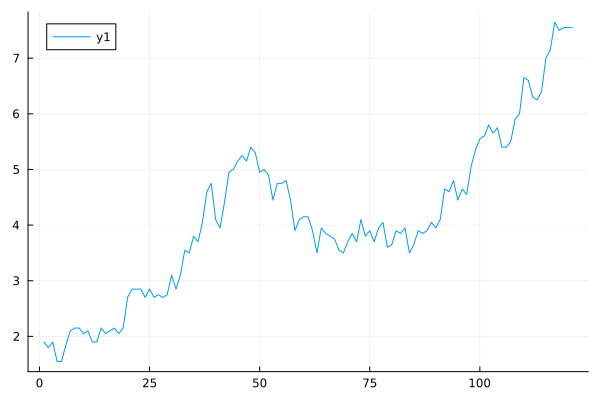

In [30]:
moving_average(opt.model.y, 20) |> plot

In [27]:
maxiterations!(opt, 200)
result = boptimize!(opt)

[ Info: 2023-10-02T13:29:31.760	iteration: 130	current optimum: 13.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:53


[1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 13, 16, 17, 18, 19, 20]
[7521.0, 7995.0, 7977.0, 8019.0, 7181.0, 7606.0, 7652.0, 2258.0, 8070.0, 7299.0, 7547.0, 7101.0, 7562.0, 8452.0, 6887.0, 8085.0, 7961.0, 8398.0, 7945.0, 7400.0]
15


[ Info: 2023-10-02T13:30:25.153	iteration: 131	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:48


[1, 5, 8, 10, 11, 14, 15, 18, 19]
[7835.0, 4289.0, 239.0, 2284.0, 7852.0, 3723.0, 828.0, 7773.0, 1710.0, 8046.0, 7798.0, 1967.0, 1295.0, 8168.0, 8824.0, 6968.0, 210.0, 8174.0, 8111.0, 2929.0]
6


[ Info: 2023-10-02T13:31:14.189	iteration: 132	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:44


[1, 3, 6, 7, 10, 12, 13, 17]
[8510.0, 4273.0, 6245.0, 4592.0, 2641.0, 6873.0, 5862.0, 5991.0, 5223.0, 5825.0, 613.0, 5401.0, 5997.0, 832.0, 4671.0, 706.0, 7950.0, 1211.0, 5709.0, 8348.0]
5

[ Info: 2023-10-02T13:31:59.200	iteration: 133	current optimum: 15.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:52


[2, 5, 6, 7, 9, 11, 12, 13, 14, 15, 17, 19, 20]
[3568.0, 9522.0, 6811.0, 6407.0, 10543.0, 9082.0, 9962.0, 9450.0, 8750.0, 7381.0, 9284.0, 9956.0, 11377.0, 10023.0, 9033.0, 4855.0, 9278.0, 478.0, 9170.0, 10758.0]
6


[ Info: 2023-10-02T13:32:52.249	iteration: 134	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:53


[1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 13, 14, 15, 17, 19]
[6805.0, 7135.0, 7101.0, 6477.0, 7262.0, 6937.0, 7169.0, 4899.0, 6781.0, 6402.0, 7014.0, 1159.0, 6643.0, 6845.0, 6790.0, 3701.0, 7331.0, 3045.0, 6620.0, 2397.0]
11


[ Info: 2023-10-02T13:33:45.740	iteration: 135	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:49


[1, 2, 3, 5, 6, 7, 8, 9, 10, 12, 13, 16, 17, 19, 20]
[10889.0, 10914.0, 11089.0, 648.0, 10721.0, 10371.0, 10580.0, 10547.0, 10766.0, 10702.0, 2197.0, 10852.0, 10235.0, 9906.0, 761.0, 10365.0, 11900.0, 3267.0, 10428.0, 10325.0]
13

[ Info: 2023-10-02T13:34:35.437	iteration: 136	current optimum: 15.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:45


[1, 8, 11, 12, 14, 15, 20]
[14755.0, 639.0, 6177.0, 10832.0, 4326.0, 10387.0, 1536.0, 15033.0, 10665.0, 12629.0, 14499.0, 15365.0, 8102.0, 14078.0, 14333.0, 12057.0, 11623.0, 302.0, 9279.0, 14672.0]
7


[ Info: 2023-10-02T13:35:20.596	iteration: 137	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:48

[1, 2, 3, 4, 5, 6, 8, 10, 13, 14, 15, 16, 18, 19, 20]
[9508.0, 9510.0, 9667.0, 9485.0, 8795.0, 9568.0, 3233.0, 9537.0, 3666.0, 9233.0, 3928.0, 457.0, 9378.0, 9591.0, 9108.0, 8919.0, 6339.0, 9594.0, 9027.0, 9462.0]
14



[ Info: 2023-10-02T13:36:09.514	iteration: 138	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:48


[1, 2, 4, 5, 7, 9, 10, 11, 17, 18, 19, 20]
[6628.0, 6444.0, 817.0, 6540.0, 7087.0, 6773.0, 6532.0, 4541.0, 6459.0, 6685.0, 6501.0, 5613.0, 5548.0, 2208.0, 5593.0, 3551.0, 7165.0, 7758.0, 6576.0, 7064.0]
9

[ Info: 2023-10-02T13:36:58.401	iteration: 139	current optimum: 15.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:43


[1, 3, 6, 9, 12, 13, 14, 15, 16, 17, 19]
[9249.0, 9220.0, 9552.0, 7110.0, 9064.0, 9404.0, 6421.0, 9420.0, 9109.0, 7757.0, 8038.0, 9205.0, 8811.0, 9168.0, 8981.0, 9315.0, 9417.0, 1881.0, 9205.0, 826.0]
7


[ Info: 2023-10-02T13:37:41.877	iteration: 140	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:40

[2, 6, 8, 9, 13, 16, 18]
[5397.0, 11585.0, 6944.0, 4110.0, 7269.0, 11232.0, 8444.0, 11991.0, 12198.0, 9320.0, 2133.0, 8899.0, 11064.0, 3198.0, 3315.0, 11747.0, 5795.0, 11821.0, 4151.0, 5379.0]



[ Info: 2023-10-02T13:38:22.148	iteration: 141	current optimum: 15.0


6


Progress: 100%|█████████████████████████████████████████| Time: 0:00:41


[1, 5, 9, 12, 14, 16, 17]
[14361.0, 2267.0, 5948.0, 253.0, 14243.0, 2042.0, 6827.0, 5575.0, 13867.0, 1377.0, 5203.0, 14835.0, 12171.0, 14108.0, 4876.0, 14281.0, 14550.0, 897.0, 10841.0, 4053.0]
6


[ Info: 2023-10-02T13:39:03.834	iteration: 142	current optimum: 15.0
Progress:  70%|█████████████████████████████            |  ETA: 0:00:18

LoadError: InterruptException:

Progress: 100%|█████████████████████████████████████████| Time: 0:00:44


In [34]:
opt.model_optimizer

6-element Vector{Float64}:
  1.8343240593459835
  0.1299191952663775
  0.2498351325253968
  1.3916557489502095
 -1.7246379679714594
  0.5800080984363274

In [33]:
opt.observed_optimizer

6-element Vector{Float64}:
  3.3321726055466714
  0.14066782220079727
  0.21058048002539118
  1.325692750013504
 -2.0
  0.8982792923210681

In [35]:
maxiterations!(opt, 800)
result = boptimize!(opt)

[ Info: 2023-10-02T13:41:36.601	iteration: 143	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:49


[2, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
[1036.0, 5432.0, 1408.0, 5192.0, 900.0, 5536.0, 5928.0, 5392.0, 5303.0, 5765.0, 5376.0, 5409.0, 5469.0, 5901.0, 5764.0, 5361.0, 5484.0, 5333.0, 5498.0, 5655.0]
4

[ Info: 2023-10-02T13:42:26.257	iteration: 144	current optimum: 15.0


Int64[]
[7183.0, 8763.0, 4367.0, 9974.0, 8208.0, 2137.0, 10935.0, 6183.0, 15856.0, 10791.0, 4920.0, 545.0, 10972.0, 14475.0, 5478.0, 5743.0, 6857.0, 2920.0, 7250.0, 6133.0]
0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:25
[ Info: 2023-10-02T13:42:51.653	iteration: 145	current optimum: 15.0
Progress:  95%|███████████████████████████████████████  |  ETA: 0:00:01

Int64[]
[7070.0, 4089.0, 2567.0, 4979.0, 4121.0, 3073.0, 3166.0, 4591.0, 3623.0, 825.0, 5961.0, 2963.0, 7005.0, 3817.0, 3321.0, 3292.0, 3277.0, 4815.0, 3098.0, 2332.0]
0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:21
[ Info: 2023-10-02T13:43:13.614	iteration: 146	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:45


[1, 4, 5, 7, 10, 12, 13, 14, 15, 19, 20]
[10196.0, 6205.0, 9229.0, 10287.0, 10363.0, 411.0, 10187.0, 6807.0, 7909.0, 10072.0, 8500.0, 10151.0, 10532.0, 10354.0, 10992.0, 6120.0, 1561.0, 6645.0, 10666.0, 10347.0]
8

[ Info: 2023-10-02T13:43:59.043	iteration: 147	current optimum: 15.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:43


[1, 3, 5, 6, 8, 14, 15, 20]
[16858.0, 6825.0, 15798.0, 6004.0, 15732.0, 15262.0, 8286.0, 16036.0, 6156.0, 5801.0, 6499.0, 2296.0, 3517.0, 16568.0, 15702.0, 10241.0, 6103.0, 2358.0, 280.0, 16609.0]
7


[ Info: 2023-10-02T13:44:42.678	iteration: 148	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:48


[1, 2, 3, 4, 8, 9, 10, 11, 12, 15, 18, 19, 20]
[9147.0, 8735.0, 9343.0, 9223.0, 2883.0, 4763.0, 6317.0, 8656.0, 9143.0, 9326.0, 9207.0, 9291.0, 8266.0, 684.0, 9447.0, 1622.0, 2167.0, 9502.0, 9394.0, 9154.0]
5

[ Info: 2023-10-02T13:45:30.961	iteration: 149	current optimum: 15.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:57


[1, 3, 5, 7, 8, 9, 11, 12, 13, 16, 17, 20]
[5365.0, 1406.0, 5032.0, 1315.0, 5780.0, 2387.0, 5426.0, 5553.0, 5597.0, 1355.0, 5375.0, 5195.0, 4683.0, 4488.0, 4009.0, 5644.0, 5756.0, 5199.0, 4062.0, 5432.0]
1


[ Info: 2023-10-02T13:46:28.341	iteration: 150	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:50


[2, 4, 5, 7, 9, 11, 12, 14, 15, 16, 17, 18, 20]
[6222.0, 9287.0, 2915.0, 8873.0, 9240.0, 5864.0, 9090.0, 8309.0, 8919.0, 3052.0, 9343.0, 9172.0, 4060.0, 9015.0, 8482.0, 9148.0, 9636.0, 8595.0, 4582.0, 9525.0]
6

[ Info: 2023-10-02T13:47:19.436	iteration: 151	current optimum: 15.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:49


[4, 5, 8, 9, 11, 17, 18]
[15242.0, 2281.0, 7238.0, 16721.0, 17990.0, 9520.0, 18460.0, 16763.0, 18356.0, 8700.0, 17073.0, 15125.0, 13081.0, 832.0, 6452.0, 5714.0, 18140.0, 18730.0, 6406.0, 1592.0]
7


[ Info: 2023-10-02T13:48:08.706	iteration: 152	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


[13, 16]
[13754.0, 4613.0, 6631.0, 4722.0, 5385.0, 14011.0, 3615.0, 2394.0, 11316.0, 8606.0, 6457.0, 1733.0, 16972.0, 12403.0, 16145.0, 16943.0, 13644.0, 3332.0, 1279.0, 1159.0]
2


[ Info: 2023-10-02T13:48:45.169	iteration: 153	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:52


[1, 2, 5, 7, 11, 12, 13, 14, 16, 17, 18, 19]
[7020.0, 6740.0, 2208.0, 2644.0, 6435.0, 1019.0, 6735.0, 80.0, 1521.0, 4969.0, 6846.0, 6423.0, 6582.0, 6828.0, 3359.0, 6527.0, 6113.0, 6667.0, 6733.0, 1822.0]
6


[ Info: 2023-10-02T13:49:38.258	iteration: 154	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:59


[1, 2, 3, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 18, 19]
[5221.0, 5604.0, 5298.0, 3203.0, 92.0, 5468.0, 5419.0, 5660.0, 5425.0, 5546.0, 5402.0, 5388.0, 5226.0, 2701.0, 5411.0, 5238.0, 526.0, 5470.0, 5790.0, 632.0]
6


[ Info: 2023-10-02T13:50:37.653	iteration: 155	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:45


[2, 4, 6, 8, 9, 10, 11, 13, 17, 19]
[5766.0, 7472.0, 7501.0, 7484.0, 240.0, 7619.0, 725.0, 7552.0, 7254.0, 7296.0, 7449.0, 441.0, 7458.0, 3843.0, 6644.0, 1303.0, 7626.0, 4474.0, 7136.0, 156.0]
1


[ Info: 2023-10-02T13:51:23.719	iteration: 156	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34


[1, 3, 5, 6, 8, 14, 16]
[19001.0, 5946.0, 19043.0, 12522.0, 19949.0, 20490.0, 135.0, 20147.0, 1232.0, 5364.0, 12725.0, 3165.0, 10113.0, 19679.0, 1497.0, 19483.0, 12889.0, 9051.0, 3937.0, 609.0]
7


[ Info: 2023-10-02T13:51:57.898	iteration: 157	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:01:00


[1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 14, 15, 17, 19, 20]
[5305.0, 6131.0, 5195.0, 5388.0, 6404.0, 5431.0, 5468.0, 5907.0, 1589.0, 5384.0, 5449.0, 5598.0, 4522.0, 5639.0, 5156.0, 4353.0, 5937.0, 632.0, 5186.0, 5417.0]
10


[ Info: 2023-10-02T13:52:58.811	iteration: 158	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:48


[4, 5, 6, 9, 11

[ Info: 2023-10-02T13:53:47.818	iteration: 159	current optimum: 15.0


, 12, 15, 17, 19]
[4009.0, 750.0, 6458.0, 10494.0, 10527.0, 11504.0, 661.0, 7817.0, 11322.0, 2326.0, 10995.0, 10805.0, 4381.0, 2600.0, 11172.0, 8797.0, 10462.0, 853.0, 10850.0, 5423.0]
5


Progress: 100%|█████████████████████████████████████████| Time: 0:00:20


Int64[]
[4553.0, 8059.0, 4160.0, 8069.0, 2986.0, 3791.0, 3310.0, 7292.0, 3645.0, 15432.0, 3112.0, 6655.0, 498.0, 9091.0, 9118.0, 10611.0, 7246.0, 6362.0, 2350.0, 3982.0]
0


[ Info: 2023-10-02T13:54:08.768	iteration: 160	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:01:04


[1, 2, 3, 4, 5, 6, 9, 11, 12, 13, 14, 16, 17, 19, 20]
[4811.0, 4561.0, 4790.0, 4744.0, 4884.0, 4811.0, 2198.0, 2188.0, 4698.0, 3862.0, 4464.0, 4534.0, 4735.0, 4456.0, 290.0, 4464.0, 4493.0, 3862.0, 4547.0, 4763.0]
6


[ Info: 2023-10-02T13:55:13.768	iteration: 161	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


[1, 2, 4, 6, 7, 8, 9, 12, 13, 14, 15, 17, 18]
[3983.0, 3848.0, 2876.0, 3622.0, 3675.0, 3637.0, 3745.0, 3709.0, 3824.0, 3100.0, 3121.0, 3780.0, 3861.0, 3743.0, 3923.0, 2795.0, 3850.0, 3569.0, 321.0, 3301.0]
3

[ Info: 2023-10-02T13:56:09.442	iteration: 162	current optimum: 15.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:57


[1, 2, 3, 4, 5, 6, 7, 9, 11, 12, 13, 14, 15, 16, 18, 20]
[7899.0, 7417.0, 7236.0, 7358.0, 7284.0, 7393.0, 7156.0, 1349.0, 7543.0, 5007.0, 7397.0, 7652.0, 7659.0, 7423.0, 7089.0, 7444.0, 4247.0, 7185.0, 1646.0, 7612.0]
10


[ Info: 2023-10-02T13:57:07.423	iteration: 163	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:52


[4, 5, 6, 7, 13, 15, 18]
[404.0, 7340.0, 6180.0, 10640.0, 11045.0, 10982.0, 10880.0, 3337.0, 11044.0, 7837.0, 4767.0, 4121.0, 10566.0, 6155.0, 10889.0, 2644.0, 10418.0, 10767.0, 9433.0, 4770.0]
1


[ Info: 2023-10-02T13:58:00.553	iteration: 164	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:59


[1, 3, 4, 5, 6, 8, 9, 11, 14, 15, 19, 20]
[4238.0, 1285.0, 4007.0, 4278.0, 3966.0, 4112.0, 2970.0, 4244.0, 4266.0, 1018.0, 4235.0, 2926.0, 3314.0, 4377.0, 4088.0, 2694.0, 3061.0, 3969.0, 4265.0, 4262.0]
2

[ Info: 2023-10-02T13:59:00.265	iteration: 165	current optimum: 15.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:45


[1, 4, 5, 6, 8, 9, 11, 13, 14, 15]
[8217.0, 2653.0, 853.0, 7936.0, 8099.0, 8343.0, 4558.0, 8179.0, 8293.0, 3128.0, 8318.0, 3428.0, 8141.0, 8052.0, 8108.0, 7674.0, 3348.0, 1238.0, 7315.0, 3779.0]


[ Info: 2023-10-02T13:59:45.890	iteration: 166	current optimum: 15.0


2


Progress: 100%|█████████████████████████████████████████| Time: 0:00:39


[1, 5, 11, 16]
[3960.0, 3780.0, 510.0, 1332.0, 4083.0, 1988.0, 3557.0, 2680.0, 3375.0, 3168.0, 3848.0, 158.0, 3431.0, 2697.0, 1826.0, 3816.0, 2156.0, 1800.0, 2918.0, 1897.0]
0


[ Info: 2023-10-02T14:00:25.103	iteration: 167	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:01:04

[1, 2, 3, 4, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17

, 18, 20]
[2870.0, 2979.0, 2725.0, 2782.0, 2124.0, 2684.0, 2730.0, 2943.0, 2801.0, 2667.0, 2247.0, 2668.0, 2790.0, 2699.0, 2580.0, 2725.0, 2926.0, 2755.0, 2248.0, 2771.0]
6

[ Info: 2023-10-02T14:01:30.133	iteration: 168	current optimum: 15.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:49


[1, 3, 5, 9, 11, 12, 13]
[7752.0, 1167.0, 7240.0, 3814.0, 8660.0, 991.0, 265.0, 593.0, 8494.0, 4908.0, 7692.0, 8517.0, 7139.0, 6028.0, 3981.0, 8837.0, 3127.0, 7541.0, 1298.0, 6792.0]
2


[ Info: 2023-10-02T14:02:19.324	iteration: 169	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:49


[2, 4, 5, 6, 7, 10, 12, 13, 14, 15, 16, 18, 19]
[5578.0, 6803.0, 6627.0, 6546.0, 6488.0, 6515.0, 6960.0, 429.0, 5665.0, 6925.0, 2792.0, 6814.0, 6731.0, 6776.0, 6900.0, 6679.0, 616.0, 7154.0, 6652.0, 3311.0]
9


[ Info: 2023-10-02T14:03:08.522	iteration: 170	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:40
[ Info: 2023-10-02T14:03:48.824	iteration: 171	current optimum: 15.0


[2, 5, 20]
[5786.0, 10461.0, 2931.0, 4776.0, 10006.0, 6128.0, 4406.0, 2020.0, 440.0, 5660.0, 7138.0, 6386.0, 3732.0, 5857.0, 5463.0, 6539.0, 1473.0, 9999.0, 5381.0, 9257.0]
1


Progress: 100%|█████████████████████████████████████████| Time: 0:00:42
[ Info: 2023-10-02T14:04:31.659	iteration: 172	current optimum: 15.0


[2, 3, 5, 7, 8, 10, 13]
[3693.0, 10747.0, 10358.0, 7785.0, 10562.0, 3557.0, 10710.0, 10511.0, 5812.0, 10542.0, 1659.0, 8254.0, 10565.0, 5358.0, 5327.0, 6884.0, 2767.0, 828.0, 5298.0, 985.0]
4


[1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 14, 16, 19]
[4055.0, 4099.0, 4004.0, 3983.0, 4188.0, 4024.0, 4276.0, 3210.0, 3952.0, 4199.0, 4252.0, 4351.0, 388.0, 4259.0, 3018.0, 4507.0, 2219.0, 3896.0, 4079.0, 3749.0]
3


Progress: 100%|█████████████████████████████████████████| Time: 0:01:03
[ Info: 2023-10-02T14:05:35.582	iteration: 173	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:51


[3, 6, 7, 9, 11, 17, 18, 20]
[3774.0, 7266.0, 9542.0, 5028.0, 8950.0, 9484.0, 9622.0, 7386.0, 9874.0, 2286.0, 9866.0, 5877.0, 7107.0, 9631.0, 4430.0, 5512.0, 10101.0, 9360.0, 1839.0, 10015.0]
5


[ Info: 2023-10-02T14:06:27.160	iteration: 174	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:45


[2, 4, 7, 14, 15, 16, 20]
[3301.0, 11568.0, 4802.0, 12293.0, 1716.0, 5759.0, 13376.0, 5892.0, 13144.0, 5060.0, 11151.0, 3333.0, 3396.0, 12256.0, 13438.0, 12891.0, 4950.0, 13285.0, 7788.0, 9508.0]
1

[ Info: 2023-10-02T14:07:12.806	iteration: 175	current optimum: 15.0


[1, 3, 4, 5, 7, 9, 10, 11, 12, 13, 15, 16, 18, 19]
[3998.0, 2012.0, 4306.0, 4027.0, 4343.0, 2013.0, 4107.0, 375.0, 4034.0, 4078.0, 4305.0, 4379.0, 3993.0, 59.0, 4185.0, 4191.0, 744.0, 4052.0, 4011.0, 3350.0]
2


Progress: 100%|█████████████████████████████████████████| Time: 0:00:57
[ Info: 2023-10-02T14:08:10.011	iteration: 176	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:42


[3, 4, 9, 11, 15, 19]
[3032.0, 3623.0, 9305.0, 9707.0, 764.0, 9513.0, 8906.0, 2993.0, 9328.0, 3590.0, 8940.0, 334.0, 6696.0, 7617.0, 9711.0, 4553.0, 2422.0, 7109.0, 9175.0, 3072.0]
4

[ Info: 2023-10-02T14:08:52.926	iteration: 177	current optimum: 15.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:49


[5, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
[2288.0, 2902.0, 1835.0, 5881.0, 10937.0, 4621.0, 11006.0, 10726.0, 7980.0, 10644.0, 11085.0, 11193.0, 10747.0, 10850.0, 10590.0, 11000.0, 10736.0, 10998.0, 10872.0, 3072.0]
10


[ Info: 2023-10-02T14:09:42.744	iteration: 178	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:51


[3, 5, 6, 7, 8, 10, 11, 16, 18]
[4322.0, 5307.0, 12797.0, 6655.0, 12934.0, 12491.0, 12737.0, 13543.0, 10185.0, 12435.0, 12020.0, 111.0, 40.0, 9868.0, 751.0, 12765.0, 7892.0, 12221.0, 10604.0, 1826.0]
5


[ Info: 2023-10-02T14:10:34.671	iteration: 179	current optimum: 15.0


[1, 2, 3, 4, 5, 6, 7, 8, 9, 12, 14, 16, 17, 18, 19]
[8919.0, 8705.0, 8727.0, 8762.0, 8919.0, 8235.0, 8362.0, 8752.0, 8981.0, 2948.0, 4725.0, 9246.0, 7993.0, 9191.0, 512.0, 8113.0, 9172.0, 8757.0, 8456.0, 3511.0]
2


Progress: 100%|█████████████████████████████████████████| Time: 0:01:02
[ Info: 2023-10-02T14:11:36.988	iteration: 180	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:40

[6, 10]
[1803.0, 29797.0, 2566.0, 9696.0, 12476.0, 32921.0, 20872.0, 30578.0, 17596.0, 32178.0, 19038.0, 4989.0, 26083.0, 12665.0, 8870.0, 25154.0, 20113.0, 19718.0, 22890.0, 6922.0]
1


[ Info: 2023-10-02T14:12:17.749	iteration: 181	current optimum: 15.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


[2, 3, 4, 7, 9, 16, 18, 20]
[5840.0, 8658.0, 8877.0, 7967.0, 3845.0, 3769.0, 7990.0, 4373.0, 8792.0, 5280.0, 5242.0, 7114.0, 2462.0, 5439.0, 2379.0, 8471.0, 4956.0, 8493.0, 1423.0, 8193.0]
1


[ Info: 2023-10-02T14:13:05.567	iteration: 182	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:49


[1, 2, 3, 8, 9, 11, 12, 13, 15, 16, 17, 18, 20]
[7718.0, 8051.0, 7773.0, 2705.0, 5172.0, 1817.0, 332.0, 7664.0, 7536.0, 6891.0, 8064.0, 7745.0, 7354.0, 2290.0, 7600.0, 8083.0, 7343.0, 7304.0, 2693.0, 7794.0]
11


[ Info: 2023-10-02T14:13:55.025	iteration: 183	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


[1, 2, 3, 4, 5, 7, 9, 10, 11, 12, 14, 16, 18, 19]
[7619.0, 7535.0, 7635.0, 7479.0, 7517.0, 790.0, 7990.0, 4012.0, 7800.0, 7678.0, 7580.0, 7544.0, 6464.0, 7796.0, 6482.0, 7441.0, 2363.0, 7484.0, 7922.0, 3581.0]
7

[ Info: 2023-10-02T14:14:50.625	iteration: 184	current optimum: 15.0


Progress: 100%|█████████████████████████████████████████| Time: 0:01:27

[2, 5, 6, 7, 10, 12, 13, 15, 17, 19, 20]
[6295.0, 6002.0, 2636.0, 4203.0, 6389.0, 6077.0, 6262.0, 1995.0, 1090.0, 6629.0, 2850.0, 6215.0, 6330.0, 5324.0, 6021.0, 1759.0, 6028.0, 1148.0, 6054.0, 6063.0]
3



[ Info: 2023-10-02T14:16:17.856	iteration: 185	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:01:04


[1, 4, 5, 10, 14, 15, 16, 20]
[7532.0, 1851.0, 671.0, 7215.0, 7253.0, 3949.0, 77.0, 4953.0, 2274.0, 6785.0, 6472.0, 1464.0, 1435.0, 7239.0, 8419.0, 7214.0, 3300.0, 942.0, 6500.0, 7399.0]
6

[ Info: 2023-10-02T14:17:21.993	iteration: 186	current optimum: 15.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:51


[3, 4, 5, 6, 8, 9, 11, 15, 16, 17, 19, 20]
[1389.0, 520.0, 5339.0, 5241.0, 5027.0, 5034.0, 1665.0, 5021.0, 5042.0, 3587.0, 4992.0, 4597.0, 4869.0, 3560.0, 5060.0, 5108.0, 4962.0, 2354.0, 5168.0, 5269.0]
1

[ Info: 2023-10-02T14:18:14.103	iteration: 187	current optimum: 15.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:45

[3, 5, 8, 10, 14, 16, 18]
[7398.0, 3840.0, 13408.0, 1169.0, 13192.0, 3905.0, 8983.0,


[ Info: 2023-10-02T14:18:59.206	iteration: 188	current optimum: 15.0


 13208.0, 9967.0, 13856.0, 2362.0, 5601.0, 4564.0, 12826.0, 12565.0, 14071.0, 8930.0, 12949.0, 1907.0, 6803.0]
4


Progress: 100%|█████████████████████████████████████████| Time: 0:00:58


[2, 4, 7, 8, 10, 11, 12, 13, 15, 17, 18, 19, 20]
[139.0, 5628.0, 1400.0, 4952.0, 2817.0, 2649.0, 5222.0, 5259.0, 4139.0, 5621.0, 5199.0, 5584.0, 4877.0, 655.0, 4980.0, 3202.0, 5407.0, 4919.0, 5115.0, 5010.0]
3


[ Info: 2023-10-02T14:19:58.130	iteration: 189	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


[3, 5, 7, 8, 9, 10, 11, 14, 16, 17, 19]
[1853.0, 3831.0, 6702.0, 6098.0, 6877.0, 1855.0, 6675.0, 6946.0, 6603.0, 7572.0, 6877.0, 3131.0, 7227.0, 6506.0, 4953.0, 6977.0, 7115.0, 4963.0, 6862.0, 2045.0]
6

[ Info: 2023-10-02T14:20:53.877	iteration: 190	current optimum: 15.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:45


[2, 3, 5, 6, 7, 9, 11, 14, 15, 18, 19]
[9079.0, 11848.0, 12023.0, 2140.0, 12590.0, 11847.0, 11865.0, 2356.0, 12752.0, 898.0, 12080.0, 2896.0, 3664.0, 12038.0, 12344.0, 7181.0, 2009.0, 11853.0, 11763.0, 11561.0]
3


[ Info: 2023-10-02T14:21:39.302	iteration: 191	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:52


[4, 6, 11, 12, 13, 14, 16, 17, 20]
[1599.0, 1894.0, 8261.0, 9705.0, 3895.0, 9278.0, 8264.0, 1145.0, 1730.0, 2185.0, 9621.0, 9592.0, 8899.0, 8947.0, 2506.0, 10279.0, 8810.0, 6936.0, 4063.0, 9927.0]
5


[ Info: 2023-10-02T14:22:31.497	iteration: 192	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:50


[3, 5, 16]
[11851.0, 14672.0, 17951.0, 10089.0, 17138.0, 6529.0, 4066.0, 35.0, 11707.0, 2746.0, 5558.0, 1994.0, 2420.0, 4541.0, 10501.0, 16382.0, 4173.0, 4331.0, 2969.0, 7239.0]
0


[ Info: 2023-10-02T14:23:21.836	iteration: 193	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:01:08


[1, 2, 5, 6, 10, 14, 15, 16, 17, 18, 19]
[16296.0, 15908.0, 1945.0, 211.0, 15825.0, 15074.0, 545.0, 6203.0, 11013.0, 14342.0, 7677.0, 13717.0, 14847.0, 16947.0, 14576.0, 16348.0, 15642.0, 15622.0, 16389.0, 539.0]
3


[ Info: 2023-10-02T14:24:30.717	iteration: 194	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


[2, 4, 6, 7, 8, 9, 10, 11, 12, 13, 18]
[288.0, 5446.0, 1812.0, 5475.0, 5609.0, 5515.0, 5672.0, 5902.0, 5605.0, 5490.0, 5433.0, 5524.0, 5621.0, 1056.0, 4274.0, 5467.0, 2003.0, 5628.0, 1294.0, 1448.0]
11

[ Info: 2023-10-02T14:25:27.135	iteration: 195	current optimum: 15.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:46


[1, 6, 7, 10, 11, 12, 13, 15, 18, 20]
[8259.0, 2983.0, 974.0, 1692.0, 1545.0, 7349.0, 7456.0, 6390.0, 703.0, 7615.0, 7964.0, 7438.0, 7471.0, 3321.0, 7721.0, 334.0, 511.0, 7306.0, 2685.0, 8307.0]
5


[ Info: 2023-10-02T14:26:14.050	iteration: 196	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:01:13


[3, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15, 16, 17, 19, 20]
[1097.0, 3184.0, 7608.0, 3262.0, 7729.0, 7658.0, 7898.0, 8019.0, 7782.0, 3785.0, 7812.0, 8179.0, 8290.0, 7807.0, 7783.0, 8039.0, 7745.0, 1935.0, 7686.0, 8091.0]
7


[ Info: 2023-10-02T14:27:27.507	iteration: 197	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:53


[2, 4, 5, 18, 20]
[18713.0, 26443.0, 17809.0, 26417.0, 25712.0, 19025.0, 2661.0, 16321.0, 4623.0, 3834.0, 9614.0, 1757.0, 8342.0, 12430.0, 11034.0, 9963.0, 1054.0, 26711.0, 3618.0, 25756.0]
5


[ Info: 2023-10-02T14:28:21.104	iteration: 198	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:57


[5, 6, 7, 8, 10, 11, 13, 15, 16, 17, 19, 20]
[6208.0, 3311.0, 8621.0, 7970.0, 9694.0, 9313.0, 9895.0, 9842.0, 2793.0, 9004.0, 9645.0, 1318.0, 9809.0, 4704.0, 9874.0, 10022.0, 9424.0, 8381.0, 9739.0, 9799.0]


[ Info: 2023-10-02T14:29:18.812	iteration: 199	current optimum: 15.0


10


Progress: 100%|█████████████████████████████████████████| Time: 0:00:53


[5, 8, 9, 11, 15, 17, 18]
[1324.0, 7412.0, 1500.0, 4842.0, 8893.0, 6708.0, 1187.0, 8594.0, 9431.0, 1399.0, 8785.0, 3480.0, 5510.0, 5024.0, 8837.0, 4924.0, 9073.0, 9271.0, 8591.0, 2839.0]
2

[ Info: 2023-10-02T14:30:12.891	iteration: 200	current optimum: 15.0


Progress: 100%|█████████████████████████████████████████| Time: 0:01:23


[2, 4, 5, 6, 8, 9, 10, 11, 13, 14, 16, 18, 19, 20]
[6515.0, 8692.0, 1970.0, 8481.0, 9251.0, 9050.0, 3308.0, 8737.0, 9126.0, 8970.0, 8688.0, 8454.0, 8540.0, 8710.0, 1672.0, 8736.0, 1628.0, 9125.0, 8174.0, 9011.0]
7

[ Info: 2023-10-02T14:31:36.623	iteration: 201	current optimum: 15.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:44


[5, 8, 12, 15, 19]
[1445.0, 5228.0, 3284.0, 9470.0, 20626.0, 9025.0, 9223.0, 20222.0, 3920.0, 7026.0, 18340.0, 18141.0, 526.0, 7978.0, 19936.0, 12650.0, 1249.0, 5529.0, 17714.0, 6784.0]
2


[ Info: 2023-10-02T14:32:21.697	iteration: 202	current optimum: 15.0
Progress:  95%|███████████████████████████████████████  |  ETA: 0:00:03

[2, 5, 6, 8, 9, 10, 12, 14, 15, 18, 19, 20]
[717.0, 6167.0, 3834.0, 5283.0, 6101.0, 6345.0, 3028.0, 6116.0, 6038.0, 6220.0, 1703.0, 6276.0, 3889.0, 6338.0, 6257.0, 255.0, 1783.0, 6073.0, 6099.0, 6249.0]
4


Progress: 100%|█████████████████████████████████████████| Time: 0:00:57
[ Info: 2023-10-02T14:33:19.090	iteration: 203	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:01:14


[1, 2, 3, 4, 5, 8, 9, 10, 11, 12, 14, 16, 17, 18, 19, 20]
[5952.0, 5918.0, 5336.0, 5535.0, 6032.0, 1076.0, 2565.0, 5613.0, 5662.0, 5300.0, 5732.0, 5619.0, 4254.0, 5788.0, 149.0, 5813.0, 5655.0, 5701.0, 5683.0, 5503.0]
7


[ Info: 2023-10-02T14:34:33.903	iteration: 204	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:52


[1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 17, 18

[ Info: 2023-10-02T14:35:26.819	iteration: 205	current optimum: 15.0


, 19]
[4516.0, 4988.0, 4574.0, 4617.0, 3250.0, 4675.0, 4501.0, 5021.0, 4715.0, 4758.0, 4904.0, 4538.0, 4661.0, 4736.0, 171.0, 4177.0, 4580.0, 4855.0, 4552.0, 3870.0]
2


Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


[3, 4, 5, 6, 7, 9, 13, 14, 15, 16, 17, 18, 20]
[3349.0, 5486.0, 9858.0, 9395.0, 10197.0, 9225.0, 10862.0, 2907.0, 9257.0, 1389.0, 282.0, 834.0, 9215.0, 9122.0, 9400.0, 9336.0, 9719.0, 9712.0, 55.0, 10087.0]
4


[ Info: 2023-10-02T14:36:21.761	iteration: 206	current optimum: 15.0


[1, 2, 6, 8, 9, 10, 11, 13, 15, 16, 19]
[12312.0, 11081.0, 3505.0, 1888.0, 8845.0, 11378.0, 1748.0, 10995.0, 11097.0, 11069.0, 10885.0, 10885.0, 11312.0, 10775.0, 10681.0, 11284.0, 3237.0, 5634.0, 11885.0, 4868.0]
9

Progress: 100%|█████████████████████████████████████████| Time: 0:01:10
[ Info: 2023-10-02T14:37:32.306	iteration: 207	current optimum: 15.0


Progress: 100%|█████████████████████████████████████████| Time: 0:01:15

[1, 2, 4, 7, 8, 10, 11, 14, 15, 19, 20]
[8895.0, 8158.0, 3962.0, 8318.0, 5476.0, 6004.0, 8393.0, 9323.0, 5689.0, 8546.0, 8633.0, 2362.0, 5584.0, 8484.0, 8080.0, 9299.0, 3476.0, 6684.0, 8905.0, 9301.0]
7



[ Info: 2023-10-02T14:38:47.946	iteration: 208	current optimum: 15.0


[1, 2, 4, 6, 8, 9, 12, 16, 17, 18]
[15680.0, 14209.0, 7353.0, 14930.0, 8343.0, 14328.0, 3016.0, 14226.0, 14209.0, 13650.0, 6512.0, 14563.0, 1049.0, 9783.0, 5456.0, 14798.0, 14214.0, 14717.0, 102.0, 10215.0]
9

Progress: 100%|█████████████████████████████████████████| Time: 0:00:46
[ Info: 2023-10-02T14:39:34.323	iteration: 209	current optimum: 15.0


Progress: 100%|█████████████████████████████████████████| Time: 0:01:14


[1, 3, 4, 5, 6, 7, 8, 11, 13, 14, 15, 16, 17, 19, 20]
[7254.0, 5449.0, 6475.0, 6403.0, 6505.0, 6312.0, 6155.0, 6880.0, 3319.0, 1005.0, 6235.0, 2909.0, 6669.0, 6082.0, 6640.0, 6876.0, 6425.0, 3121.0, 6187.0, 7000.0]
3


[ Info: 2023-10-02T14:40:48.746	iteration: 210	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:01:08


[6, 14, 17, 19, 20]
[393.0, 1648.0, 9611.0, 1782.0, 5199.0, 12403.0, 5971.0, 2081.0, 42.0, 5416.0, 3333.0, 1226.0, 6232.0, 12639.0, 10506.0, 4029.0, 12010.0, 9096.0, 13075.0, 12439.0]
5

[ Info: 2023-10-02T14:41:57.248	iteration: 211	current optimum: 15.0


Progress: 100%|█████████████████████████████████████████| Time: 0:01:14


[2, 3, 4, 7, 10, 11, 15]
[9910.0, 14398.0, 16593.0, 14843.0, 13682.0, 12767.0, 15025.0, 15498.0, 209.0, 14175.0, 15115.0, 1423.0, 5329.0, 621.0, 14724.0, 685.0, 2569.0, 7615.0, 4495.0, 7904.0]
2


[ Info: 2023-10-02T14:43:11.617	iteration: 212	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:01:05


[3, 5, 7, 8, 9, 11, 12, 13, 14, 15, 18, 19]
[8210.0, 3743.0, 9268.0, 3648.0, 8967.0, 10818.0, 12329.0, 8806.0, 9676.0, 6376.0, 11105.0, 12612.0, 10838.0, 9270.0, 9703.0, 5730.0, 7644.0, 9143.0, 9053.0, 3741.0]
8


[ Info: 2023-10-02T14:44:17.618	iteration: 213	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


Int64[]
[3759.0, 3800.0, 3341.0, 2243.0, 2198.0, 2283.0, 2347.0, 2571.0, 2372.0, 666.0, 2759.0, 3554.0, 4185.0, 2982.0, 4869.0, 4391.0, 957.0, 3472.0, 3406.0, 579.0]
0

[ Info: 2023-10-02T14:44:25.629	iteration: 214	current optimum: 15.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:56

[3, 6, 9, 10, 11, 13, 14, 15, 18, 19]
[1307.0, 1552.0, 7913.0, 3441.0, 6018.0, 8188.0, 6710.0, 8038.0, 8082.0, 8036.0, 8338.0, 2945.0, 8309.0, 8617.0, 8694.0, 852.0, 6893.0, 8110.0, 8247.0, 6580.0]
2



[ Info: 2023-10-02T14:45:22	iteration: 215	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:38


[2, 3, 13, 14]
[12810.0, 19838.0, 21036.0, 15207.0, 3434.0, 3777.0, 8688.0, 3948.0, 7791.0, 11334.0, 1725.0, 220.0, 19866.0, 19899.0, 826.0, 5613.0, 6636.0, 14162.0, 1700.0, 7638.0]
0

[ Info: 2023-10-02T14:46:00.212	iteration: 216	current optimum: 15.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:48


[1, 3, 5, 6, 7, 9, 10, 15, 16, 17, 18, 19, 20]
[14152.0, 126.0, 13594.0, 8596.0, 13781.0, 14080.0, 13451.0, 3402.0, 13615.0, 14104.0, 12840.0, 3031.0, 1277.0, 4849.0, 13568.0, 14195.0, 14216.0, 12775.0, 14439.0, 14035.0]
3

[ Info: 2023-10-02T14:46:49.101	iteration: 217	current optimum: 15.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:53


[1, 3, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19]
[7313.0, 1764.0, 6775.0, 5393.0, 2974.0, 6839.0, 6775.0, 6892.0, 8093.0, 7210.0, 66.0, 6954.0, 7266.0, 7290.0, 6929.0, 7121.0, 7111.0, 7464.0, 6785.0, 2236.0]
9


[ Info: 2023-10-02T14:47:42.857	iteration: 218	current optimum: 15.0


[1, 2, 4, 5, 8, 9, 10, 13, 14, 16, 17, 18, 20]
[4642.0, 4689.0, 3012.0, 4972.0, 4869.0, 4252.0, 4039.0, 4824.0, 4976.0, 4829.0, 3578.0, 3029.0, 4686.0, 4747.0, 4138.0, 4829.0, 5080.0, 4965.0, 2490.0, 4717.0]
0

Progress: 100%|█████████████████████████████████████████| Time: 0:00:51


[ Info: 2023-10-02T14:48:34.165	iteration: 219	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:52


[2, 3, 4, 5, 6, 7, 10, 16, 17, 20]
[4945.0, 8200.0, 8061.0, 8260.0, 7967.0, 8640.0, 8317.0, 6116.0, 5346.0, 8112.0, 4481.0, 3421.0, 3862.0, 1368.0, 7561.0, 8289.0, 8030.0, 5953.0, 1415.0, 7939.0]
8

[ Info: 2023-10-02T14:49:27.071	iteration: 220	current optimum: 15.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:50


[1, 2, 5, 7, 8, 9, 10, 11, 14, 16, 17, 18, 20]
[7458.0, 7802.0, 4711.0, 2596.0, 7457.0, 2164.0, 7737.0, 7425.0, 7507.0, 7372.0, 7348.0, 513.0, 5577.0, 7635.0, 6697.0, 7674.0, 7605.0, 7773.0, 3595.0, 7738.0]
4


[ Info: 2023-10-02T14:50:18.027	iteration: 221	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:42


[6, 7, 8, 15, 16, 18, 20]
[5978.0, 2003.0, 1742.0, 10204.0, 1602.0, 14701.0, 15104.0, 14189.0, 11457.0, 9067.0, 383.0, 4521.0, 11257.0, 7084.0, 15682.0, 14190.0, 5488.0, 15246.0, 11798.0, 14469.0]
5


[ Info: 2023-10-02T14:51:00.582	iteration: 222	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:01:16


[1, 2, 3, 4, 6, 8, 10, 11, 12, 13, 14, 20]
[3257.0, 3185.0, 2965.0, 3005.0, 2872.0, 3137.0, 1212.0, 2909.0, 1178.0, 2951.0, 2849.0, 2940.0, 3073.0, 2783.0, 1807.0, 417.0, 1041.0, 788.0, 2312.0, 3020.0]
1


[ Info: 2023-10-02T14:52:17.051	iteration: 223	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:01:16


[1, 2, 3, 4, 6, 7, 9, 11, 13, 14, 16, 17, 18, 19, 20]
[6618.0, 6753.0, 6462.0, 6945.0, 917.0, 6627.0, 6878.0, 4131.0, 7391.0, 617.0, 6635.0, 3392.0, 6825.0, 6461.0, 1785.0, 6657.0, 6644.0, 6664.0, 6658.0, 7211.0]
4


[ Info: 2023-10-02T14:53:34.054	iteration: 224	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:01:14


[1, 2, 3, 4, 8, 9, 10, 13, 14, 15, 18]
[3981.0, 4141.0, 4304.0, 3889.0, 3076.0, 1318.0, 1014.0, 4152.0, 3900.0, 4052.0, 1077.0, 2771.0, 4188.0, 3970.0, 4516.0, 3186.0, 1771.0, 3809.0, 2888.0, 3362.0]
0


[ Info: 2023-10-02T14:54:48.467	iteration: 225	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:01:14


[1, 3, 4, 5, 6, 7, 11, 12, 13, 15, 16, 17, 19]
[6050.0, 2473.0, 5945.0, 6647.0, 6088.0, 6102.0, 5991.0, 3220.0, 2444.0, 252.0, 6149.0, 6569.0, 6137.0, 2285.0, 6660.0, 6211.0, 6741.0, 2412.0, 6449.0, 1846.0]
4


[ Info: 2023-10-02T14:56:03.098	iteration: 226	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:45


[1, 3, 6, 10, 12, 14, 15, 17, 18, 19, 20]
[114.0, 69.0, 118.0, 117.0, 97.0, 121.0, 82.0, 64.0, 81.0, 106.0, 97.0, 127.0, 77.0, 104.0, 113.0, 83.0, 120.0, 111.0, 102.0, 122.0]
0

[ Info: 2023-10-02T14:56:48.372	iteration: 227	current optimum: 15.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


[1, 2, 3, 4, 5, 7, 8, 11, 12, 14, 15, 17, 18, 19, 20]
[6182.0, 6568.0, 6426.0, 6462.0, 6516.0, 3234.0, 6614.0, 6441.0, 1717.0, 3315.0, 6453.0, 6504.0, 1307.0, 6251.0, 6646.0, 5899.0, 6164.0, 6055.0, 6075.0, 6499.0]
6

[ Info: 2023-10-02T14:57:45.357	iteration: 228	current optimum: 15.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:48


[1, 3, 5, 6, 7, 9, 11, 12, 13, 17, 20]
[7064.0, 1264.0, 7094.0, 6621.0, 6950.0, 6846.0, 6899.0, 4083.0, 6959.0, 3490.0, 6933.0, 7086.0, 6830.0, 1121.0, 492.0, 6724.0, 7202.0, 4922.0, 5150.0, 6667.0]
5


[ Info: 2023-10-02T14:58:34.096	iteration: 229	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:49


[3, 4, 5, 7, 8, 9, 11, 13, 14, 15, 17, 18]
[6153.0, 5588.0, 7006.0, 6914.0, 7143.0, 34.0, 6827.0, 6639.0, 6804.0, 1200.0, 6691.0, 3692.0, 6841.0, 7008.0, 7064.0, 2677.0, 6434.0, 7096.0, 6085.0, 6286.0]


[ Info: 2023-10-02T14:59:24.181	iteration: 230	current optimum: 15.0


5


Progress: 100%|█████████████████████████████████████████| Time: 0:00:23


Int64[]
[2853.0, 2284.0, 3346.0, 3307.0, 4116.0, 1990.0, 1789.0, 7931.0, 3253.0, 2618.0, 8136.0, 3357.0, 4969.0, 3990.0, 3205.0, 8443.0, 4285.0, 3237.0, 3676.0, 3084.0]


[ Info: 2023-10-02T14:59:47.988	iteration: 231	current optimum: 15.0


0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:53


[1, 2, 3, 4, 5, 7, 8, 10, 13, 15, 16, 17, 20]
[5265.0, 6100.0, 6594.0, 5228.0, 5491.0, 3003.0, 5526.0, 6291.0, 2413.0, 5228.0, 2270.0, 815.0, 5955.0, 1092.0, 5419.0, 5372.0, 5966.0, 8648.0, 1271.0, 5355.0]
6


[ Info: 2023-10-02T15:00:41.554	iteration: 232	current optimum: 15.0


[2, 12, 15, 16, 20]
[5672.0, 13763.0, 3959.0, 15323.0, 7202.0, 10393.0, 11670.0, 937.0, 4568.0, 3529.0, 5275.0, 16784.0, 14344.0, 9993.0, 18313.0, 16772.0, 11294.0, 16449.0, 13764.0, 17778.0]
2


Progress: 100%|█████████████████████████████████████████| Time: 0:00:43
[ Info: 2023-10-02T15:01:25.621	iteration: 233	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:58


[1, 6, 7, 11, 14, 15, 17, 19]
[5043.0, 273.0, 2333.0, 1067.0, 795.0, 4891.0, 4844.0, 2975.0, 2775.0, 3166.0, 4453.0, 1252.0, 3043.0, 4767.0, 4626.0, 4153.0, 4730.0, 2082.0, 4992.0, 4027.0]
0

[ Info: 2023-10-02T15:02:24.303	iteration: 234	current optimum: 15.0


Progress: 100%|█████████████████████████████████████████| Time: 0:01:05


[1, 2, 3, 4, 5, 7, 8, 10, 12, 13, 15, 16, 17, 18, 19]
[3584.0, 3451.0, 3594.0, 3487.0, 3431.0, 3263.0, 3511.0, 3523.0, 1286.0, 3642.0, 2573.0, 3502.0, 3564.0, 2105.0, 3456.0, 3313.0, 3588.0, 3320.0, 3724.0, 586.0]
2

[ Info: 2023-10-02T15:03:29.873	iteration: 235	current optimum: 15.0


Progress: 100%|█████████████████████████████████████████| Time: 0:01:37


[2, 3, 4, 5, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20]
[760.0, 1861.0, 1671.0, 1609.0, 1936.0, 1520.0, 1610.0, 1647.0, 1682.0, 1621.0, 1620.0, 742.0, 1518.0, 1672.0, 1705.0, 1651.0, 1514.0, 1973.0, 1846.0, 1781.0]


[ Info: 2023-10-02T15:05:07.970	iteration: 236	current optimum: 15.0


2


Progress:  75%|███████████████████████████████          |  ETA: 0:00:20

LoadError: InterruptException:

Progress: 100%|█████████████████████████████████████████| Time: 0:01:04


In [36]:
opt.model_optimizer

6-element Vector{Float64}:
  1.8343240593459835
  0.1299191952663775
  0.2498351325253968
  1.3916557489502095
 -1.7246379679714594
  0.5800080984363274

In [37]:
opt.observed_optimizer

6-element Vector{Float64}:
  3.3321726055466714
  0.14066782220079727
  0.21058048002539118
  1.325692750013504
 -2.0
  0.8982792923210681

In [42]:
opt.func = f

f (generic function with 1 method)

In [43]:
methods(f)

# 1 method for generic function "f" from Main:
 [1] f(x)
     @ In[38]:16

In [ ]:
maxiterations!(opt, 800)
result = boptimize!(opt)

[ Info: 2023-10-02T15:08:13.378	iteration: 237	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:43


[3, 6, 7, 9, 11, 12, 18]
[3058.0, 1852.0, 19292.0, 5609.0, 3398.0, 9842.0, 15712.0, 6181.0, 12474.0, 10948.0, 11443.0, 13050.0, 1272.0, 13702.0, 11274.0, 9216.0, 3596.0, 11343.0, 3394.0, 6337.0]
1


[ Info: 2023-10-02T15:08:56.907	iteration: 238	current optimum: 15.0


[1, 3, 4, 5, 6, 7, 9, 11, 13, 16, 17, 18, 19]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
0

Progress: 100%|█████████████████████████████████████████| Time: 0:00:52
[ Info: 2023-10-02T15:09:49.382	iteration: 239	current optimum: 15.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


[6, 8, 15, 19]
[6699.0, 1918.0, 7092.0, 2703.0, 3004.0, 16638.0, 8644.0, 16661.0, 3422.0, 13103.0, 2892.0, 3939.0, 7894.0, 1596.0, 16880.0, 2325.0, 7517.0, 3166.0, 17705.0, 10773.0]
2


[ Info: 2023-10-02T15:10:45.917	iteration: 240	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:48


[3, 6, 10, 14, 18]
[585.0, 637.0, 767.0, 678.0, 724.0, 916.0, 817.0, 742.0, 557.0, 881.0, 752.0, 562.0, 636.0, 991.0, 523.0, 571.0, 667.0, 876.0, 512.0, 380.0]
0


[ Info: 2023-10-02T15:11:34.886	iteration: 241	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:38


[1, 6, 8, 9, 12, 13, 14]
[1041.0, 562.0, 591.0, 681.0, 884.0, 1003.0, 418.0, 959.0, 972.0, 543.0, 621.0, 909.0, 1052.0, 986.0, 682.0, 887.0, 607.0, 545.0, 777.0, 547.0]
0

[ Info: 2023-10-02T15:12:13.882	iteration: 242	current optimum: 15.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:49


[4, 10, 11, 13, 18]
[444.0, 42.0, 581.0, 717.0, 420.0, 465.0, 397.0, 729.0, 402.0, 708.0, 616.0, 623.0, 795.0, 654.0, 440.0, 477.0, 375.0, 741.0, 160.0, 544.0]
0


[ Info: 2023-10-02T15:13:03.099	iteration: 243	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:43


[6, 12, 13, 16, 18, 20]
[5038.0, 1893.0, 4687.0, 2753.0, 3023.0, 14027.0, 3004.0, 3147.0, 3544.0, 610.0, 12081.0, 13339.0, 13563.0, 11361.0, 1648.0, 14643.0, 9388.0, 14278.0, 6067.0, 13901.0]
5

[ Info: 2023-10-02T15:13:46.975	iteration: 244	current optimum: 15.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:40


[5, 6, 7, 9, 15]
[645.0, 271.0, 708.0, 407.0, 968.0, 1010.0, 1002.0, 424.0, 1016.0, 547.0, 947.0, 1013.0, 863.0, 972.0, 994.0, 619.0, 535.0, 767.0, 682.0, 861.0]


[ Info: 2023-10-02T15:14:28.020	iteration: 245	current optimum: 15.0


0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:58


[1, 2, 3, 5, 6, 7, 9, 10, 11, 13, 16, 19, 20]
[3948.0, 4770.0, 6010.0, 218.0, 5346.0, 4674.0, 3610.0, 1068.0, 4656.0, 3628.0, 3474.0, 1566.0, 3477.0, 3649.0, 3565.0, 3982.0, 5524.0, 4777.0, 4264.0, 4039.0]
5

[ Info: 2023-10-02T15:15:26.637	iteration: 246	current optimum: 15.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


[5, 8]
[261.0, 273.0, 595.0, 720.0, 699.0, 439.0, 672.0, 731.0, 649.0, 414.0, 660.0, 243.0, 444.0, 769.0, 608.0, 573.0, 604.0, 317.0, 501.0, 552.0]
0


[ Info: 2023-10-02T15:16:14.186	iteration: 247	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:01:01


[2, 4, 7, 9, 11, 12, 14, 15, 16, 17, 18, 19]
[3556.0, 5008.0, 2278.0, 4908.0, 601.0, 2926.0, 4419.0, 804.0, 4880.0, 2451.0, 4988.0, 5133.0, 4146.0, 4955.0, 4690.0, 4805.0, 4533.0, 4646.0, 4687.0, 549.0]
4

[ Info: 2023-10-02T15:17:15.564	iteration: 248	current optimum: 15.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:42


[1, 10, 15, 18, 20]
[18445.0, 8451.0, 9674.0, 3592.0, 8754.0, 11991.0, 6151.0, 16900.0, 4461.0, 17484.0, 2274.0, 963.0, 6929.0, 3680.0, 16997.0, 11147.0, 6805.0, 16466.0, 9133.0, 18945.0]
1

[ Info: 2023-10-02T15:17:57.864	iteration: 249	current optimum: 15.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:42


[1, 3, 10, 17]
[1847.0, 961.0, 1837.0, 1233.0, 1243.0, 1482.0, 941.0, 1382.0, 140.0, 2038.0, 1574.0, 750.0, 1030.0, 788.0, 1417.0, 1355.0, 2002.0, 1039.0, 1241.0, 261.0]
0


[ Info: 2023-10-02T15:18:41.049	iteration: 250	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:45


[3, 4, 5, 11, 13, 17]
[9586.0, 17060.0, 20553.0, 21159.0, 19983.0, 8415.0, 1271.0, 5987.0, 3275.0, 4420.0, 20832.0, 11233.0, 20158.0, 3513.0, 19592.0, 6317.0, 20478.0, 9418.0, 2005.0, 20953.0]
6


[ Info: 2023-10-02T15:19:26.737	iteration: 251	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:23


Int64[]
[2971.0, 2126.0, 4111.0, 2553.0, 2405.0, 4365.0, 3627.0, 7514.0, 3210.0, 5176.0, 3805.0, 4110.0, 3622.0, 4355.0, 1422.0, 1253.0, 2748.0, 4090.0, 2968.0, 5867.0]
0

[ Info: 2023-10-02T15:19:50.260	iteration: 252	current optimum: 15.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:59


[2, 6, 7, 9, 12, 15, 16, 17, 18]
[4522.0, 4879.0, 3694.0, 3856.0, 1511.0, 4732.0, 4915.0, 1273.0, 4859.0, 4690.0, 217.0, 4923.0, 2082.0, 2317.0, 4894.0, 4642.0, 5029.0, 4681.0, 2338.0, 2598.0]
0

[ Info: 2023-10-02T15:20:50.385	iteration: 253	current optimum: 15.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:57


[5, 7, 9, 10, 11, 15, 16, 19]
[1322.0, 2050.0, 1064.0, 2550.0, 2742.0, 2169.0, 2775.0, 2475.0, 3032.0, 2478.0, 2677.0, 2523.0, 1682.0, 1384.0, 2778.0, 2552.0, 850.0, 974.0, 2724.0, 2691.0]
0


[ Info: 2023-10-02T15:21:47.876	iteration: 254	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:40


[6, 9, 11, 17, 18]
[8883.0, 15321.0, 21275.0, 10943.0, 138.0, 17390.0, 13497.0, 3520.0, 16868.0, 979.0, 17956.0, 7815.0, 2433.0, 4169.0, 253.0, 14391.0, 18494.0, 19990.0, 1471.0, 18185.0]
2


[ Info: 2023-10-02T15:22:28.134	iteration: 255	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:42

[1, 7, 9, 12, 14, 20]
[14346.0, 1195.0, 8023.0, 6141.0, 4683.0, 5577.0, 14406.0, 2883.0, 14453.0, 1305.0, 11776.0, 14973.0, 10894.0, 14450.0, 742.0, 6323.0, 2769.0, 4464.0, 8169.0, 14719.0]
4



[ Info: 2023-10-02T15:23:11.075	iteration: 256	current optimum: 15.0


[1, 3, 4, 9, 11, 19]
[11147.0, 5538.0, 12917.0, 11782.0, 7752.0, 8047.0, 2068.0, 958.0, 16430.0, 348.0, 9223.0, 220.0, 4993.0, 3814.0, 6561.0, 5667.0, 4771.0, 3230.0, 14041.0, 9107.0]
2

Progress: 100%|█████████████████████████████████████████| Time: 0:00:37


[ Info: 2023-10-02T15:23:49.191	iteration: 257	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:48


[4, 7, 10, 11, 12, 14, 18]
[4691.0, 6952.0, 10242.0, 13575.0, 6651.0, 10830.0, 15789.0, 7652.0, 3081.0, 13319.0, 13491.0, 15440.0, 5404.0, 15847.0, 7744.0, 2837.0, 6513.0, 14911.0, 2666.0, 13129.0]
2

[ Info: 2023-10-02T15:24:37.485	iteration: 258	current optimum: 15.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:41


[4, 9, 10, 14, 17, 19]
[3333.0, 4256.0, 12062.0, 13329.0, 1059.0, 440.0, 855.0, 2671.0, 13310.0, 12779.0, 2976.0, 1713.0, 2764.0, 13497.0, 6095.0, 11203.0, 12781.0, 3115.0, 12287.0, 10220.0]
2


[ Info: 2023-10-02T15:25:19.227	iteration: 259	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:01:05


[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 16, 17, 18, 20]
[4059.0, 3632.0, 3905.0, 3739.0, 3834.0, 3833.0, 3829.0, 3774.0, 3778.0, 4037.0, 74.0, 3578.0, 3807.0, 1589.0, 1625.0, 3708.0, 3780.0, 3748.0, 763.0, 3793.0]
1

[ Info: 2023-10-02T15:26:25.073	iteration: 260	current optimum: 15.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:53


[2, 3, 4, 6, 7, 9, 11, 12, 13, 15, 16, 19]
[4270.0, 4083.0, 4364.0, 3353.0, 3713.0, 3601.0, 4206.0, 2714.0, 4069.0, 1352.0, 2941.0, 3378.0, 3629.0, 2436.0, 4344.0, 3430.0, 2390.0, 506.0, 4696.0, 2920.0]
2

[ Info: 2023-10-02T15:27:18.939	iteration: 261	current optimum: 15.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:48

[2, 6, 7, 8, 9, 11, 15, 19]
[13324.0, 13806.0, 4546.0, 827.0, 12966.0, 15123.0, 15905.0, 14226.0, 15931.0, 13187.0, 15698.0, 5271.0, 4983.0, 5380.0, 15244.0, 2578.0, 10621.0, 12893.0, 15443.0, 3249.0]
2

[ Info: 2023-10-02T15:28:07.780	iteration: 262	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:59


[1, 3, 4, 5, 7, 9, 11, 13, 14, 15, 16, 17, 18]
[4090.0, 3717.0, 5438.0, 3731.0, 4598.0, 3553.0, 3992.0, 1212.0, 3740.0, 4873.0, 3830.0, 1622.0, 4170.0, 5139.0, 3839.0, 5193.0, 3999.0, 4097.0, 636.0, 202.0]
3


[ Info: 2023-10-02T15:29:07.849	iteration: 263	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:42


[2, 7, 9, 10, 13, 16]
[232.0, 18275.0, 506.0, 15958.0, 984.0, 11450.0, 18123.0, 4038.0, 19335.0, 18093.0, 3033.0, 1376.0, 17616.0, 7496.0, 3290.0, 18061.0, 1971.0, 5344.0, 2408.0, 15315.0]
6

[ Info: 2023-10-02T15:29:50.634	iteration: 264	current optimum: 15.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:46


[2, 6, 7, 12, 13, 14, 15, 17]
[2081.0, 9941.0, 249.0, 3412.0, 848.0, 10333.0, 10369.0, 8541.0, 3557.0, 5774.0, 319.0, 10686.0, 11133.0, 10202.0, 10360.0, 5427.0, 10740.0, 2218.0, 6754.0, 1509.0]
2

[ Info: 2023-10-02T15:30:37.408	iteration: 265	current optimum: 15.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:42


[6, 7, 8, 10, 13, 15]
[2515.0, 12555.0, 11458.0, 15858.0, 9128.0, 17568.0, 15101.0, 16222.0, 9875.0, 16818.0, 6895.0, 6547.0, 17457.0, 10389.0, 15053.0, 1245.0, 1354.0, 12200.0, 15728.0, 5889.0]
4


[ Info: 2023-10-02T15:31:19.627	iteration: 266	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:46


[2, 3, 5, 6, 8, 9, 10, 15]
[11959.0, 13759.0, 14607.0, 3270.0, 14498.0, 14296.0, 3422.0, 14523.0, 14376.0, 14817.0, 347.0, 631.0, 10692.0, 2236.0, 15920.0, 9691.0, 1990.0, 939.0, 13979.0, 7094.0]
3


[ Info: 2023-10-02T15:32:06.277	iteration: 267	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:41

[1, 2, 9, 10, 11, 13, 14]
[6200.0, 6559.0, 4412.0, 1623.0, 2441.0, 4711.0, 354.0, 2920.0, 6624.0, 6299.0, 6592.0, 4417.0, 6325.0, 6365.0, 280.0, 2815.0, 4316.0, 3074.0, 1617.0, 1719.0]
0



[ Info: 2023-10-02T15:32:48.349	iteration: 268	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


[2, 4, 5, 6, 8, 9, 14, 15, 20]
[6697.0, 8852.0, 709.0, 9239.0, 8333.0, 8799.0, 6217.0, 9606.0, 9518.0, 6695.0, 2989.0, 2921.0, 1340.0, 9203.0, 9836.0, 3530.0, 6477.0, 2871.0, 7467.0, 9059.0]
4

[ Info: 2023-10-02T15:33:43.340	iteration: 269	current optimum: 15.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:40


[15, 19]
[4947.0, 8568.0, 2713.0, 7446.0, 9338.0, 9265.0, 9659.0, 977.0, 7664.0, 12268.0, 10804.0, 13305.0, 1812.0, 7705.0, 13427.0, 11385.0, 11704.0, 3430.0, 11948.0, 7279.0]


[ Info: 2023-10-02T15:34:24.278	iteration: 270	current optimum: 15.0


0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:35


[13]
[4433.0, 13991.0, 11736.0, 5973.0, 10072.0, 1128.0, 3018.0, 12764.0, 2501.0, 5449.0, 6929.0, 7142.0, 13630.0, 5917.0, 1498.0, 4802.0, 5277.0, 6562.0, 6118.0, 10664.0]
0

[ Info: 2023-10-02T15:34:59.552	iteration: 271	current optimum: 15.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:45


[1, 3, 4, 12, 13, 15, 17]
[1555.0, 730.0, 1570.0, 1603.0, 1092.0, 867.0, 673.0, 1228.0, 727.0, 681.0, 298.0, 1676.0, 1556.0, 868.0, 1539.0, 521.0, 1519.0, 838.0, 747.0, 1073.0]
0


[ Info: 2023-10-02T15:35:45.207	iteration: 272	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:40


[4, 7, 14]
[3607.0, 12779.0, 755.0, 21064.0, 6280.0, 3992.0, 21274.0, 5971.0, 19026.0, 2515.0, 3572.0, 13498.0, 2137.0, 21051.0, 3549.0, 18334.0, 14238.0, 3798.0, 20595.0, 11876.0]
1


[ Info: 2023-10-02T15:36:25.651	iteration: 273	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35


[3, 16, 20]
[12490.0, 9441.0, 14683.0, 1849.0, 9443.0, 5805.0, 8273.0, 4928.0, 7117.0, 2275.0, 6603.0, 657.0, 7818.0, 7187.0, 9801.0, 14834.0, 8794.0, 1532.0, 12337.0, 14441.0]
0

[ Info: 2023-10-02T15:37:00.973	iteration: 274	current optimum: 15.0


Progress: 100%|█████████████████████████████████████████| Time: 0:01:09


[2, 4, 5, 6, 8, 9, 10, 11, 12, 14, 15, 16, 18, 20]
[148.0, 3295.0, 1916.0, 3205.0, 3351.0, 3233.0, 2551.0, 3160.0, 3491.0, 3447.0, 3348.0, 3149.0, 2023.0, 3264.0, 3248.0, 3267.0, 2673.0, 3226.0, 2112.0, 3294.0]
0


[ Info: 2023-10-02T15:38:10.309	iteration: 275	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:01:02


[2, 3, 5, 6, 8, 10, 11, 13, 14, 16, 17, 18, 19]
[4768.0, 6943.0, 6844.0, 6163.0, 6579.0, 6671.0, 930.0, 7002.0, 4814.0, 6556.0, 6786.0, 4930.0, 6463.0, 6336.0, 3459.0, 6732.0, 6528.0, 6711.0, 6441.0, 2618.0]
1


[ Info: 2023-10-02T15:39:12.677	iteration: 276	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:58


[1, 3, 4, 6, 8, 10, 13, 14, 15, 16, 17, 18, 19, 20]
[8840.0, 5748.0, 8663.0, 8482.0, 3450.0, 8534.0, 7899.0, 8699.0, 3152.0, 8165.0, 5548.0, 330.0, 8118.0, 8179.0, 8949.0, 8233.0, 8524.0, 8124.0, 8261.0, 8772.0]
2

[ Info: 2023-10-02T15:40:10.947	iteration: 277	current optimum: 15.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:47

[1, 6, 7, 10, 12, 15, 17, 19]
[1911.0, 1431.0, 294.0, 794.0, 1703.0, 1955.0, 1821.0, 995.0, 1299.0, 1829.0, 761.0, 1896.0, 969.0, 1311.0, 2014.0, 1183.0, 1893.0, 1402.0, 1915.0, 979.0]
0


[ Info: 2023-10-02T15:40:58.264	iteration: 278	current optimum: 15.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:46


[1, 2, 8, 9, 12, 14, 16]
[10485.0, 10621.0, 8604.0, 9124.0, 5115.0, 6575.0, 4594.0, 10792.0, 10823.0, 144.0, 6308.0, 10731.0, 5150.0, 11208.0, 931.0, 10398.0, 90.0, 4243.0, 10484.0, 1608.0]
4


[ Info: 2023-10-02T15:41:44.761	iteration: 279	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


[1, 3, 4, 6, 7, 16, 17]
[377.0, 183.0, 353.0, 365.0, 141.0, 420.0, 400.0, 367.0, 363.0, 347.0, 353.0, 363.0, 209.0, 234.0, 379.0, 392.0, 398.0, 219.0, 319.0, 341.0]
0


[ Info: 2023-10-02T15:42:40.638	iteration: 280	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:48


[1, 6, 7, 10, 16]
[2880.0, 2827.0, 1578.0, 1743.0, 2007.0, 2880.0, 3064.0, 2113.0, 1912.0, 3017.0, 2153.0, 2671.0, 642.0, 1825.0, 1716.0, 3014.0, 2269.0, 1387.0, 2787.0, 2941.0]
0

[ Info: 2023-10-02T15:43:29.124	iteration: 281	current optimum: 15.0


[6, 14, 15]
[631.0, 554.0, 101.0, 448.0, 535.0, 715.0, 528.0, 374.0, 457.0, 306.0, 404.0, 387.0, 667.0, 766.0, 769.0, 503.0, 673.0, 72.0, 671.0, 666.0]
0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:46
[ Info: 2023-10-02T15:44:15.804	iteration: 282	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


[2, 3, 5, 7, 8, 9, 10, 12, 13, 14, 16, 17, 18]
[2683.0, 10566.0, 10823.0, 8300.0, 11075.0, 142.0, 11097.0, 10810.0, 10979.0, 10514.0, 7864.0, 11035.0, 10888.0, 11064.0, 2430.0, 10780.0, 10657.0, 11070.0, 779.0, 458.0]
1

[ Info: 2023-10-02T15:45:10.976	iteration: 283	current optimum: 15.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:30


Int64[]
[259.0, 2770.0, 6234.0, 13210.0, 9847.0, 856.0, 14839.0, 17987.0, 2426.0, 13096.0, 18009.0, 21801.0, 12177.0, 27809.0, 3376.0, 11543.0, 4295.0, 13173.0, 2446.0, 20297.0]
0


[ Info: 2023-10-02T15:45:41.500	iteration: 284	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:40


[4, 6, 7, 10, 15, 16, 17, 18, 20]
[1613.0, 7359.0, 1922.0, 12774.0, 1474.0, 13998.0, 12510.0, 1424.0, 7276.0, 13373.0, 4783.0, 55.0, 2648.0, 4810.0, 13669.0, 13631.0, 13112.0, 13321.0, 5828.0, 13334.0]
7

[ Info: 2023-10-02T15:46:22.119	iteration: 285	current optimum: 15.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:45


[5, 7, 8, 11, 13, 20]
[2416.0, 10717.0, 734.0, 5725.0, 13747.0, 4983.0, 13775.0, 15392.0, 4052.0, 3929.0, 13841.0, 9411.0, 14374.0, 12422.0, 2132.0, 4437.0, 11455.0, 13197.0, 10183.0, 14602.0]
4


[ Info: 2023-10-02T15:47:07.890	iteration: 286	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:49


[4, 7, 8, 9, 12, 18]
[310.0, 294.0, 250.0, 428.0, 251.0, 291.0, 378.0, 428.0, 359.0, 271.0, 368.0, 387.0, 293.0, 229.0, 226.0, 375.0, 233.0, 352.0, 290.0, 298.0]
1

[ Info: 2023-10-02T15:47:58.028	iteration: 287	current optimum: 15.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:59


[2, 4, 5, 6, 7, 10, 12, 13, 14, 15, 16, 17, 19, 20]
[1149.0, 3888.0, 2784.0, 3766.0, 3922.0, 3923.0, 3873.0, 2805.0, 2922.0, 3981.0, 2952.0, 3998.0, 4399.0, 4337.0, 3693.0, 3994.0, 4091.0, 1914.0, 3906.0, 3877.0]
0


[ Info: 2023-10-02T15:48:57.777	iteration: 288	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:01:00                                                                                                                                                                                                                                                                                                                       


[1, 2, 3, 4, 5, 7, 9, 10, 11, 12, 13, 15, 16, 17, 18]
[3551.0, 3608.0, 3525.0, 3259.0, 3553.0, 359.0, 3487.0, 756.0, 3684.0, 3383.0, 3570.0, 3447.0, 3507.0, 744.0, 3329.0, 3364.0, 3380.0, 3523.0, 2244.0, 2920.0]
3

[ Info: 2023-10-02T15:49:58.040	iteration: 289	current optimum: 15.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:57


[4, 6, 8, 11, 12, 16, 17, 18, 19]
[214.0, 286.0, 436.0, 420.0, 289.0, 401.0, 274.0, 381.0, 328.0, 244.0, 367.0, 358.0, 165.0, 286.0, 347.0, 389.0, 418.0, 365.0, 398.0, 375.0]
0


[ Info: 2023-10-02T15:50:55.842	iteration: 290	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:40


[1, 2, 5, 7, 10, 14, 20]
[869.0, 910.0, 50.0, 455.0, 898.0, 709.0, 928.0, 344.0, 515.0, 901.0, 861.0, 512.0, 453.0, 865.0, 552.0, 642.0, 598.0, 493.0, 595.0, 935.0]
0


[ Info: 2023-10-02T15:51:36.701	iteration: 291	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:42


[3, 6, 9, 10, 12, 16, 17]
[6166.0, 575.0, 12368.0, 10265.0, 5938.0, 12538.0, 2428.0, 7959.0, 12829.0, 12131.0, 1956.0, 12633.0, 3082.0, 353.0, 11968.0, 13195.0, 12166.0, 9880.0, 2674.0, 11634.0]


[ Info: 2023-10-02T15:52:19.789	iteration: 292	current optimum: 15.0


2


Progress: 100%|█████████████████████████████████████████| Time: 0:00:49


[1, 4, 5, 7, 9, 10, 11, 12, 14, 19]
[9956.0, 1831.0, 4996.0, 10329.0, 9527.0, 4769.0, 10112.0, 2499.0, 10086.0, 10169.0, 10895.0, 9805.0, 8073.0, 9533.0, 2954.0, 5496.0, 649.0, 5501.0, 10086.0, 536.0]
3


[ Info: 2023-10-02T15:53:09.447	iteration: 293	current optimum: 15.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:43


[6, 7, 10, 13, 14, 19]
[9089.0, 5711.0, 9000.0, 11966.0, 14865.0, 18324.0, 19582.0, 17970.0, 12934.0, 19407.0, 444.0, 1285.0, 18850.0, 19872.0, 1211.0, 7252.0, 10532.0, 8195.0, 19544.0, 2064.0]
0

[ Info: 2023-10-02T15:53:53.177	iteration: 294	current optimum: 15.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:45


[1, 2, 3, 5, 12, 16, 18, 20]
[9862.0, 9882.0, 10268.0, 2961.0, 10222.0, 7610.0, 8051.0, 4747.0, 2738.0, 3973.0, 3660.0, 10241.0, 3173.0, 825.0, 5043.0, 9844.0, 4591.0, 10665.0, 4455.0, 9802.0]
8

## Running a single configuration

In [58]:
temp = @with_unit 0.1 "mK"
diameter = @with_unit 0.6 "mm"
displacement = [0.0, 0.0, 0.0]
kick = [0,0, 0.0, 0.0]

params = MutableNamedTuple(t_end = 1e-3, n_values = 20,
                            pol1_x=σ⁻, pol2_x=σ⁺, pol3_x=σ⁻, pol4_x=σ⁺, 
                            s1=2.0, s2=0.0, s3=0.05, s4=0.05,
                            Δ1=4.0Γ, Δ2=-0.8Γ, Δ3=-1.0Γ, Δ4=+0.5Γ, 
                            B_gradient = 30, 
                            temp=temp, diameter=diameter, 
                            displacement=displacement, kick=kick,
                            ramp_time = 4e-3)
;

In [59]:
results = simulate_particles_v2(package, params);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


In [60]:
density(params.t_end, results.times, results.x_trajectories, results.y_trajectories, results.z_trajectories)

36.24340520601817

## Scanning configurations

In [55]:
# fixed:
t_end = 30e-3 #s
n_values = 20
ramp_time = 4e-3 #s
B_gradient = 30 #G/cm

temp = @with_unit 0.5 "mK"
diameter = @with_unit 0.6 "mm"
displacement = [0.0, 0.0, 0.0]
kick = [0,0, 0.0, 0.0]

# variable:
pol1_x_list = [σ⁻]
pol2_x_list = [σ⁺]
pol3_x_list = [σ⁻]
pol4_x_list = [σ⁺]

s1_list = [1.5, 2.0, 2.5]
s2_list = [0.0]
s3_list = [0.05, 0.1]
s4_list = [0.05, 0.1]

Δ1_list = [2.0, 4.0, 6.0] .* Γ
Δ2_list = [0.0]
Δ3_list = [-0.5, -1.0, -1.5] .* Γ
Δ4_list = [0.5, 1.0, 1.5] .* Γ

lists = [pol1_x_list, pol2_x_list, pol3_x_list, pol4_x_list,
        s1_list, s2_list, s3_list, s4_list,
        Δ1_list, Δ2_list, Δ3_list, Δ4_list]

n_scans = 1
for l in lists
   n_scans *= length(l) 
end

comments = "scan d3 +- 1MHz";
saving_dir = make_scan_folder(lists, working_dir, 1, comments);

scan_counter = 0
indicies = [
    1,1,1,1, 
    1,1,1,1, 
    1,1,1,1
];

In [ ]:
while scan_counter < n_scans
    @printf("============= configuration %i / %i =============", scan_counter+1, n_scans)
    println()
    
    pol1_x = pol1_x_list[indicies[1]]
    pol2_x = pol2_x_list[indicies[2]]
    pol3_x = pol3_x_list[indicies[3]]
    pol4_x = pol4_x_list[indicies[4]]
    s1 = s1_list[indicies[5]]
    s2 = s2_list[indicies[6]]
    s3 = s3_list[indicies[7]]
    s4 = s4_list[indicies[8]]
    Δ1 = Δ1_list[indicies[9]]
    Δ2 = Δ2_list[indicies[10]]
    Δ3 = Δ3_list[indicies[11]]
    Δ4 = Δ4_list[indicies[12]]
    
    params = MutableNamedTuple(t_end = t_end, n_values = n_values,
                            pol1_x=pol1_x, pol2_x=pol2_x, pol3_x=pol3_x, pol4_x=pol4_x, 
                            s1=s1, s2=s2, s3=s3, s4=s4,
                            Δ1=Δ1, Δ2=Δ2, Δ3=Δ3, Δ4=Δ4, 
                            B_gradient = B_gradient, 
                            temp=temp, diameter=diameter, 
                            displacement=displacement, kick=kick,
                            ramp_time = ramp_time)

    test_i = log_test_info(saving_dir,1,params)
    
    results = simulate_particles(package, params, params.n_values);

    save_results(saving_dir, test_i, results)
    
    scan_counter += 1 
    next_configuration!(lists, indicies)
    
end
;

============= configuration 1 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:26


============= configuration 2 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:26


============= configuration 3 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:36


============= configuration 4 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:14


============= configuration 5 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:23


============= configuration 6 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:37


============= configuration 7 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:28


============= configuration 8 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:29


============= configuration 9 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:36


============= configuration 10 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:16


============= configuration 11 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:28


============= configuration 12 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:30


============= configuration 13 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:26


============= configuration 14 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:42


============= configuration 15 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:44


============= configuration 16 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:33


============= configuration 17 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:36


============= configuration 18 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:42


============= configuration 19 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:36


============= configuration 20 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:34


============= configuration 21 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:36


============= configuration 22 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:30


============= configuration 23 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:33


============= configuration 24 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:33


============= configuration 25 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:47


============= configuration 26 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:02:49


============= configuration 27 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:48


============= configuration 28 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:37


============= configuration 29 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:47


============= configuration 30 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:54


============= configuration 31 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:02:53


============= configuration 32 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:46


============= configuration 33 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:50


============= configuration 34 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:38


============= configuration 35 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:44


============= configuration 36 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:52


============= configuration 37 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:35


============= configuration 38 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:36


============= configuration 39 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:42


============= configuration 40 / 324 =============


Progress:  70%|█████████████████████████████            |  ETA: 0:00:37┌ Error: Error watching manifest
│   exception =
│    LoadError: UndefVarError: `@reexport` not defined
│    in expression starting at C:\Users\Christian\.julia\packages\StatsFuns\atA5S\src\StatsFuns.jl:8
└ @ Revise C:\Users\Christian\.julia\packages\Revise\Kw99o\src\pkgs.jl:477
Progress: 100%|█████████████████████████████████████████| Time: 0:01:27


============= configuration 41 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:02:03


============= configuration 42 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:02:50


============= configuration 43 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:02:30


============= configuration 44 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:02:40


============= configuration 45 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:02:48


============= configuration 46 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:02:08


============= configuration 47 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:56


============= configuration 48 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:51


============= configuration 49 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:44


============= configuration 50 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:51


============= configuration 51 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:56


============= configuration 52 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:43


============= configuration 53 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:50


============= configuration 54 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:52


============= configuration 55 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:39


============= configuration 56 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:44


============= configuration 57 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:42


============= configuration 58 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:34


============= configuration 59 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:45


============= configuration 60 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:44


============= configuration 61 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:48


============= configuration 62 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:56


============= configuration 63 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:52


============= configuration 64 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:49


============= configuration 65 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:52


============= configuration 66 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:02:00


============= configuration 67 / 324 =============


Progress:  25%|███████████                              |  ETA: 0:04:54┌ Error: Error watching manifest
│   exception =
│    LoadError: UndefVarError: `@reexport` not defined
│    in expression starting at C:\Users\Christian\.julia\packages\StatsFuns\atA5S\src\StatsFuns.jl:8
└ @ Revise C:\Users\Christian\.julia\packages\Revise\Kw99o\src\pkgs.jl:477
Progress: 100%|█████████████████████████████████████████| Time: 0:01:44


============= configuration 68 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:54


============= configuration 69 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:02:04


============= configuration 70 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:53


============= configuration 71 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:53
